## Training Setup

#### Hyperparameters
- `batch_size` - the batch size of each training batch.  It is the number of image-caption pairs used to amend the model weights in each training step. 
- `vocab_threshold` - the minimum word count threshold.  Note that a larger threshold will result in a smaller vocabulary, whereas a smaller threshold will include rarer words and result in a larger vocabulary.  
- `vocab_from_file` - a Boolean that decides whether to load the vocabulary from file. 
- `embed_size` - the dimensionality of the image and word embeddings.  
- `hidden_size` - the number of features in the hidden state of the RNN decoder.  
- `num_epochs` - the number of epochs to train the model. [This paper](https://arxiv.org/pdf/1502.03044.pdf) trained a captioning model on a single state-of-the-art GPU for 3 days, but we could get reasonable results in a matter of a few hours. 
- `save_every` - determines how often to save the model weights.  
- `print_every` - determines how often to print the batch loss to the Jupyter notebook while training.  
- `log_file` - the name of the text file containing - for every step - how the loss and perplexity evolved during training.

Reference papers for training:  [this paper](https://arxiv.org/pdf/1502.03044.pdf) and [this paper](https://arxiv.org/pdf/1411.4555.pdf) 

In [1]:
!pip install nltk
import nltk
nltk.download('punkt')

import torch
import torch.nn as nn
from torchvision import transforms
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from model import EncoderCNN, DecoderRNN
import math
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
%load_ext autoreload
%autoreload 2

batch_size = 128         # batch size
vocab_threshold = 5        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 512           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 5             # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 100          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity

transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=1.05s)
creating index...


  0%|          | 792/414113 [00:00<01:49, 3780.82it/s]

index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [01:33<00:00, 4440.35it/s]


In [2]:
# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
print('Is cuda available: ', torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

params = list(decoder.parameters()) + list(encoder.embed.parameters())
optimizer = torch.optim.Adam(params)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 94973751.01it/s]


Is cuda available:  True


In [3]:
# Load model weight if resuming training
# import os
# encoder.load_state_dict(torch.load(os.path.join('models', 'encoder-3.pkl')))
# decoder.load_state_dict(torch.load(os.path.join('models', 'decoder-3.pkl')))

In [ ]:
import torch.utils.data as data
import numpy as np
import os
import requests
import time

# Open the training log file.
f = open(log_file, 'w')

old_time = time.time()
response = requests.request("GET", 
                           "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token", 
                          headers={"Metadata-Flavor":"Google"})

for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step+1):
        
        if time.time() - old_time > 60:
            old_time = time.time()
            requests.request("POST", 
                            "https://nebula.udacity.com/api/v1/remote/keep-alive", 
                            headers={'Authorization': "STAR " + response.text})
        
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()
            
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        
        # Print training statistics (on same line).
        #if i_step%500 == 0:
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./models', 'decoder_5-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models', 'encoder_5-%d.pkl' % epoch))

# Close the training log file.
f.close()

torch.Size([128, 12, 512])
Epoch [1/5], Step [1/3236], Loss: 9.0981, Perplexity: 8938.0099torch.Size([128, 14, 512])
Epoch [1/5], Step [2/3236], Loss: 8.8504, Perplexity: 6976.9595torch.Size([128, 9, 512])
Epoch [1/5], Step [3/3236], Loss: 8.5839, Perplexity: 5345.0195torch.Size([128, 12, 512])
Epoch [1/5], Step [4/3236], Loss: 8.1865, Perplexity: 3592.2085torch.Size([128, 12, 512])
Epoch [1/5], Step [5/3236], Loss: 7.7859, Perplexity: 2406.4783torch.Size([128, 13, 512])
Epoch [1/5], Step [6/3236], Loss: 7.3057, Perplexity: 1488.8055torch.Size([128, 13, 512])
Epoch [1/5], Step [7/3236], Loss: 6.6683, Perplexity: 787.0915torch.Size([128, 11, 512])
Epoch [1/5], Step [8/3236], Loss: 5.9366, Perplexity: 378.6272torch.Size([128, 13, 512])
Epoch [1/5], Step [9/3236], Loss: 5.3810, Perplexity: 217.2372torch.Size([128, 17, 512])
Epoch [1/5], Step [10/3236], Loss: 5.3626, Perplexity: 213.2833torch.Size([128, 11, 512])
Epoch [1/5], Step [11/3236], Loss: 4.9677, Perplexity: 143.6935torch.Size([12

Epoch [1/5], Step [183/3236], Loss: 3.3058, Perplexity: 27.2705torch.Size([128, 13, 512])
Epoch [1/5], Step [184/3236], Loss: 3.2749, Perplexity: 26.4396torch.Size([128, 11, 512])
Epoch [1/5], Step [185/3236], Loss: 3.3011, Perplexity: 27.1436torch.Size([128, 11, 512])
Epoch [1/5], Step [186/3236], Loss: 3.5091, Perplexity: 33.4188torch.Size([128, 15, 512])
Epoch [1/5], Step [187/3236], Loss: 3.2373, Perplexity: 25.4657torch.Size([128, 11, 512])
Epoch [1/5], Step [188/3236], Loss: 3.4254, Perplexity: 30.7349torch.Size([128, 18, 512])
Epoch [1/5], Step [189/3236], Loss: 3.7531, Perplexity: 42.6543torch.Size([128, 14, 512])
Epoch [1/5], Step [190/3236], Loss: 3.2398, Perplexity: 25.5297torch.Size([128, 14, 512])
Epoch [1/5], Step [191/3236], Loss: 3.3038, Perplexity: 27.2158torch.Size([128, 14, 512])
Epoch [1/5], Step [192/3236], Loss: 3.3104, Perplexity: 27.3962torch.Size([128, 11, 512])
Epoch [1/5], Step [193/3236], Loss: 3.3648, Perplexity: 28.9273torch.Size([128, 14, 512])
Epoch [1/5

Epoch [1/5], Step [365/3236], Loss: 3.0962, Perplexity: 22.1137torch.Size([128, 15, 512])
Epoch [1/5], Step [366/3236], Loss: 3.1275, Perplexity: 22.8174torch.Size([128, 11, 512])
Epoch [1/5], Step [367/3236], Loss: 3.1141, Perplexity: 22.5123torch.Size([128, 14, 512])
Epoch [1/5], Step [368/3236], Loss: 2.9203, Perplexity: 18.5474torch.Size([128, 10, 512])
Epoch [1/5], Step [369/3236], Loss: 3.2446, Perplexity: 25.6504torch.Size([128, 12, 512])
Epoch [1/5], Step [370/3236], Loss: 3.0306, Perplexity: 20.7094torch.Size([128, 11, 512])
Epoch [1/5], Step [371/3236], Loss: 2.9685, Perplexity: 19.4622torch.Size([128, 14, 512])
Epoch [1/5], Step [372/3236], Loss: 3.1425, Perplexity: 23.1623torch.Size([128, 13, 512])
Epoch [1/5], Step [373/3236], Loss: 2.9816, Perplexity: 19.7198torch.Size([128, 13, 512])
Epoch [1/5], Step [374/3236], Loss: 2.8961, Perplexity: 18.1028torch.Size([128, 13, 512])
Epoch [1/5], Step [375/3236], Loss: 2.9436, Perplexity: 18.9836torch.Size([128, 16, 512])
Epoch [1/5

Epoch [1/5], Step [547/3236], Loss: 2.9047, Perplexity: 18.2591torch.Size([128, 11, 512])
Epoch [1/5], Step [548/3236], Loss: 2.9384, Perplexity: 18.8847torch.Size([128, 11, 512])
Epoch [1/5], Step [549/3236], Loss: 2.9506, Perplexity: 19.1177torch.Size([128, 13, 512])
Epoch [1/5], Step [550/3236], Loss: 2.8892, Perplexity: 17.9790torch.Size([128, 17, 512])
Epoch [1/5], Step [551/3236], Loss: 3.1023, Perplexity: 22.2489torch.Size([128, 13, 512])
Epoch [1/5], Step [552/3236], Loss: 2.7573, Perplexity: 15.7575torch.Size([128, 13, 512])
Epoch [1/5], Step [553/3236], Loss: 2.8706, Perplexity: 17.6480torch.Size([128, 14, 512])
Epoch [1/5], Step [554/3236], Loss: 2.8684, Perplexity: 17.6093torch.Size([128, 13, 512])
Epoch [1/5], Step [555/3236], Loss: 2.8049, Perplexity: 16.5246torch.Size([128, 18, 512])
Epoch [1/5], Step [556/3236], Loss: 3.2147, Perplexity: 24.8965torch.Size([128, 14, 512])
Epoch [1/5], Step [557/3236], Loss: 2.9042, Perplexity: 18.2507torch.Size([128, 12, 512])
Epoch [1/5

Epoch [1/5], Step [729/3236], Loss: 2.8160, Perplexity: 16.7095torch.Size([128, 13, 512])
Epoch [1/5], Step [730/3236], Loss: 2.8156, Perplexity: 16.7040torch.Size([128, 10, 512])
Epoch [1/5], Step [731/3236], Loss: 3.2519, Perplexity: 25.8403torch.Size([128, 13, 512])
Epoch [1/5], Step [732/3236], Loss: 2.9222, Perplexity: 18.5820torch.Size([128, 12, 512])
Epoch [1/5], Step [733/3236], Loss: 2.8793, Perplexity: 17.8020torch.Size([128, 11, 512])
Epoch [1/5], Step [734/3236], Loss: 2.7737, Perplexity: 16.0175torch.Size([128, 14, 512])
Epoch [1/5], Step [735/3236], Loss: 2.8171, Perplexity: 16.7282torch.Size([128, 13, 512])
Epoch [1/5], Step [736/3236], Loss: 2.6656, Perplexity: 14.3761torch.Size([128, 10, 512])
Epoch [1/5], Step [737/3236], Loss: 3.1242, Perplexity: 22.7414torch.Size([128, 12, 512])
Epoch [1/5], Step [738/3236], Loss: 2.7181, Perplexity: 15.1509torch.Size([128, 13, 512])
Epoch [1/5], Step [739/3236], Loss: 2.5526, Perplexity: 12.8401torch.Size([128, 13, 512])
Epoch [1/5

Epoch [1/5], Step [911/3236], Loss: 3.0046, Perplexity: 20.1773torch.Size([128, 11, 512])
Epoch [1/5], Step [912/3236], Loss: 2.6701, Perplexity: 14.4408torch.Size([128, 13, 512])
Epoch [1/5], Step [913/3236], Loss: 2.5490, Perplexity: 12.7937torch.Size([128, 11, 512])
Epoch [1/5], Step [914/3236], Loss: 2.7232, Perplexity: 15.2282torch.Size([128, 14, 512])
Epoch [1/5], Step [915/3236], Loss: 2.4200, Perplexity: 11.2455torch.Size([128, 12, 512])
Epoch [1/5], Step [916/3236], Loss: 2.8690, Perplexity: 17.6191torch.Size([128, 17, 512])
Epoch [1/5], Step [917/3236], Loss: 2.9122, Perplexity: 18.3980torch.Size([128, 15, 512])
Epoch [1/5], Step [918/3236], Loss: 2.6888, Perplexity: 14.7135torch.Size([128, 14, 512])
Epoch [1/5], Step [919/3236], Loss: 2.6578, Perplexity: 14.2643torch.Size([128, 12, 512])
Epoch [1/5], Step [920/3236], Loss: 2.5717, Perplexity: 13.0882torch.Size([128, 11, 512])
Epoch [1/5], Step [921/3236], Loss: 2.7898, Perplexity: 16.2777torch.Size([128, 15, 512])
Epoch [1/5

Epoch [1/5], Step [1002/3236], Loss: 2.5875, Perplexity: 13.2969torch.Size([128, 15, 512])
Epoch [1/5], Step [1003/3236], Loss: 2.8095, Perplexity: 16.6011torch.Size([128, 11, 512])
Epoch [1/5], Step [1004/3236], Loss: 2.6740, Perplexity: 14.4981torch.Size([128, 9, 512])
Epoch [1/5], Step [1005/3236], Loss: 2.8696, Perplexity: 17.6299torch.Size([128, 14, 512])
Epoch [1/5], Step [1006/3236], Loss: 2.5802, Perplexity: 13.1998torch.Size([128, 15, 512])
Epoch [1/5], Step [1007/3236], Loss: 2.4220, Perplexity: 11.2683torch.Size([128, 12, 512])
Epoch [1/5], Step [1008/3236], Loss: 2.8093, Perplexity: 16.5988torch.Size([128, 15, 512])
Epoch [1/5], Step [1009/3236], Loss: 2.6847, Perplexity: 14.6542torch.Size([128, 15, 512])
Epoch [1/5], Step [1010/3236], Loss: 2.6652, Perplexity: 14.3713torch.Size([128, 11, 512])
Epoch [1/5], Step [1011/3236], Loss: 2.8340, Perplexity: 17.0138torch.Size([128, 12, 512])
Epoch [1/5], Step [1012/3236], Loss: 2.7058, Perplexity: 14.9660torch.Size([128, 13, 512])


Epoch [1/5], Step [1182/3236], Loss: 2.5567, Perplexity: 12.8937torch.Size([128, 11, 512])
Epoch [1/5], Step [1183/3236], Loss: 2.6131, Perplexity: 13.6417torch.Size([128, 12, 512])
Epoch [1/5], Step [1184/3236], Loss: 2.6094, Perplexity: 13.5902torch.Size([128, 16, 512])
Epoch [1/5], Step [1185/3236], Loss: 2.6121, Perplexity: 13.6270torch.Size([128, 16, 512])
Epoch [1/5], Step [1186/3236], Loss: 2.7266, Perplexity: 15.2803torch.Size([128, 13, 512])
Epoch [1/5], Step [1187/3236], Loss: 2.4459, Perplexity: 11.5404torch.Size([128, 17, 512])
Epoch [1/5], Step [1188/3236], Loss: 2.7360, Perplexity: 15.4259torch.Size([128, 10, 512])
Epoch [1/5], Step [1189/3236], Loss: 2.8715, Perplexity: 17.6631torch.Size([128, 11, 512])
Epoch [1/5], Step [1190/3236], Loss: 2.7454, Perplexity: 15.5704torch.Size([128, 14, 512])
Epoch [1/5], Step [1191/3236], Loss: 2.3933, Perplexity: 10.9494torch.Size([128, 13, 512])
Epoch [1/5], Step [1192/3236], Loss: 2.3361, Perplexity: 10.3404torch.Size([128, 12, 512])

Epoch [1/5], Step [1362/3236], Loss: 3.5856, Perplexity: 36.0741torch.Size([128, 14, 512])
Epoch [1/5], Step [1363/3236], Loss: 2.5271, Perplexity: 12.5174torch.Size([128, 14, 512])
Epoch [1/5], Step [1364/3236], Loss: 2.4633, Perplexity: 11.7439torch.Size([128, 12, 512])
Epoch [1/5], Step [1365/3236], Loss: 2.2468, Perplexity: 9.4579torch.Size([128, 15, 512])
Epoch [1/5], Step [1366/3236], Loss: 2.7306, Perplexity: 15.3414torch.Size([128, 19, 512])
Epoch [1/5], Step [1367/3236], Loss: 3.0101, Perplexity: 20.2888torch.Size([128, 14, 512])
Epoch [1/5], Step [1368/3236], Loss: 2.4600, Perplexity: 11.7054torch.Size([128, 12, 512])
Epoch [1/5], Step [1369/3236], Loss: 2.3215, Perplexity: 10.1907torch.Size([128, 11, 512])
Epoch [1/5], Step [1370/3236], Loss: 2.4273, Perplexity: 11.3282torch.Size([128, 9, 512])
Epoch [1/5], Step [1371/3236], Loss: 2.7237, Perplexity: 15.2370torch.Size([128, 16, 512])
Epoch [1/5], Step [1372/3236], Loss: 2.6052, Perplexity: 13.5344torch.Size([128, 12, 512])
E

Epoch [1/5], Step [1542/3236], Loss: 2.3506, Perplexity: 10.4916torch.Size([128, 10, 512])
Epoch [1/5], Step [1543/3236], Loss: 2.6770, Perplexity: 14.5412torch.Size([128, 14, 512])
Epoch [1/5], Step [1544/3236], Loss: 2.4355, Perplexity: 11.4210torch.Size([128, 13, 512])
Epoch [1/5], Step [1545/3236], Loss: 2.2631, Perplexity: 9.6124torch.Size([128, 12, 512])
Epoch [1/5], Step [1546/3236], Loss: 2.2763, Perplexity: 9.7407torch.Size([128, 12, 512])
Epoch [1/5], Step [1547/3236], Loss: 2.3990, Perplexity: 11.0127torch.Size([128, 12, 512])
Epoch [1/5], Step [1548/3236], Loss: 2.2858, Perplexity: 9.8335torch.Size([128, 12, 512])
Epoch [1/5], Step [1549/3236], Loss: 2.3517, Perplexity: 10.5039torch.Size([128, 12, 512])
Epoch [1/5], Step [1550/3236], Loss: 2.2430, Perplexity: 9.4211torch.Size([128, 11, 512])
Epoch [1/5], Step [1551/3236], Loss: 2.4150, Perplexity: 11.1901torch.Size([128, 12, 512])
Epoch [1/5], Step [1552/3236], Loss: 2.3669, Perplexity: 10.6644torch.Size([128, 11, 512])
Epo

Epoch [1/5], Step [1722/3236], Loss: 2.4459, Perplexity: 11.5411torch.Size([128, 18, 512])
Epoch [1/5], Step [1723/3236], Loss: 2.8811, Perplexity: 17.8333torch.Size([128, 13, 512])
Epoch [1/5], Step [1724/3236], Loss: 2.2445, Perplexity: 9.4359torch.Size([128, 14, 512])
Epoch [1/5], Step [1725/3236], Loss: 2.3155, Perplexity: 10.1303torch.Size([128, 11, 512])
Epoch [1/5], Step [1726/3236], Loss: 2.4414, Perplexity: 11.4887torch.Size([128, 11, 512])
Epoch [1/5], Step [1727/3236], Loss: 2.6291, Perplexity: 13.8610torch.Size([128, 13, 512])
Epoch [1/5], Step [1728/3236], Loss: 2.2869, Perplexity: 9.8440torch.Size([128, 13, 512])
Epoch [1/5], Step [1729/3236], Loss: 2.2571, Perplexity: 9.5556torch.Size([128, 10, 512])
Epoch [1/5], Step [1730/3236], Loss: 2.7306, Perplexity: 15.3415torch.Size([128, 11, 512])
Epoch [1/5], Step [1731/3236], Loss: 2.4054, Perplexity: 11.0826torch.Size([128, 13, 512])
Epoch [1/5], Step [1732/3236], Loss: 2.2675, Perplexity: 9.6551torch.Size([128, 11, 512])
Epo

Epoch [1/5], Step [1902/3236], Loss: 2.2501, Perplexity: 9.4884torch.Size([128, 13, 512])
Epoch [1/5], Step [1903/3236], Loss: 2.2785, Perplexity: 9.7618torch.Size([128, 13, 512])
Epoch [1/5], Step [1904/3236], Loss: 2.2008, Perplexity: 9.0322torch.Size([128, 12, 512])
Epoch [1/5], Step [1905/3236], Loss: 2.1950, Perplexity: 8.9802torch.Size([128, 19, 512])
Epoch [1/5], Step [1906/3236], Loss: 2.9759, Perplexity: 19.6065torch.Size([128, 14, 512])
Epoch [1/5], Step [1907/3236], Loss: 2.2318, Perplexity: 9.3167torch.Size([128, 14, 512])
Epoch [1/5], Step [1908/3236], Loss: 2.3618, Perplexity: 10.6105torch.Size([128, 13, 512])
Epoch [1/5], Step [1909/3236], Loss: 2.2649, Perplexity: 9.6300torch.Size([128, 12, 512])
Epoch [1/5], Step [1910/3236], Loss: 2.4273, Perplexity: 11.3288torch.Size([128, 10, 512])
Epoch [1/5], Step [1911/3236], Loss: 2.7196, Perplexity: 15.1745torch.Size([128, 12, 512])
Epoch [1/5], Step [1912/3236], Loss: 2.3181, Perplexity: 10.1565torch.Size([128, 16, 512])
Epoch

Epoch [1/5], Step [2082/3236], Loss: 2.1908, Perplexity: 8.9427torch.Size([128, 16, 512])
Epoch [1/5], Step [2083/3236], Loss: 2.4811, Perplexity: 11.9543torch.Size([128, 11, 512])
Epoch [1/5], Step [2084/3236], Loss: 2.3090, Perplexity: 10.0644torch.Size([128, 14, 512])
Epoch [1/5], Step [2085/3236], Loss: 2.3189, Perplexity: 10.1643torch.Size([128, 12, 512])
Epoch [1/5], Step [2086/3236], Loss: 2.1648, Perplexity: 8.7128torch.Size([128, 14, 512])
Epoch [1/5], Step [2087/3236], Loss: 2.2240, Perplexity: 9.2440torch.Size([128, 17, 512])
Epoch [1/5], Step [2088/3236], Loss: 2.6647, Perplexity: 14.3630torch.Size([128, 13, 512])
Epoch [1/5], Step [2089/3236], Loss: 2.1803, Perplexity: 8.8486torch.Size([128, 14, 512])
Epoch [1/5], Step [2090/3236], Loss: 2.0996, Perplexity: 8.1628torch.Size([128, 14, 512])
Epoch [1/5], Step [2091/3236], Loss: 2.3455, Perplexity: 10.4381torch.Size([128, 16, 512])
Epoch [1/5], Step [2092/3236], Loss: 2.3684, Perplexity: 10.6805torch.Size([128, 11, 512])
Epoc

Epoch [1/5], Step [2262/3236], Loss: 2.2414, Perplexity: 9.4066torch.Size([128, 11, 512])
Epoch [1/5], Step [2263/3236], Loss: 2.3269, Perplexity: 10.2462torch.Size([128, 11, 512])
Epoch [1/5], Step [2264/3236], Loss: 2.1415, Perplexity: 8.5122torch.Size([128, 20, 512])
Epoch [1/5], Step [2265/3236], Loss: 3.0400, Perplexity: 20.9050torch.Size([128, 11, 512])
Epoch [1/5], Step [2266/3236], Loss: 2.2635, Perplexity: 9.6162torch.Size([128, 15, 512])
Epoch [1/5], Step [2267/3236], Loss: 2.2391, Perplexity: 9.3845torch.Size([128, 26, 512])
Epoch [1/5], Step [2268/3236], Loss: 3.3725, Perplexity: 29.1510torch.Size([128, 15, 512])
Epoch [1/5], Step [2269/3236], Loss: 2.3223, Perplexity: 10.1992torch.Size([128, 18, 512])
Epoch [1/5], Step [2270/3236], Loss: 2.7189, Perplexity: 15.1633torch.Size([128, 9, 512])
Epoch [1/5], Step [2271/3236], Loss: 2.6435, Perplexity: 14.0616torch.Size([128, 10, 512])
Epoch [1/5], Step [2272/3236], Loss: 2.4870, Perplexity: 12.0254torch.Size([128, 12, 512])
Epoc

Epoch [1/5], Step [2442/3236], Loss: 2.2694, Perplexity: 9.6732torch.Size([128, 16, 512])
Epoch [1/5], Step [2443/3236], Loss: 2.6016, Perplexity: 13.4854torch.Size([128, 13, 512])
Epoch [1/5], Step [2444/3236], Loss: 2.2149, Perplexity: 9.1601torch.Size([128, 15, 512])
Epoch [1/5], Step [2445/3236], Loss: 2.4945, Perplexity: 12.1158torch.Size([128, 17, 512])
Epoch [1/5], Step [2446/3236], Loss: 2.6196, Perplexity: 13.7297torch.Size([128, 11, 512])
Epoch [1/5], Step [2447/3236], Loss: 2.2802, Perplexity: 9.7788torch.Size([128, 12, 512])
Epoch [1/5], Step [2448/3236], Loss: 2.2484, Perplexity: 9.4727torch.Size([128, 12, 512])
Epoch [1/5], Step [2449/3236], Loss: 2.1800, Perplexity: 8.8460torch.Size([128, 15, 512])
Epoch [1/5], Step [2450/3236], Loss: 2.2845, Perplexity: 9.8212torch.Size([128, 12, 512])
Epoch [1/5], Step [2451/3236], Loss: 2.1784, Perplexity: 8.8318torch.Size([128, 13, 512])
Epoch [1/5], Step [2452/3236], Loss: 2.2144, Perplexity: 9.1556torch.Size([128, 16, 512])
Epoch [

Epoch [1/5], Step [2622/3236], Loss: 2.2429, Perplexity: 9.4205torch.Size([128, 21, 512])
Epoch [1/5], Step [2623/3236], Loss: 2.8937, Perplexity: 18.0591torch.Size([128, 10, 512])
Epoch [1/5], Step [2624/3236], Loss: 2.4327, Perplexity: 11.3895torch.Size([128, 14, 512])
Epoch [1/5], Step [2625/3236], Loss: 2.2370, Perplexity: 9.3649torch.Size([128, 11, 512])
Epoch [1/5], Step [2626/3236], Loss: 2.1051, Perplexity: 8.2076torch.Size([128, 10, 512])
Epoch [1/5], Step [2627/3236], Loss: 2.2660, Perplexity: 9.6411torch.Size([128, 13, 512])
Epoch [1/5], Step [2628/3236], Loss: 2.1803, Perplexity: 8.8486torch.Size([128, 14, 512])
Epoch [1/5], Step [2629/3236], Loss: 2.3251, Perplexity: 10.2273torch.Size([128, 16, 512])
Epoch [1/5], Step [2630/3236], Loss: 2.4592, Perplexity: 11.6955torch.Size([128, 13, 512])
Epoch [1/5], Step [2631/3236], Loss: 2.0367, Perplexity: 7.6650torch.Size([128, 13, 512])
Epoch [1/5], Step [2632/3236], Loss: 2.3200, Perplexity: 10.1760torch.Size([128, 10, 512])
Epoch

Epoch [1/5], Step [2803/3236], Loss: 2.2581, Perplexity: 9.5649torch.Size([128, 16, 512])
Epoch [1/5], Step [2804/3236], Loss: 2.5435, Perplexity: 12.7243torch.Size([128, 13, 512])
Epoch [1/5], Step [2805/3236], Loss: 2.2118, Perplexity: 9.1318torch.Size([128, 14, 512])
Epoch [1/5], Step [2806/3236], Loss: 2.1190, Perplexity: 8.3225torch.Size([128, 13, 512])
Epoch [1/5], Step [2807/3236], Loss: 2.0793, Perplexity: 7.9989torch.Size([128, 12, 512])
Epoch [1/5], Step [2808/3236], Loss: 2.0528, Perplexity: 7.7898torch.Size([128, 13, 512])
Epoch [1/5], Step [2809/3236], Loss: 2.1814, Perplexity: 8.8586torch.Size([128, 16, 512])
Epoch [1/5], Step [2810/3236], Loss: 2.3505, Perplexity: 10.4908torch.Size([128, 29, 512])
Epoch [1/5], Step [2811/3236], Loss: 3.5514, Perplexity: 34.8614torch.Size([128, 14, 512])
Epoch [1/5], Step [2812/3236], Loss: 2.2847, Perplexity: 9.8229torch.Size([128, 11, 512])
Epoch [1/5], Step [2813/3236], Loss: 2.2683, Perplexity: 9.6625torch.Size([128, 15, 512])
Epoch [

Epoch [1/5], Step [2894/3236], Loss: 2.3576, Perplexity: 10.5661torch.Size([128, 11, 512])
Epoch [1/5], Step [2895/3236], Loss: 2.2143, Perplexity: 9.1551torch.Size([128, 14, 512])
Epoch [1/5], Step [2896/3236], Loss: 2.2730, Perplexity: 9.7087torch.Size([128, 12, 512])
Epoch [1/5], Step [2897/3236], Loss: 2.2299, Perplexity: 9.2994torch.Size([128, 12, 512])
Epoch [1/5], Step [2898/3236], Loss: 2.1712, Perplexity: 8.7688torch.Size([128, 10, 512])
Epoch [1/5], Step [2899/3236], Loss: 2.4577, Perplexity: 11.6782torch.Size([128, 13, 512])
Epoch [1/5], Step [2900/3236], Loss: 2.0761, Perplexity: 7.9733
torch.Size([128, 16, 512])
Epoch [1/5], Step [2901/3236], Loss: 2.4163, Perplexity: 11.2049torch.Size([128, 12, 512])
Epoch [1/5], Step [2902/3236], Loss: 2.1171, Perplexity: 8.3072torch.Size([128, 13, 512])
Epoch [1/5], Step [2903/3236], Loss: 2.2025, Perplexity: 9.0479torch.Size([128, 16, 512])
Epoch [1/5], Step [2904/3236], Loss: 2.4221, Perplexity: 11.2693torch.Size([128, 12, 512])
Epoch

Epoch [1/5], Step [2985/3236], Loss: 2.6348, Perplexity: 13.9401torch.Size([128, 15, 512])
Epoch [1/5], Step [2986/3236], Loss: 2.2926, Perplexity: 9.9006torch.Size([128, 14, 512])
Epoch [1/5], Step [2987/3236], Loss: 2.3382, Perplexity: 10.3624torch.Size([128, 11, 512])
Epoch [1/5], Step [2988/3236], Loss: 2.2555, Perplexity: 9.5400torch.Size([128, 15, 512])
Epoch [1/5], Step [2989/3236], Loss: 2.3432, Perplexity: 10.4141torch.Size([128, 12, 512])
Epoch [1/5], Step [2990/3236], Loss: 2.1024, Perplexity: 8.1859torch.Size([128, 17, 512])
Epoch [1/5], Step [2991/3236], Loss: 2.5070, Perplexity: 12.2675torch.Size([128, 13, 512])
Epoch [1/5], Step [2992/3236], Loss: 2.2267, Perplexity: 9.2693torch.Size([128, 17, 512])
Epoch [1/5], Step [2993/3236], Loss: 2.5452, Perplexity: 12.7459torch.Size([128, 14, 512])
Epoch [1/5], Step [2994/3236], Loss: 2.1890, Perplexity: 8.9259torch.Size([128, 12, 512])
Epoch [1/5], Step [2995/3236], Loss: 2.1168, Perplexity: 8.3046torch.Size([128, 11, 512])
Epoch

Epoch [1/5], Step [3076/3236], Loss: 2.0643, Perplexity: 7.8800torch.Size([128, 14, 512])
Epoch [1/5], Step [3077/3236], Loss: 2.2380, Perplexity: 9.3744torch.Size([128, 14, 512])
Epoch [1/5], Step [3078/3236], Loss: 2.3145, Perplexity: 10.1197torch.Size([128, 13, 512])
Epoch [1/5], Step [3079/3236], Loss: 2.1426, Perplexity: 8.5219torch.Size([128, 12, 512])
Epoch [1/5], Step [3080/3236], Loss: 2.1861, Perplexity: 8.9007torch.Size([128, 16, 512])
Epoch [1/5], Step [3081/3236], Loss: 2.4796, Perplexity: 11.9364torch.Size([128, 14, 512])
Epoch [1/5], Step [3082/3236], Loss: 2.1440, Perplexity: 8.5332torch.Size([128, 15, 512])
Epoch [1/5], Step [3083/3236], Loss: 2.2820, Perplexity: 9.7961torch.Size([128, 17, 512])
Epoch [1/5], Step [3084/3236], Loss: 2.3696, Perplexity: 10.6929torch.Size([128, 12, 512])
Epoch [1/5], Step [3085/3236], Loss: 2.1880, Perplexity: 8.9170torch.Size([128, 13, 512])
Epoch [1/5], Step [3086/3236], Loss: 2.0705, Perplexity: 7.9285torch.Size([128, 11, 512])
Epoch [

Epoch [1/5], Step [3167/3236], Loss: 2.2005, Perplexity: 9.0293torch.Size([128, 13, 512])
Epoch [1/5], Step [3168/3236], Loss: 2.0897, Perplexity: 8.0825torch.Size([128, 13, 512])
Epoch [1/5], Step [3169/3236], Loss: 2.0910, Perplexity: 8.0927torch.Size([128, 13, 512])
Epoch [1/5], Step [3170/3236], Loss: 2.2267, Perplexity: 9.2694torch.Size([128, 14, 512])
Epoch [1/5], Step [3171/3236], Loss: 2.1671, Perplexity: 8.7327torch.Size([128, 14, 512])
Epoch [1/5], Step [3172/3236], Loss: 2.2729, Perplexity: 9.7072torch.Size([128, 11, 512])
Epoch [1/5], Step [3173/3236], Loss: 2.1732, Perplexity: 8.7865torch.Size([128, 25, 512])
Epoch [1/5], Step [3174/3236], Loss: 3.3955, Perplexity: 29.8286torch.Size([128, 12, 512])
Epoch [1/5], Step [3175/3236], Loss: 2.1705, Perplexity: 8.7628torch.Size([128, 11, 512])
Epoch [1/5], Step [3176/3236], Loss: 2.1778, Perplexity: 8.8268torch.Size([128, 12, 512])
Epoch [1/5], Step [3177/3236], Loss: 2.0318, Perplexity: 7.6276torch.Size([128, 12, 512])
Epoch [1/

Epoch [2/5], Step [114/3236], Loss: 2.2424, Perplexity: 9.4160torch.Size([128, 11, 512])
Epoch [2/5], Step [115/3236], Loss: 2.1657, Perplexity: 8.7203torch.Size([128, 12, 512])
Epoch [2/5], Step [116/3236], Loss: 2.1087, Perplexity: 8.2376torch.Size([128, 11, 512])
Epoch [2/5], Step [117/3236], Loss: 2.2635, Perplexity: 9.6163torch.Size([128, 14, 512])
Epoch [2/5], Step [118/3236], Loss: 2.0185, Perplexity: 7.5267torch.Size([128, 13, 512])
Epoch [2/5], Step [119/3236], Loss: 2.0724, Perplexity: 7.9441torch.Size([128, 14, 512])
Epoch [2/5], Step [120/3236], Loss: 2.2069, Perplexity: 9.0872torch.Size([128, 14, 512])
Epoch [2/5], Step [121/3236], Loss: 2.2429, Perplexity: 9.4208torch.Size([128, 18, 512])
Epoch [2/5], Step [122/3236], Loss: 2.6946, Perplexity: 14.7992torch.Size([128, 12, 512])
Epoch [2/5], Step [123/3236], Loss: 2.0027, Perplexity: 7.4090torch.Size([128, 12, 512])
Epoch [2/5], Step [124/3236], Loss: 2.1067, Perplexity: 8.2208torch.Size([128, 13, 512])
Epoch [2/5], Step [1

Epoch [2/5], Step [206/3236], Loss: 2.1534, Perplexity: 8.6140torch.Size([128, 12, 512])
Epoch [2/5], Step [207/3236], Loss: 2.2330, Perplexity: 9.3275torch.Size([128, 12, 512])
Epoch [2/5], Step [208/3236], Loss: 2.1596, Perplexity: 8.6677torch.Size([128, 16, 512])
Epoch [2/5], Step [209/3236], Loss: 2.4243, Perplexity: 11.2942torch.Size([128, 19, 512])
Epoch [2/5], Step [210/3236], Loss: 2.7389, Perplexity: 15.4706torch.Size([128, 18, 512])
Epoch [2/5], Step [211/3236], Loss: 2.5341, Perplexity: 12.6050torch.Size([128, 9, 512])
Epoch [2/5], Step [212/3236], Loss: 2.4579, Perplexity: 11.6799torch.Size([128, 13, 512])
Epoch [2/5], Step [213/3236], Loss: 2.1418, Perplexity: 8.5146torch.Size([128, 16, 512])
Epoch [2/5], Step [214/3236], Loss: 2.2802, Perplexity: 9.7789torch.Size([128, 11, 512])
Epoch [2/5], Step [215/3236], Loss: 2.1400, Perplexity: 8.4998torch.Size([128, 12, 512])
Epoch [2/5], Step [216/3236], Loss: 2.1201, Perplexity: 8.3320torch.Size([128, 13, 512])
Epoch [2/5], Step 

Epoch [2/5], Step [298/3236], Loss: 2.0616, Perplexity: 7.8583torch.Size([128, 15, 512])
Epoch [2/5], Step [299/3236], Loss: 2.2330, Perplexity: 9.3279torch.Size([128, 12, 512])
Epoch [2/5], Step [300/3236], Loss: 2.1854, Perplexity: 8.8944
torch.Size([128, 15, 512])
Epoch [2/5], Step [301/3236], Loss: 2.1010, Perplexity: 8.1745torch.Size([128, 16, 512])
Epoch [2/5], Step [302/3236], Loss: 2.3847, Perplexity: 10.8558torch.Size([128, 14, 512])
Epoch [2/5], Step [303/3236], Loss: 2.2555, Perplexity: 9.5399torch.Size([128, 11, 512])
Epoch [2/5], Step [304/3236], Loss: 2.2715, Perplexity: 9.6936torch.Size([128, 14, 512])
Epoch [2/5], Step [305/3236], Loss: 2.1412, Perplexity: 8.5098torch.Size([128, 15, 512])
Epoch [2/5], Step [306/3236], Loss: 2.1140, Perplexity: 8.2816torch.Size([128, 18, 512])
Epoch [2/5], Step [307/3236], Loss: 2.4774, Perplexity: 11.9103torch.Size([128, 10, 512])
Epoch [2/5], Step [308/3236], Loss: 2.5297, Perplexity: 12.5498torch.Size([128, 13, 512])
Epoch [2/5], Step

Epoch [2/5], Step [390/3236], Loss: 2.1506, Perplexity: 8.5899torch.Size([128, 17, 512])
Epoch [2/5], Step [391/3236], Loss: 2.4820, Perplexity: 11.9652torch.Size([128, 12, 512])
Epoch [2/5], Step [392/3236], Loss: 2.0435, Perplexity: 7.7173torch.Size([128, 10, 512])
Epoch [2/5], Step [393/3236], Loss: 2.4075, Perplexity: 11.1065torch.Size([128, 14, 512])
Epoch [2/5], Step [394/3236], Loss: 2.0468, Perplexity: 7.7434torch.Size([128, 13, 512])
Epoch [2/5], Step [395/3236], Loss: 2.0903, Perplexity: 8.0875torch.Size([128, 11, 512])
Epoch [2/5], Step [396/3236], Loss: 2.2024, Perplexity: 9.0464torch.Size([128, 13, 512])
Epoch [2/5], Step [397/3236], Loss: 2.0979, Perplexity: 8.1489torch.Size([128, 11, 512])
Epoch [2/5], Step [398/3236], Loss: 2.2048, Perplexity: 9.0684torch.Size([128, 11, 512])
Epoch [2/5], Step [399/3236], Loss: 2.1632, Perplexity: 8.6993torch.Size([128, 19, 512])
Epoch [2/5], Step [400/3236], Loss: 2.7901, Perplexity: 16.2834
torch.Size([128, 12, 512])
Epoch [2/5], Step

Epoch [2/5], Step [482/3236], Loss: 2.3871, Perplexity: 10.8815torch.Size([128, 16, 512])
Epoch [2/5], Step [483/3236], Loss: 2.3328, Perplexity: 10.3071torch.Size([128, 14, 512])
Epoch [2/5], Step [484/3236], Loss: 2.0925, Perplexity: 8.1052torch.Size([128, 11, 512])
Epoch [2/5], Step [485/3236], Loss: 2.1030, Perplexity: 8.1908torch.Size([128, 10, 512])
Epoch [2/5], Step [486/3236], Loss: 2.3482, Perplexity: 10.4667torch.Size([128, 13, 512])
Epoch [2/5], Step [487/3236], Loss: 2.1775, Perplexity: 8.8244torch.Size([128, 11, 512])
Epoch [2/5], Step [488/3236], Loss: 2.0942, Perplexity: 8.1187torch.Size([128, 11, 512])
Epoch [2/5], Step [489/3236], Loss: 2.2437, Perplexity: 9.4284torch.Size([128, 13, 512])
Epoch [2/5], Step [490/3236], Loss: 1.9711, Perplexity: 7.1782torch.Size([128, 19, 512])
Epoch [2/5], Step [491/3236], Loss: 2.6295, Perplexity: 13.8665torch.Size([128, 11, 512])
Epoch [2/5], Step [492/3236], Loss: 2.1948, Perplexity: 8.9780torch.Size([128, 12, 512])
Epoch [2/5], Step

Epoch [2/5], Step [574/3236], Loss: 2.0928, Perplexity: 8.1073torch.Size([128, 14, 512])
Epoch [2/5], Step [575/3236], Loss: 2.1277, Perplexity: 8.3953torch.Size([128, 11, 512])
Epoch [2/5], Step [576/3236], Loss: 2.2847, Perplexity: 9.8226torch.Size([128, 14, 512])
Epoch [2/5], Step [577/3236], Loss: 2.1101, Perplexity: 8.2490torch.Size([128, 11, 512])
Epoch [2/5], Step [578/3236], Loss: 2.2394, Perplexity: 9.3877torch.Size([128, 13, 512])
Epoch [2/5], Step [579/3236], Loss: 1.9736, Perplexity: 7.1963torch.Size([128, 15, 512])
Epoch [2/5], Step [580/3236], Loss: 2.1735, Perplexity: 8.7889torch.Size([128, 15, 512])
Epoch [2/5], Step [581/3236], Loss: 2.1533, Perplexity: 8.6135torch.Size([128, 12, 512])
Epoch [2/5], Step [582/3236], Loss: 2.0974, Perplexity: 8.1449torch.Size([128, 14, 512])
Epoch [2/5], Step [583/3236], Loss: 2.1702, Perplexity: 8.7603torch.Size([128, 20, 512])
Epoch [2/5], Step [584/3236], Loss: 2.8480, Perplexity: 17.2533torch.Size([128, 11, 512])
Epoch [2/5], Step [5

Epoch [2/5], Step [666/3236], Loss: 2.5875, Perplexity: 13.2969torch.Size([128, 15, 512])
Epoch [2/5], Step [667/3236], Loss: 2.2223, Perplexity: 9.2286torch.Size([128, 12, 512])
Epoch [2/5], Step [668/3236], Loss: 2.0793, Perplexity: 7.9990torch.Size([128, 14, 512])
Epoch [2/5], Step [669/3236], Loss: 1.9806, Perplexity: 7.2468torch.Size([128, 13, 512])
Epoch [2/5], Step [670/3236], Loss: 2.0263, Perplexity: 7.5861torch.Size([128, 15, 512])
Epoch [2/5], Step [671/3236], Loss: 2.0638, Perplexity: 7.8762torch.Size([128, 13, 512])
Epoch [2/5], Step [672/3236], Loss: 1.9983, Perplexity: 7.3767torch.Size([128, 13, 512])
Epoch [2/5], Step [673/3236], Loss: 2.1539, Perplexity: 8.6185torch.Size([128, 11, 512])
Epoch [2/5], Step [674/3236], Loss: 2.1268, Perplexity: 8.3878torch.Size([128, 12, 512])
Epoch [2/5], Step [675/3236], Loss: 2.0512, Perplexity: 7.7775torch.Size([128, 17, 512])
Epoch [2/5], Step [676/3236], Loss: 2.2939, Perplexity: 9.9137torch.Size([128, 15, 512])
Epoch [2/5], Step [6

Epoch [2/5], Step [758/3236], Loss: 2.2477, Perplexity: 9.4661torch.Size([128, 13, 512])
Epoch [2/5], Step [759/3236], Loss: 2.0991, Perplexity: 8.1590torch.Size([128, 11, 512])
Epoch [2/5], Step [760/3236], Loss: 2.2447, Perplexity: 9.4380torch.Size([128, 11, 512])
Epoch [2/5], Step [761/3236], Loss: 2.0465, Perplexity: 7.7405torch.Size([128, 13, 512])
Epoch [2/5], Step [762/3236], Loss: 2.0003, Perplexity: 7.3910torch.Size([128, 13, 512])
Epoch [2/5], Step [763/3236], Loss: 2.0515, Perplexity: 7.7797torch.Size([128, 12, 512])
Epoch [2/5], Step [764/3236], Loss: 2.0934, Perplexity: 8.1123torch.Size([128, 11, 512])
Epoch [2/5], Step [765/3236], Loss: 2.2307, Perplexity: 9.3066torch.Size([128, 12, 512])
Epoch [2/5], Step [766/3236], Loss: 2.1349, Perplexity: 8.4565torch.Size([128, 11, 512])
Epoch [2/5], Step [767/3236], Loss: 2.1291, Perplexity: 8.4077torch.Size([128, 14, 512])
Epoch [2/5], Step [768/3236], Loss: 2.1908, Perplexity: 8.9421torch.Size([128, 13, 512])
Epoch [2/5], Step [76

Epoch [2/5], Step [850/3236], Loss: 2.8721, Perplexity: 17.6743torch.Size([128, 13, 512])
Epoch [2/5], Step [851/3236], Loss: 2.1590, Perplexity: 8.6621torch.Size([128, 12, 512])
Epoch [2/5], Step [852/3236], Loss: 2.0482, Perplexity: 7.7537torch.Size([128, 12, 512])
Epoch [2/5], Step [853/3236], Loss: 2.1269, Perplexity: 8.3889torch.Size([128, 10, 512])
Epoch [2/5], Step [854/3236], Loss: 2.5255, Perplexity: 12.4967torch.Size([128, 14, 512])
Epoch [2/5], Step [855/3236], Loss: 1.9928, Perplexity: 7.3358torch.Size([128, 16, 512])
Epoch [2/5], Step [856/3236], Loss: 2.2864, Perplexity: 9.8390torch.Size([128, 13, 512])
Epoch [2/5], Step [857/3236], Loss: 2.0855, Perplexity: 8.0487torch.Size([128, 17, 512])
Epoch [2/5], Step [858/3236], Loss: 2.3416, Perplexity: 10.3980torch.Size([128, 12, 512])
Epoch [2/5], Step [859/3236], Loss: 1.9719, Perplexity: 7.1844torch.Size([128, 12, 512])
Epoch [2/5], Step [860/3236], Loss: 1.9902, Perplexity: 7.3172torch.Size([128, 15, 512])
Epoch [2/5], Step 

Epoch [2/5], Step [942/3236], Loss: 2.1138, Perplexity: 8.2799torch.Size([128, 14, 512])
Epoch [2/5], Step [943/3236], Loss: 2.0019, Perplexity: 7.4031torch.Size([128, 15, 512])
Epoch [2/5], Step [944/3236], Loss: 2.0600, Perplexity: 7.8461torch.Size([128, 13, 512])
Epoch [2/5], Step [945/3236], Loss: 2.0786, Perplexity: 7.9934torch.Size([128, 25, 512])
Epoch [2/5], Step [946/3236], Loss: 3.1080, Perplexity: 22.3764torch.Size([128, 15, 512])
Epoch [2/5], Step [947/3236], Loss: 2.1722, Perplexity: 8.7773torch.Size([128, 13, 512])
Epoch [2/5], Step [948/3236], Loss: 2.1636, Perplexity: 8.7024torch.Size([128, 13, 512])
Epoch [2/5], Step [949/3236], Loss: 2.0165, Perplexity: 7.5120torch.Size([128, 12, 512])
Epoch [2/5], Step [950/3236], Loss: 2.0428, Perplexity: 7.7120torch.Size([128, 12, 512])
Epoch [2/5], Step [951/3236], Loss: 2.0035, Perplexity: 7.4148torch.Size([128, 12, 512])
Epoch [2/5], Step [952/3236], Loss: 2.2076, Perplexity: 9.0941torch.Size([128, 11, 512])
Epoch [2/5], Step [9

Epoch [2/5], Step [1124/3236], Loss: 2.1182, Perplexity: 8.3164torch.Size([128, 13, 512])
Epoch [2/5], Step [1125/3236], Loss: 2.0870, Perplexity: 8.0610torch.Size([128, 13, 512])
Epoch [2/5], Step [1126/3236], Loss: 2.1605, Perplexity: 8.6756torch.Size([128, 18, 512])
Epoch [2/5], Step [1127/3236], Loss: 2.4855, Perplexity: 12.0070torch.Size([128, 14, 512])
Epoch [2/5], Step [1128/3236], Loss: 1.9876, Perplexity: 7.2982torch.Size([128, 19, 512])
Epoch [2/5], Step [1129/3236], Loss: 2.5567, Perplexity: 12.8926torch.Size([128, 11, 512])
Epoch [2/5], Step [1130/3236], Loss: 2.2202, Perplexity: 9.2090torch.Size([128, 13, 512])
Epoch [2/5], Step [1131/3236], Loss: 2.1244, Perplexity: 8.3675torch.Size([128, 12, 512])
Epoch [2/5], Step [1132/3236], Loss: 2.2130, Perplexity: 9.1434torch.Size([128, 12, 512])
Epoch [2/5], Step [1133/3236], Loss: 1.9135, Perplexity: 6.7766torch.Size([128, 14, 512])
Epoch [2/5], Step [1134/3236], Loss: 2.0874, Perplexity: 8.0637torch.Size([128, 11, 512])
Epoch [2

Epoch [2/5], Step [1215/3236], Loss: 2.3539, Perplexity: 10.5261torch.Size([128, 12, 512])
Epoch [2/5], Step [1216/3236], Loss: 2.0377, Perplexity: 7.6728torch.Size([128, 10, 512])
Epoch [2/5], Step [1217/3236], Loss: 2.4230, Perplexity: 11.2798torch.Size([128, 11, 512])
Epoch [2/5], Step [1218/3236], Loss: 2.0522, Perplexity: 7.7851torch.Size([128, 11, 512])
Epoch [2/5], Step [1219/3236], Loss: 2.1360, Perplexity: 8.4659torch.Size([128, 12, 512])
Epoch [2/5], Step [1220/3236], Loss: 2.0430, Perplexity: 7.7140torch.Size([128, 11, 512])
Epoch [2/5], Step [1221/3236], Loss: 2.0577, Perplexity: 7.8277torch.Size([128, 13, 512])
Epoch [2/5], Step [1222/3236], Loss: 2.0616, Perplexity: 7.8587torch.Size([128, 14, 512])
Epoch [2/5], Step [1223/3236], Loss: 2.0353, Perplexity: 7.6546torch.Size([128, 11, 512])
Epoch [2/5], Step [1224/3236], Loss: 2.2288, Perplexity: 9.2885torch.Size([128, 10, 512])
Epoch [2/5], Step [1225/3236], Loss: 2.4278, Perplexity: 11.3339torch.Size([128, 13, 512])
Epoch [

Epoch [2/5], Step [1306/3236], Loss: 1.9649, Perplexity: 7.1342torch.Size([128, 12, 512])
Epoch [2/5], Step [1307/3236], Loss: 2.0099, Perplexity: 7.4629torch.Size([128, 12, 512])
Epoch [2/5], Step [1308/3236], Loss: 1.9497, Perplexity: 7.0264torch.Size([128, 11, 512])
Epoch [2/5], Step [1309/3236], Loss: 1.9766, Perplexity: 7.2183torch.Size([128, 14, 512])
Epoch [2/5], Step [1310/3236], Loss: 2.1049, Perplexity: 8.2059torch.Size([128, 11, 512])
Epoch [2/5], Step [1311/3236], Loss: 2.0931, Perplexity: 8.1104torch.Size([128, 13, 512])
Epoch [2/5], Step [1312/3236], Loss: 2.0310, Perplexity: 7.6215torch.Size([128, 20, 512])
Epoch [2/5], Step [1313/3236], Loss: 2.7947, Perplexity: 16.3577torch.Size([128, 16, 512])
Epoch [2/5], Step [1314/3236], Loss: 2.4178, Perplexity: 11.2212torch.Size([128, 16, 512])
Epoch [2/5], Step [1315/3236], Loss: 2.3430, Perplexity: 10.4125torch.Size([128, 14, 512])
Epoch [2/5], Step [1316/3236], Loss: 2.1350, Perplexity: 8.4568torch.Size([128, 18, 512])
Epoch [

Epoch [2/5], Step [1397/3236], Loss: 2.0922, Perplexity: 8.1030torch.Size([128, 14, 512])
Epoch [2/5], Step [1398/3236], Loss: 2.0023, Perplexity: 7.4063torch.Size([128, 11, 512])
Epoch [2/5], Step [1399/3236], Loss: 2.1005, Perplexity: 8.1701torch.Size([128, 12, 512])
Epoch [2/5], Step [1400/3236], Loss: 1.9289, Perplexity: 6.8821
torch.Size([128, 17, 512])
Epoch [2/5], Step [1401/3236], Loss: 2.5641, Perplexity: 12.9888torch.Size([128, 14, 512])
Epoch [2/5], Step [1402/3236], Loss: 2.1515, Perplexity: 8.5977torch.Size([128, 12, 512])
Epoch [2/5], Step [1403/3236], Loss: 2.1802, Perplexity: 8.8484torch.Size([128, 11, 512])
Epoch [2/5], Step [1404/3236], Loss: 2.0617, Perplexity: 7.8596torch.Size([128, 11, 512])
Epoch [2/5], Step [1405/3236], Loss: 2.1537, Perplexity: 8.6163torch.Size([128, 14, 512])
Epoch [2/5], Step [1406/3236], Loss: 2.2355, Perplexity: 9.3510torch.Size([128, 12, 512])
Epoch [2/5], Step [1407/3236], Loss: 1.9195, Perplexity: 6.8177torch.Size([128, 11, 512])
Epoch [2

Epoch [2/5], Step [1488/3236], Loss: 2.0589, Perplexity: 7.8377torch.Size([128, 12, 512])
Epoch [2/5], Step [1489/3236], Loss: 2.0361, Perplexity: 7.6604torch.Size([128, 12, 512])
Epoch [2/5], Step [1490/3236], Loss: 2.1581, Perplexity: 8.6549torch.Size([128, 13, 512])
Epoch [2/5], Step [1491/3236], Loss: 2.0742, Perplexity: 7.9585torch.Size([128, 12, 512])
Epoch [2/5], Step [1492/3236], Loss: 2.0554, Perplexity: 7.8103torch.Size([128, 13, 512])
Epoch [2/5], Step [1493/3236], Loss: 2.1375, Perplexity: 8.4779torch.Size([128, 14, 512])
Epoch [2/5], Step [1494/3236], Loss: 2.0828, Perplexity: 8.0269torch.Size([128, 12, 512])
Epoch [2/5], Step [1495/3236], Loss: 2.1300, Perplexity: 8.4153torch.Size([128, 13, 512])
Epoch [2/5], Step [1496/3236], Loss: 2.0684, Perplexity: 7.9124torch.Size([128, 12, 512])
Epoch [2/5], Step [1497/3236], Loss: 2.0838, Perplexity: 8.0347torch.Size([128, 11, 512])
Epoch [2/5], Step [1498/3236], Loss: 2.0878, Perplexity: 8.0668torch.Size([128, 15, 512])
Epoch [2/5

Epoch [2/5], Step [1579/3236], Loss: 2.0897, Perplexity: 8.0827torch.Size([128, 15, 512])
Epoch [2/5], Step [1580/3236], Loss: 2.0680, Perplexity: 7.9091torch.Size([128, 14, 512])
Epoch [2/5], Step [1581/3236], Loss: 1.9553, Perplexity: 7.0660torch.Size([128, 16, 512])
Epoch [2/5], Step [1582/3236], Loss: 2.1976, Perplexity: 9.0030torch.Size([128, 24, 512])
Epoch [2/5], Step [1583/3236], Loss: 2.9636, Perplexity: 19.3677torch.Size([128, 11, 512])
Epoch [2/5], Step [1584/3236], Loss: 2.1687, Perplexity: 8.7470torch.Size([128, 13, 512])
Epoch [2/5], Step [1585/3236], Loss: 2.0290, Perplexity: 7.6062torch.Size([128, 15, 512])
Epoch [2/5], Step [1586/3236], Loss: 2.0570, Perplexity: 7.8222torch.Size([128, 13, 512])
Epoch [2/5], Step [1587/3236], Loss: 2.1053, Perplexity: 8.2100torch.Size([128, 10, 512])
Epoch [2/5], Step [1588/3236], Loss: 2.3870, Perplexity: 10.8803torch.Size([128, 14, 512])
Epoch [2/5], Step [1589/3236], Loss: 2.1608, Perplexity: 8.6779torch.Size([128, 13, 512])
Epoch [2

Epoch [2/5], Step [1670/3236], Loss: 2.0964, Perplexity: 8.1366torch.Size([128, 15, 512])
Epoch [2/5], Step [1671/3236], Loss: 2.1589, Perplexity: 8.6614torch.Size([128, 10, 512])
Epoch [2/5], Step [1672/3236], Loss: 2.1793, Perplexity: 8.8401torch.Size([128, 10, 512])
Epoch [2/5], Step [1673/3236], Loss: 2.2846, Perplexity: 9.8215torch.Size([128, 11, 512])
Epoch [2/5], Step [1674/3236], Loss: 2.0561, Perplexity: 7.8158torch.Size([128, 13, 512])
Epoch [2/5], Step [1675/3236], Loss: 1.9528, Perplexity: 7.0486torch.Size([128, 16, 512])
Epoch [2/5], Step [1676/3236], Loss: 2.2708, Perplexity: 9.6869torch.Size([128, 19, 512])
Epoch [2/5], Step [1677/3236], Loss: 2.7279, Perplexity: 15.3011torch.Size([128, 12, 512])
Epoch [2/5], Step [1678/3236], Loss: 1.9170, Perplexity: 6.8008torch.Size([128, 13, 512])
Epoch [2/5], Step [1679/3236], Loss: 2.0753, Perplexity: 7.9666torch.Size([128, 11, 512])
Epoch [2/5], Step [1680/3236], Loss: 2.0909, Perplexity: 8.0925torch.Size([128, 12, 512])
Epoch [2/

Epoch [2/5], Step [1761/3236], Loss: 2.0216, Perplexity: 7.5504torch.Size([128, 12, 512])
Epoch [2/5], Step [1762/3236], Loss: 2.0262, Perplexity: 7.5852torch.Size([128, 16, 512])
Epoch [2/5], Step [1763/3236], Loss: 2.2346, Perplexity: 9.3429torch.Size([128, 13, 512])
Epoch [2/5], Step [1764/3236], Loss: 2.0411, Perplexity: 7.6992torch.Size([128, 13, 512])
Epoch [2/5], Step [1765/3236], Loss: 2.0098, Perplexity: 7.4618torch.Size([128, 13, 512])
Epoch [2/5], Step [1766/3236], Loss: 1.9592, Perplexity: 7.0935torch.Size([128, 10, 512])
Epoch [2/5], Step [1767/3236], Loss: 2.2605, Perplexity: 9.5877torch.Size([128, 13, 512])
Epoch [2/5], Step [1768/3236], Loss: 1.9770, Perplexity: 7.2207torch.Size([128, 13, 512])
Epoch [2/5], Step [1769/3236], Loss: 1.9305, Perplexity: 6.8927torch.Size([128, 13, 512])
Epoch [2/5], Step [1770/3236], Loss: 2.0010, Perplexity: 7.3967torch.Size([128, 16, 512])
Epoch [2/5], Step [1771/3236], Loss: 2.2877, Perplexity: 9.8520torch.Size([128, 16, 512])
Epoch [2/5

Epoch [2/5], Step [1852/3236], Loss: 2.0211, Perplexity: 7.5469torch.Size([128, 12, 512])
Epoch [2/5], Step [1853/3236], Loss: 2.0526, Perplexity: 7.7881torch.Size([128, 16, 512])
Epoch [2/5], Step [1854/3236], Loss: 2.2289, Perplexity: 9.2900torch.Size([128, 13, 512])
Epoch [2/5], Step [1855/3236], Loss: 1.9389, Perplexity: 6.9513torch.Size([128, 13, 512])
Epoch [2/5], Step [1856/3236], Loss: 1.9981, Perplexity: 7.3747torch.Size([128, 13, 512])
Epoch [2/5], Step [1857/3236], Loss: 1.8868, Perplexity: 6.5981torch.Size([128, 12, 512])
Epoch [2/5], Step [1858/3236], Loss: 2.0954, Perplexity: 8.1284torch.Size([128, 13, 512])
Epoch [2/5], Step [1859/3236], Loss: 1.9890, Perplexity: 7.3081torch.Size([128, 12, 512])
Epoch [2/5], Step [1860/3236], Loss: 2.0058, Perplexity: 7.4320torch.Size([128, 11, 512])
Epoch [2/5], Step [1861/3236], Loss: 2.0966, Perplexity: 8.1387torch.Size([128, 16, 512])
Epoch [2/5], Step [1862/3236], Loss: 2.2388, Perplexity: 9.3822torch.Size([128, 12, 512])
Epoch [2/5

Epoch [2/5], Step [1943/3236], Loss: 1.8631, Perplexity: 6.4434torch.Size([128, 13, 512])
Epoch [2/5], Step [1944/3236], Loss: 2.0208, Perplexity: 7.5446torch.Size([128, 12, 512])
Epoch [2/5], Step [1945/3236], Loss: 1.9119, Perplexity: 6.7659torch.Size([128, 12, 512])
Epoch [2/5], Step [1946/3236], Loss: 2.0064, Perplexity: 7.4363torch.Size([128, 20, 512])
Epoch [2/5], Step [1947/3236], Loss: 2.6977, Perplexity: 14.8463torch.Size([128, 15, 512])
Epoch [2/5], Step [1948/3236], Loss: 2.1617, Perplexity: 8.6861torch.Size([128, 11, 512])
Epoch [2/5], Step [1949/3236], Loss: 2.0588, Perplexity: 7.8363torch.Size([128, 13, 512])
Epoch [2/5], Step [1950/3236], Loss: 1.9477, Perplexity: 7.0123torch.Size([128, 14, 512])
Epoch [2/5], Step [1951/3236], Loss: 2.0599, Perplexity: 7.8451torch.Size([128, 12, 512])
Epoch [2/5], Step [1952/3236], Loss: 1.9415, Perplexity: 6.9690torch.Size([128, 11, 512])
Epoch [2/5], Step [1953/3236], Loss: 2.0954, Perplexity: 8.1287torch.Size([128, 14, 512])
Epoch [2/

Epoch [2/5], Step [2034/3236], Loss: 2.0852, Perplexity: 8.0462torch.Size([128, 11, 512])
Epoch [2/5], Step [2035/3236], Loss: 2.1040, Perplexity: 8.1986torch.Size([128, 15, 512])
Epoch [2/5], Step [2036/3236], Loss: 2.0273, Perplexity: 7.5935torch.Size([128, 12, 512])
Epoch [2/5], Step [2037/3236], Loss: 1.9197, Perplexity: 6.8192torch.Size([128, 11, 512])
Epoch [2/5], Step [2038/3236], Loss: 2.0601, Perplexity: 7.8468torch.Size([128, 18, 512])
Epoch [2/5], Step [2039/3236], Loss: 2.5393, Perplexity: 12.6706torch.Size([128, 15, 512])
Epoch [2/5], Step [2040/3236], Loss: 2.1659, Perplexity: 8.7224torch.Size([128, 12, 512])
Epoch [2/5], Step [2041/3236], Loss: 2.0176, Perplexity: 7.5204torch.Size([128, 22, 512])
Epoch [2/5], Step [2042/3236], Loss: 2.9754, Perplexity: 19.5966torch.Size([128, 15, 512])
Epoch [2/5], Step [2043/3236], Loss: 2.1595, Perplexity: 8.6667torch.Size([128, 15, 512])
Epoch [2/5], Step [2044/3236], Loss: 2.0256, Perplexity: 7.5803torch.Size([128, 12, 512])
Epoch [2

Epoch [2/5], Step [2125/3236], Loss: 1.9059, Perplexity: 6.7254torch.Size([128, 13, 512])
Epoch [2/5], Step [2126/3236], Loss: 1.9423, Perplexity: 6.9745torch.Size([128, 12, 512])
Epoch [2/5], Step [2127/3236], Loss: 1.9603, Perplexity: 7.1014torch.Size([128, 12, 512])
Epoch [2/5], Step [2128/3236], Loss: 2.0331, Perplexity: 7.6381torch.Size([128, 14, 512])
Epoch [2/5], Step [2129/3236], Loss: 2.1335, Perplexity: 8.4446torch.Size([128, 13, 512])
Epoch [2/5], Step [2130/3236], Loss: 1.9763, Perplexity: 7.2161torch.Size([128, 13, 512])
Epoch [2/5], Step [2131/3236], Loss: 2.0097, Perplexity: 7.4611torch.Size([128, 11, 512])
Epoch [2/5], Step [2132/3236], Loss: 2.0750, Perplexity: 7.9646torch.Size([128, 13, 512])
Epoch [2/5], Step [2133/3236], Loss: 1.9809, Perplexity: 7.2494torch.Size([128, 10, 512])
Epoch [2/5], Step [2134/3236], Loss: 2.4427, Perplexity: 11.5040torch.Size([128, 13, 512])
Epoch [2/5], Step [2135/3236], Loss: 1.9983, Perplexity: 7.3764torch.Size([128, 13, 512])
Epoch [2/

Epoch [2/5], Step [2216/3236], Loss: 2.1631, Perplexity: 8.6982torch.Size([128, 9, 512])
Epoch [2/5], Step [2217/3236], Loss: 2.4045, Perplexity: 11.0726torch.Size([128, 11, 512])
Epoch [2/5], Step [2218/3236], Loss: 1.9957, Perplexity: 7.3574torch.Size([128, 14, 512])
Epoch [2/5], Step [2219/3236], Loss: 2.0646, Perplexity: 7.8825torch.Size([128, 12, 512])
Epoch [2/5], Step [2220/3236], Loss: 2.0727, Perplexity: 7.9464torch.Size([128, 16, 512])
Epoch [2/5], Step [2221/3236], Loss: 2.1807, Perplexity: 8.8523torch.Size([128, 14, 512])
Epoch [2/5], Step [2222/3236], Loss: 2.0624, Perplexity: 7.8651torch.Size([128, 9, 512])
Epoch [2/5], Step [2223/3236], Loss: 2.3776, Perplexity: 10.7793torch.Size([128, 13, 512])
Epoch [2/5], Step [2224/3236], Loss: 1.8925, Perplexity: 6.6358torch.Size([128, 14, 512])
Epoch [2/5], Step [2225/3236], Loss: 2.0469, Perplexity: 7.7435torch.Size([128, 16, 512])
Epoch [2/5], Step [2226/3236], Loss: 2.2359, Perplexity: 9.3546torch.Size([128, 13, 512])
Epoch [2/5

Epoch [2/5], Step [2307/3236], Loss: 2.2393, Perplexity: 9.3865torch.Size([128, 11, 512])
Epoch [2/5], Step [2308/3236], Loss: 2.0524, Perplexity: 7.7867torch.Size([128, 10, 512])
Epoch [2/5], Step [2309/3236], Loss: 2.1931, Perplexity: 8.9627torch.Size([128, 19, 512])
Epoch [2/5], Step [2310/3236], Loss: 2.5945, Perplexity: 13.3904torch.Size([128, 15, 512])
Epoch [2/5], Step [2311/3236], Loss: 2.1070, Perplexity: 8.2232torch.Size([128, 11, 512])
Epoch [2/5], Step [2312/3236], Loss: 2.0529, Perplexity: 7.7904torch.Size([128, 16, 512])
Epoch [2/5], Step [2313/3236], Loss: 2.2627, Perplexity: 9.6086torch.Size([128, 11, 512])
Epoch [2/5], Step [2314/3236], Loss: 2.1481, Perplexity: 8.5683torch.Size([128, 19, 512])
Epoch [2/5], Step [2315/3236], Loss: 2.5316, Perplexity: 12.5739torch.Size([128, 13, 512])
Epoch [2/5], Step [2316/3236], Loss: 2.1278, Perplexity: 8.3966torch.Size([128, 12, 512])
Epoch [2/5], Step [2317/3236], Loss: 2.0798, Perplexity: 8.0028torch.Size([128, 11, 512])
Epoch [2

Epoch [2/5], Step [2398/3236], Loss: 2.0525, Perplexity: 7.7871torch.Size([128, 12, 512])
Epoch [2/5], Step [2399/3236], Loss: 1.9812, Perplexity: 7.2516torch.Size([128, 11, 512])
Epoch [2/5], Step [2400/3236], Loss: 2.0010, Perplexity: 7.3967
torch.Size([128, 11, 512])
Epoch [2/5], Step [2401/3236], Loss: 2.0164, Perplexity: 7.5113torch.Size([128, 11, 512])
Epoch [2/5], Step [2402/3236], Loss: 2.1404, Perplexity: 8.5029torch.Size([128, 12, 512])
Epoch [2/5], Step [2403/3236], Loss: 2.0112, Perplexity: 7.4726torch.Size([128, 14, 512])
Epoch [2/5], Step [2404/3236], Loss: 2.1512, Perplexity: 8.5950torch.Size([128, 13, 512])
Epoch [2/5], Step [2405/3236], Loss: 2.0262, Perplexity: 7.5851torch.Size([128, 14, 512])
Epoch [2/5], Step [2406/3236], Loss: 2.0070, Perplexity: 7.4410torch.Size([128, 11, 512])
Epoch [2/5], Step [2407/3236], Loss: 2.0590, Perplexity: 7.8385torch.Size([128, 11, 512])
Epoch [2/5], Step [2408/3236], Loss: 2.0588, Perplexity: 7.8364torch.Size([128, 10, 512])
Epoch [2/

Epoch [2/5], Step [2489/3236], Loss: 1.9610, Perplexity: 7.1062torch.Size([128, 18, 512])
Epoch [2/5], Step [2490/3236], Loss: 2.4315, Perplexity: 11.3758torch.Size([128, 14, 512])
Epoch [2/5], Step [2491/3236], Loss: 2.0862, Perplexity: 8.0540torch.Size([128, 11, 512])
Epoch [2/5], Step [2492/3236], Loss: 2.2470, Perplexity: 9.4589torch.Size([128, 13, 512])
Epoch [2/5], Step [2493/3236], Loss: 1.9996, Perplexity: 7.3858torch.Size([128, 11, 512])
Epoch [2/5], Step [2494/3236], Loss: 1.9548, Perplexity: 7.0626torch.Size([128, 15, 512])
Epoch [2/5], Step [2495/3236], Loss: 2.0222, Perplexity: 7.5552torch.Size([128, 12, 512])
Epoch [2/5], Step [2496/3236], Loss: 2.0293, Perplexity: 7.6086torch.Size([128, 10, 512])
Epoch [2/5], Step [2497/3236], Loss: 2.2855, Perplexity: 9.8310torch.Size([128, 13, 512])
Epoch [2/5], Step [2498/3236], Loss: 2.0279, Perplexity: 7.5978torch.Size([128, 12, 512])
Epoch [2/5], Step [2499/3236], Loss: 2.0126, Perplexity: 7.4831torch.Size([128, 12, 512])
Epoch [2/

Epoch [2/5], Step [2580/3236], Loss: 2.0833, Perplexity: 8.0310torch.Size([128, 11, 512])
Epoch [2/5], Step [2581/3236], Loss: 2.0372, Perplexity: 7.6692torch.Size([128, 15, 512])
Epoch [2/5], Step [2582/3236], Loss: 2.0384, Perplexity: 7.6781torch.Size([128, 12, 512])
Epoch [2/5], Step [2583/3236], Loss: 2.0291, Perplexity: 7.6076torch.Size([128, 11, 512])
Epoch [2/5], Step [2584/3236], Loss: 1.9778, Perplexity: 7.2272torch.Size([128, 15, 512])
Epoch [2/5], Step [2585/3236], Loss: 2.3013, Perplexity: 9.9874torch.Size([128, 16, 512])
Epoch [2/5], Step [2586/3236], Loss: 2.2819, Perplexity: 9.7953torch.Size([128, 11, 512])
Epoch [2/5], Step [2587/3236], Loss: 2.0594, Perplexity: 7.8413torch.Size([128, 12, 512])
Epoch [2/5], Step [2588/3236], Loss: 2.0541, Perplexity: 7.7999torch.Size([128, 12, 512])
Epoch [2/5], Step [2589/3236], Loss: 1.9089, Perplexity: 6.7459torch.Size([128, 11, 512])
Epoch [2/5], Step [2590/3236], Loss: 2.1838, Perplexity: 8.8800torch.Size([128, 15, 512])
Epoch [2/5

Epoch [2/5], Step [2671/3236], Loss: 1.9540, Perplexity: 7.0570torch.Size([128, 13, 512])
Epoch [2/5], Step [2672/3236], Loss: 1.9970, Perplexity: 7.3667torch.Size([128, 12, 512])
Epoch [2/5], Step [2673/3236], Loss: 1.8969, Perplexity: 6.6653torch.Size([128, 13, 512])
Epoch [2/5], Step [2674/3236], Loss: 2.0398, Perplexity: 7.6894torch.Size([128, 13, 512])
Epoch [2/5], Step [2675/3236], Loss: 1.9646, Perplexity: 7.1322torch.Size([128, 12, 512])
Epoch [2/5], Step [2676/3236], Loss: 1.9839, Perplexity: 7.2709torch.Size([128, 12, 512])
Epoch [2/5], Step [2677/3236], Loss: 1.8870, Perplexity: 6.5995torch.Size([128, 13, 512])
Epoch [2/5], Step [2678/3236], Loss: 1.8835, Perplexity: 6.5763torch.Size([128, 15, 512])
Epoch [2/5], Step [2679/3236], Loss: 2.1850, Perplexity: 8.8903torch.Size([128, 12, 512])
Epoch [2/5], Step [2680/3236], Loss: 1.9297, Perplexity: 6.8875torch.Size([128, 11, 512])
Epoch [2/5], Step [2681/3236], Loss: 1.9581, Perplexity: 7.0856torch.Size([128, 13, 512])
Epoch [2/5

Epoch [2/5], Step [2762/3236], Loss: 1.9100, Perplexity: 6.7531torch.Size([128, 10, 512])
Epoch [2/5], Step [2763/3236], Loss: 2.1087, Perplexity: 8.2373torch.Size([128, 16, 512])
Epoch [2/5], Step [2764/3236], Loss: 2.1302, Perplexity: 8.4161torch.Size([128, 12, 512])
Epoch [2/5], Step [2765/3236], Loss: 1.9627, Perplexity: 7.1186torch.Size([128, 11, 512])
Epoch [2/5], Step [2766/3236], Loss: 2.0332, Perplexity: 7.6389torch.Size([128, 13, 512])
Epoch [2/5], Step [2767/3236], Loss: 1.9288, Perplexity: 6.8810torch.Size([128, 15, 512])
Epoch [2/5], Step [2768/3236], Loss: 2.1103, Perplexity: 8.2511torch.Size([128, 14, 512])
Epoch [2/5], Step [2769/3236], Loss: 2.0578, Perplexity: 7.8287torch.Size([128, 15, 512])
Epoch [2/5], Step [2770/3236], Loss: 2.0415, Perplexity: 7.7025torch.Size([128, 10, 512])
Epoch [2/5], Step [2771/3236], Loss: 2.2944, Perplexity: 9.9184torch.Size([128, 10, 512])
Epoch [2/5], Step [2772/3236], Loss: 2.2677, Perplexity: 9.6574torch.Size([128, 12, 512])
Epoch [2/5

Epoch [2/5], Step [2853/3236], Loss: 2.0289, Perplexity: 7.6056torch.Size([128, 12, 512])
Epoch [2/5], Step [2854/3236], Loss: 2.0395, Perplexity: 7.6871torch.Size([128, 12, 512])
Epoch [2/5], Step [2855/3236], Loss: 1.9140, Perplexity: 6.7800torch.Size([128, 11, 512])
Epoch [2/5], Step [2856/3236], Loss: 1.9761, Perplexity: 7.2145torch.Size([128, 16, 512])
Epoch [2/5], Step [2857/3236], Loss: 2.1927, Perplexity: 8.9590torch.Size([128, 23, 512])
Epoch [2/5], Step [2858/3236], Loss: 2.8027, Perplexity: 16.4886torch.Size([128, 13, 512])
Epoch [2/5], Step [2859/3236], Loss: 1.9743, Perplexity: 7.2017torch.Size([128, 12, 512])
Epoch [2/5], Step [2860/3236], Loss: 1.9688, Perplexity: 7.1619torch.Size([128, 16, 512])
Epoch [2/5], Step [2861/3236], Loss: 2.1688, Perplexity: 8.7478torch.Size([128, 14, 512])
Epoch [2/5], Step [2862/3236], Loss: 2.0032, Perplexity: 7.4127torch.Size([128, 15, 512])
Epoch [2/5], Step [2863/3236], Loss: 2.0548, Perplexity: 7.8049torch.Size([128, 13, 512])
Epoch [2/

Epoch [2/5], Step [2944/3236], Loss: 2.2606, Perplexity: 9.5884torch.Size([128, 11, 512])
Epoch [2/5], Step [2945/3236], Loss: 2.0827, Perplexity: 8.0258torch.Size([128, 19, 512])
Epoch [2/5], Step [2946/3236], Loss: 2.4646, Perplexity: 11.7584torch.Size([128, 14, 512])
Epoch [2/5], Step [2947/3236], Loss: 1.9844, Perplexity: 7.2745torch.Size([128, 13, 512])
Epoch [2/5], Step [2948/3236], Loss: 2.0422, Perplexity: 7.7075torch.Size([128, 19, 512])
Epoch [2/5], Step [2949/3236], Loss: 2.4571, Perplexity: 11.6706torch.Size([128, 13, 512])
Epoch [2/5], Step [2950/3236], Loss: 1.9337, Perplexity: 6.9153torch.Size([128, 17, 512])
Epoch [2/5], Step [2951/3236], Loss: 2.2945, Perplexity: 9.9192torch.Size([128, 12, 512])
Epoch [2/5], Step [2952/3236], Loss: 1.9859, Perplexity: 7.2853torch.Size([128, 19, 512])
Epoch [2/5], Step [2953/3236], Loss: 2.4806, Perplexity: 11.9486torch.Size([128, 12, 512])
Epoch [2/5], Step [2954/3236], Loss: 1.9203, Perplexity: 6.8230torch.Size([128, 16, 512])
Epoch [

Epoch [2/5], Step [3035/3236], Loss: 1.9992, Perplexity: 7.3831torch.Size([128, 10, 512])
Epoch [2/5], Step [3036/3236], Loss: 2.3513, Perplexity: 10.4992torch.Size([128, 11, 512])
Epoch [2/5], Step [3037/3236], Loss: 1.9337, Perplexity: 6.9152torch.Size([128, 11, 512])
Epoch [2/5], Step [3038/3236], Loss: 1.8968, Perplexity: 6.6645torch.Size([128, 18, 512])
Epoch [2/5], Step [3039/3236], Loss: 2.4222, Perplexity: 11.2705torch.Size([128, 11, 512])
Epoch [2/5], Step [3040/3236], Loss: 2.1648, Perplexity: 8.7125torch.Size([128, 12, 512])
Epoch [2/5], Step [3041/3236], Loss: 1.9845, Perplexity: 7.2756torch.Size([128, 10, 512])
Epoch [2/5], Step [3042/3236], Loss: 2.1430, Perplexity: 8.5246torch.Size([128, 13, 512])
Epoch [2/5], Step [3043/3236], Loss: 1.9388, Perplexity: 6.9504torch.Size([128, 13, 512])
Epoch [2/5], Step [3044/3236], Loss: 1.9164, Perplexity: 6.7961torch.Size([128, 11, 512])
Epoch [2/5], Step [3045/3236], Loss: 2.1173, Perplexity: 8.3086torch.Size([128, 13, 512])
Epoch [2

Epoch [2/5], Step [3126/3236], Loss: 1.9823, Perplexity: 7.2593torch.Size([128, 10, 512])
Epoch [2/5], Step [3127/3236], Loss: 2.2402, Perplexity: 9.3950torch.Size([128, 11, 512])
Epoch [2/5], Step [3128/3236], Loss: 2.0143, Perplexity: 7.4957torch.Size([128, 12, 512])
Epoch [2/5], Step [3129/3236], Loss: 1.9517, Perplexity: 7.0408torch.Size([128, 11, 512])
Epoch [2/5], Step [3130/3236], Loss: 1.9974, Perplexity: 7.3699torch.Size([128, 11, 512])
Epoch [2/5], Step [3131/3236], Loss: 1.9018, Perplexity: 6.6981torch.Size([128, 12, 512])
Epoch [2/5], Step [3132/3236], Loss: 2.1417, Perplexity: 8.5141torch.Size([128, 12, 512])
Epoch [2/5], Step [3133/3236], Loss: 1.9188, Perplexity: 6.8129torch.Size([128, 13, 512])
Epoch [2/5], Step [3134/3236], Loss: 2.0435, Perplexity: 7.7173torch.Size([128, 13, 512])
Epoch [2/5], Step [3135/3236], Loss: 2.0371, Perplexity: 7.6687torch.Size([128, 11, 512])
Epoch [2/5], Step [3136/3236], Loss: 2.0564, Perplexity: 7.8181torch.Size([128, 11, 512])
Epoch [2/5

Epoch [2/5], Step [3217/3236], Loss: 2.1016, Perplexity: 8.1796torch.Size([128, 14, 512])
Epoch [2/5], Step [3218/3236], Loss: 2.0482, Perplexity: 7.7539torch.Size([128, 12, 512])
Epoch [2/5], Step [3219/3236], Loss: 1.8931, Perplexity: 6.6397torch.Size([128, 11, 512])
Epoch [2/5], Step [3220/3236], Loss: 1.9969, Perplexity: 7.3663torch.Size([128, 13, 512])
Epoch [2/5], Step [3221/3236], Loss: 2.0486, Perplexity: 7.7570torch.Size([128, 11, 512])
Epoch [2/5], Step [3222/3236], Loss: 2.0304, Perplexity: 7.6175torch.Size([128, 12, 512])
Epoch [2/5], Step [3223/3236], Loss: 2.0021, Perplexity: 7.4047torch.Size([128, 14, 512])
Epoch [2/5], Step [3224/3236], Loss: 2.0388, Perplexity: 7.6816torch.Size([128, 11, 512])
Epoch [2/5], Step [3225/3236], Loss: 1.9991, Perplexity: 7.3824torch.Size([128, 12, 512])
Epoch [2/5], Step [3226/3236], Loss: 1.9589, Perplexity: 7.0915torch.Size([128, 14, 512])
Epoch [2/5], Step [3227/3236], Loss: 1.9942, Perplexity: 7.3460torch.Size([128, 12, 512])
Epoch [2/5

Epoch [3/5], Step [165/3236], Loss: 1.9586, Perplexity: 7.0892torch.Size([128, 13, 512])
Epoch [3/5], Step [166/3236], Loss: 1.9439, Perplexity: 6.9857torch.Size([128, 12, 512])
Epoch [3/5], Step [167/3236], Loss: 1.8481, Perplexity: 6.3476torch.Size([128, 11, 512])
Epoch [3/5], Step [168/3236], Loss: 2.0157, Perplexity: 7.5061torch.Size([128, 13, 512])
Epoch [3/5], Step [169/3236], Loss: 1.9072, Perplexity: 6.7341torch.Size([128, 19, 512])
Epoch [3/5], Step [170/3236], Loss: 2.4924, Perplexity: 12.0899torch.Size([128, 17, 512])
Epoch [3/5], Step [171/3236], Loss: 2.3573, Perplexity: 10.5620torch.Size([128, 11, 512])
Epoch [3/5], Step [172/3236], Loss: 1.8500, Perplexity: 6.3595torch.Size([128, 21, 512])
Epoch [3/5], Step [173/3236], Loss: 2.6247, Perplexity: 13.7997torch.Size([128, 16, 512])
Epoch [3/5], Step [174/3236], Loss: 2.1721, Perplexity: 8.7765torch.Size([128, 11, 512])
Epoch [3/5], Step [175/3236], Loss: 1.9846, Perplexity: 7.2762torch.Size([128, 14, 512])
Epoch [3/5], Step 

Epoch [3/5], Step [257/3236], Loss: 2.2791, Perplexity: 9.7679torch.Size([128, 13, 512])
Epoch [3/5], Step [258/3236], Loss: 1.9060, Perplexity: 6.7261torch.Size([128, 13, 512])
Epoch [3/5], Step [259/3236], Loss: 1.8677, Perplexity: 6.4736torch.Size([128, 10, 512])
Epoch [3/5], Step [260/3236], Loss: 2.2326, Perplexity: 9.3243torch.Size([128, 12, 512])
Epoch [3/5], Step [261/3236], Loss: 2.0423, Perplexity: 7.7086torch.Size([128, 13, 512])
Epoch [3/5], Step [262/3236], Loss: 1.9097, Perplexity: 6.7510torch.Size([128, 11, 512])
Epoch [3/5], Step [263/3236], Loss: 2.0079, Perplexity: 7.4479torch.Size([128, 12, 512])
Epoch [3/5], Step [264/3236], Loss: 1.9962, Perplexity: 7.3612torch.Size([128, 12, 512])
Epoch [3/5], Step [265/3236], Loss: 1.9264, Perplexity: 6.8650torch.Size([128, 12, 512])
Epoch [3/5], Step [266/3236], Loss: 1.9220, Perplexity: 6.8348torch.Size([128, 12, 512])
Epoch [3/5], Step [267/3236], Loss: 1.9395, Perplexity: 6.9554torch.Size([128, 13, 512])
Epoch [3/5], Step [26

Epoch [3/5], Step [349/3236], Loss: 1.9136, Perplexity: 6.7773torch.Size([128, 14, 512])
Epoch [3/5], Step [350/3236], Loss: 2.0668, Perplexity: 7.8992torch.Size([128, 13, 512])
Epoch [3/5], Step [351/3236], Loss: 1.8695, Perplexity: 6.4851torch.Size([128, 15, 512])
Epoch [3/5], Step [352/3236], Loss: 2.1327, Perplexity: 8.4374torch.Size([128, 12, 512])
Epoch [3/5], Step [353/3236], Loss: 1.9050, Perplexity: 6.7193torch.Size([128, 15, 512])
Epoch [3/5], Step [354/3236], Loss: 2.1149, Perplexity: 8.2887torch.Size([128, 12, 512])
Epoch [3/5], Step [355/3236], Loss: 1.8970, Perplexity: 6.6662torch.Size([128, 15, 512])
Epoch [3/5], Step [356/3236], Loss: 2.0588, Perplexity: 7.8365torch.Size([128, 11, 512])
Epoch [3/5], Step [357/3236], Loss: 2.1785, Perplexity: 8.8333torch.Size([128, 11, 512])
Epoch [3/5], Step [358/3236], Loss: 2.0580, Perplexity: 7.8300torch.Size([128, 12, 512])
Epoch [3/5], Step [359/3236], Loss: 1.9577, Perplexity: 7.0833torch.Size([128, 11, 512])
Epoch [3/5], Step [36

Epoch [3/5], Step [441/3236], Loss: 1.8897, Perplexity: 6.6175torch.Size([128, 12, 512])
Epoch [3/5], Step [442/3236], Loss: 1.9562, Perplexity: 7.0727torch.Size([128, 13, 512])
Epoch [3/5], Step [443/3236], Loss: 1.8434, Perplexity: 6.3177torch.Size([128, 15, 512])
Epoch [3/5], Step [444/3236], Loss: 2.0871, Perplexity: 8.0616torch.Size([128, 11, 512])
Epoch [3/5], Step [445/3236], Loss: 1.9167, Perplexity: 6.7984torch.Size([128, 15, 512])
Epoch [3/5], Step [446/3236], Loss: 2.1144, Perplexity: 8.2844torch.Size([128, 10, 512])
Epoch [3/5], Step [447/3236], Loss: 2.1612, Perplexity: 8.6813torch.Size([128, 16, 512])
Epoch [3/5], Step [448/3236], Loss: 2.1823, Perplexity: 8.8664torch.Size([128, 14, 512])
Epoch [3/5], Step [449/3236], Loss: 1.9019, Perplexity: 6.6986torch.Size([128, 11, 512])
Epoch [3/5], Step [450/3236], Loss: 1.9386, Perplexity: 6.9493torch.Size([128, 12, 512])
Epoch [3/5], Step [451/3236], Loss: 1.9901, Perplexity: 7.3163torch.Size([128, 11, 512])
Epoch [3/5], Step [45

Epoch [3/5], Step [533/3236], Loss: 2.5413, Perplexity: 12.6968torch.Size([128, 14, 512])
Epoch [3/5], Step [534/3236], Loss: 2.0165, Perplexity: 7.5119torch.Size([128, 13, 512])
Epoch [3/5], Step [535/3236], Loss: 1.9734, Perplexity: 7.1951torch.Size([128, 15, 512])
Epoch [3/5], Step [536/3236], Loss: 2.0391, Perplexity: 7.6840torch.Size([128, 13, 512])
Epoch [3/5], Step [537/3236], Loss: 2.0177, Perplexity: 7.5211torch.Size([128, 13, 512])
Epoch [3/5], Step [538/3236], Loss: 1.9962, Perplexity: 7.3611torch.Size([128, 14, 512])
Epoch [3/5], Step [539/3236], Loss: 2.0035, Perplexity: 7.4149torch.Size([128, 14, 512])
Epoch [3/5], Step [540/3236], Loss: 1.8982, Perplexity: 6.6740torch.Size([128, 10, 512])
Epoch [3/5], Step [541/3236], Loss: 2.1530, Perplexity: 8.6110torch.Size([128, 12, 512])
Epoch [3/5], Step [542/3236], Loss: 1.9812, Perplexity: 7.2515torch.Size([128, 12, 512])
Epoch [3/5], Step [543/3236], Loss: 2.0204, Perplexity: 7.5410torch.Size([128, 16, 512])
Epoch [3/5], Step [5

Epoch [3/5], Step [625/3236], Loss: 2.0712, Perplexity: 7.9345torch.Size([128, 11, 512])
Epoch [3/5], Step [626/3236], Loss: 2.0571, Perplexity: 7.8231torch.Size([128, 17, 512])
Epoch [3/5], Step [627/3236], Loss: 2.3232, Perplexity: 10.2082torch.Size([128, 11, 512])
Epoch [3/5], Step [628/3236], Loss: 1.9800, Perplexity: 7.2428torch.Size([128, 10, 512])
Epoch [3/5], Step [629/3236], Loss: 2.3049, Perplexity: 10.0227torch.Size([128, 12, 512])
Epoch [3/5], Step [630/3236], Loss: 1.9859, Perplexity: 7.2856torch.Size([128, 11, 512])
Epoch [3/5], Step [631/3236], Loss: 1.9306, Perplexity: 6.8939torch.Size([128, 16, 512])
Epoch [3/5], Step [632/3236], Loss: 2.0896, Perplexity: 8.0820torch.Size([128, 14, 512])
Epoch [3/5], Step [633/3236], Loss: 2.0028, Perplexity: 7.4094torch.Size([128, 13, 512])
Epoch [3/5], Step [634/3236], Loss: 2.0246, Perplexity: 7.5731torch.Size([128, 12, 512])
Epoch [3/5], Step [635/3236], Loss: 2.0800, Perplexity: 8.0048torch.Size([128, 12, 512])
Epoch [3/5], Step [

Epoch [3/5], Step [717/3236], Loss: 1.9247, Perplexity: 6.8534torch.Size([128, 12, 512])
Epoch [3/5], Step [718/3236], Loss: 2.0088, Perplexity: 7.4542torch.Size([128, 11, 512])
Epoch [3/5], Step [719/3236], Loss: 2.0516, Perplexity: 7.7802torch.Size([128, 18, 512])
Epoch [3/5], Step [720/3236], Loss: 2.3479, Perplexity: 10.4640torch.Size([128, 11, 512])
Epoch [3/5], Step [721/3236], Loss: 1.8975, Perplexity: 6.6691torch.Size([128, 14, 512])
Epoch [3/5], Step [722/3236], Loss: 1.9100, Perplexity: 6.7532torch.Size([128, 14, 512])
Epoch [3/5], Step [723/3236], Loss: 1.9116, Perplexity: 6.7640torch.Size([128, 10, 512])
Epoch [3/5], Step [724/3236], Loss: 2.2684, Perplexity: 9.6641torch.Size([128, 15, 512])
Epoch [3/5], Step [725/3236], Loss: 2.1223, Perplexity: 8.3500torch.Size([128, 15, 512])
Epoch [3/5], Step [726/3236], Loss: 2.0000, Perplexity: 7.3894torch.Size([128, 11, 512])
Epoch [3/5], Step [727/3236], Loss: 1.9620, Perplexity: 7.1136torch.Size([128, 15, 512])
Epoch [3/5], Step [7

Epoch [3/5], Step [809/3236], Loss: 1.9456, Perplexity: 6.9980torch.Size([128, 10, 512])
Epoch [3/5], Step [810/3236], Loss: 2.1142, Perplexity: 8.2826torch.Size([128, 14, 512])
Epoch [3/5], Step [811/3236], Loss: 2.0285, Perplexity: 7.6027torch.Size([128, 11, 512])
Epoch [3/5], Step [812/3236], Loss: 1.9576, Perplexity: 7.0827torch.Size([128, 13, 512])
Epoch [3/5], Step [813/3236], Loss: 1.9598, Perplexity: 7.0978torch.Size([128, 11, 512])
Epoch [3/5], Step [814/3236], Loss: 1.9074, Perplexity: 6.7354torch.Size([128, 14, 512])
Epoch [3/5], Step [815/3236], Loss: 1.9957, Perplexity: 7.3572torch.Size([128, 12, 512])
Epoch [3/5], Step [816/3236], Loss: 1.8075, Perplexity: 6.0949torch.Size([128, 19, 512])
Epoch [3/5], Step [817/3236], Loss: 2.4912, Perplexity: 12.0762torch.Size([128, 16, 512])
Epoch [3/5], Step [818/3236], Loss: 2.1774, Perplexity: 8.8234torch.Size([128, 11, 512])
Epoch [3/5], Step [819/3236], Loss: 1.9205, Perplexity: 6.8244torch.Size([128, 17, 512])
Epoch [3/5], Step [8

Epoch [3/5], Step [901/3236], Loss: 1.9295, Perplexity: 6.8862torch.Size([128, 13, 512])
Epoch [3/5], Step [902/3236], Loss: 1.9264, Perplexity: 6.8645torch.Size([128, 13, 512])
Epoch [3/5], Step [903/3236], Loss: 1.8956, Perplexity: 6.6568torch.Size([128, 11, 512])
Epoch [3/5], Step [904/3236], Loss: 2.0250, Perplexity: 7.5765torch.Size([128, 15, 512])
Epoch [3/5], Step [905/3236], Loss: 2.0168, Perplexity: 7.5143torch.Size([128, 13, 512])
Epoch [3/5], Step [906/3236], Loss: 1.9826, Perplexity: 7.2618torch.Size([128, 11, 512])
Epoch [3/5], Step [907/3236], Loss: 1.9620, Perplexity: 7.1134torch.Size([128, 13, 512])
Epoch [3/5], Step [908/3236], Loss: 1.9497, Perplexity: 7.0266torch.Size([128, 12, 512])
Epoch [3/5], Step [909/3236], Loss: 1.8858, Perplexity: 6.5919torch.Size([128, 10, 512])
Epoch [3/5], Step [910/3236], Loss: 2.1197, Perplexity: 8.3287torch.Size([128, 16, 512])
Epoch [3/5], Step [911/3236], Loss: 2.2726, Perplexity: 9.7046torch.Size([128, 11, 512])
Epoch [3/5], Step [91

Epoch [3/5], Step [993/3236], Loss: 1.9342, Perplexity: 6.9183torch.Size([128, 13, 512])
Epoch [3/5], Step [994/3236], Loss: 1.9078, Perplexity: 6.7380torch.Size([128, 13, 512])
Epoch [3/5], Step [995/3236], Loss: 1.9372, Perplexity: 6.9390torch.Size([128, 13, 512])
Epoch [3/5], Step [996/3236], Loss: 1.9461, Perplexity: 7.0011torch.Size([128, 17, 512])
Epoch [3/5], Step [997/3236], Loss: 2.2496, Perplexity: 9.4843torch.Size([128, 23, 512])
Epoch [3/5], Step [998/3236], Loss: 2.7203, Perplexity: 15.1845torch.Size([128, 16, 512])
Epoch [3/5], Step [999/3236], Loss: 2.1828, Perplexity: 8.8715torch.Size([128, 11, 512])
Epoch [3/5], Step [1000/3236], Loss: 2.0325, Perplexity: 7.6332
torch.Size([128, 13, 512])
Epoch [3/5], Step [1001/3236], Loss: 1.8365, Perplexity: 6.2743torch.Size([128, 15, 512])
Epoch [3/5], Step [1002/3236], Loss: 2.1258, Perplexity: 8.3798torch.Size([128, 12, 512])
Epoch [3/5], Step [1003/3236], Loss: 2.0863, Perplexity: 8.0552torch.Size([128, 19, 512])
Epoch [3/5], St

Epoch [3/5], Step [1175/3236], Loss: 1.8555, Perplexity: 6.3950torch.Size([128, 13, 512])
Epoch [3/5], Step [1176/3236], Loss: 1.8337, Perplexity: 6.2571torch.Size([128, 15, 512])
Epoch [3/5], Step [1177/3236], Loss: 2.0031, Perplexity: 7.4117torch.Size([128, 10, 512])
Epoch [3/5], Step [1178/3236], Loss: 2.1292, Perplexity: 8.4083torch.Size([128, 17, 512])
Epoch [3/5], Step [1179/3236], Loss: 2.2400, Perplexity: 9.3931torch.Size([128, 14, 512])
Epoch [3/5], Step [1180/3236], Loss: 2.0781, Perplexity: 7.9892torch.Size([128, 12, 512])
Epoch [3/5], Step [1181/3236], Loss: 1.9285, Perplexity: 6.8793torch.Size([128, 11, 512])
Epoch [3/5], Step [1182/3236], Loss: 1.9465, Perplexity: 7.0044torch.Size([128, 15, 512])
Epoch [3/5], Step [1183/3236], Loss: 2.0915, Perplexity: 8.0967torch.Size([128, 19, 512])
Epoch [3/5], Step [1184/3236], Loss: 2.5050, Perplexity: 12.2440torch.Size([128, 13, 512])
Epoch [3/5], Step [1185/3236], Loss: 1.9235, Perplexity: 6.8446torch.Size([128, 15, 512])
Epoch [3/

Epoch [3/5], Step [1266/3236], Loss: 2.4677, Perplexity: 11.7956torch.Size([128, 13, 512])
Epoch [3/5], Step [1267/3236], Loss: 1.9533, Perplexity: 7.0521torch.Size([128, 13, 512])
Epoch [3/5], Step [1268/3236], Loss: 1.9167, Perplexity: 6.7987torch.Size([128, 10, 512])
Epoch [3/5], Step [1269/3236], Loss: 2.1926, Perplexity: 8.9586torch.Size([128, 12, 512])
Epoch [3/5], Step [1270/3236], Loss: 1.9105, Perplexity: 6.7565torch.Size([128, 14, 512])
Epoch [3/5], Step [1271/3236], Loss: 1.9711, Perplexity: 7.1784torch.Size([128, 11, 512])
Epoch [3/5], Step [1272/3236], Loss: 1.9940, Perplexity: 7.3446torch.Size([128, 14, 512])
Epoch [3/5], Step [1273/3236], Loss: 1.8831, Perplexity: 6.5736torch.Size([128, 14, 512])
Epoch [3/5], Step [1274/3236], Loss: 1.9935, Perplexity: 7.3412torch.Size([128, 16, 512])
Epoch [3/5], Step [1275/3236], Loss: 2.1507, Perplexity: 8.5912torch.Size([128, 13, 512])
Epoch [3/5], Step [1276/3236], Loss: 1.8398, Perplexity: 6.2954torch.Size([128, 10, 512])
Epoch [3/

Epoch [3/5], Step [1357/3236], Loss: 2.0354, Perplexity: 7.6555torch.Size([128, 13, 512])
Epoch [3/5], Step [1358/3236], Loss: 1.7918, Perplexity: 6.0005torch.Size([128, 13, 512])
Epoch [3/5], Step [1359/3236], Loss: 1.9308, Perplexity: 6.8952torch.Size([128, 12, 512])
Epoch [3/5], Step [1360/3236], Loss: 1.8704, Perplexity: 6.4910torch.Size([128, 13, 512])
Epoch [3/5], Step [1361/3236], Loss: 1.9798, Perplexity: 7.2416torch.Size([128, 13, 512])
Epoch [3/5], Step [1362/3236], Loss: 1.9222, Perplexity: 6.8363torch.Size([128, 15, 512])
Epoch [3/5], Step [1363/3236], Loss: 2.0192, Perplexity: 7.5320torch.Size([128, 10, 512])
Epoch [3/5], Step [1364/3236], Loss: 2.1420, Perplexity: 8.5161torch.Size([128, 13, 512])
Epoch [3/5], Step [1365/3236], Loss: 1.9845, Perplexity: 7.2753torch.Size([128, 13, 512])
Epoch [3/5], Step [1366/3236], Loss: 1.8615, Perplexity: 6.4333torch.Size([128, 12, 512])
Epoch [3/5], Step [1367/3236], Loss: 1.9455, Perplexity: 6.9974torch.Size([128, 16, 512])
Epoch [3/5

Epoch [3/5], Step [1448/3236], Loss: 1.9411, Perplexity: 6.9662torch.Size([128, 12, 512])
Epoch [3/5], Step [1449/3236], Loss: 1.8684, Perplexity: 6.4778torch.Size([128, 11, 512])
Epoch [3/5], Step [1450/3236], Loss: 1.9566, Perplexity: 7.0756torch.Size([128, 17, 512])
Epoch [3/5], Step [1451/3236], Loss: 2.1801, Perplexity: 8.8469torch.Size([128, 15, 512])
Epoch [3/5], Step [1452/3236], Loss: 2.0416, Perplexity: 7.7030torch.Size([128, 12, 512])
Epoch [3/5], Step [1453/3236], Loss: 1.9729, Perplexity: 7.1918torch.Size([128, 12, 512])
Epoch [3/5], Step [1454/3236], Loss: 1.9767, Perplexity: 7.2188torch.Size([128, 14, 512])
Epoch [3/5], Step [1455/3236], Loss: 1.8839, Perplexity: 6.5794torch.Size([128, 11, 512])
Epoch [3/5], Step [1456/3236], Loss: 1.9529, Perplexity: 7.0493torch.Size([128, 19, 512])
Epoch [3/5], Step [1457/3236], Loss: 2.5214, Perplexity: 12.4465torch.Size([128, 14, 512])
Epoch [3/5], Step [1458/3236], Loss: 1.9449, Perplexity: 6.9927torch.Size([128, 14, 512])
Epoch [3/

Epoch [3/5], Step [1539/3236], Loss: 2.1129, Perplexity: 8.2721torch.Size([128, 12, 512])
Epoch [3/5], Step [1540/3236], Loss: 1.9665, Perplexity: 7.1457torch.Size([128, 15, 512])
Epoch [3/5], Step [1541/3236], Loss: 2.0237, Perplexity: 7.5664torch.Size([128, 14, 512])
Epoch [3/5], Step [1542/3236], Loss: 1.9661, Perplexity: 7.1431torch.Size([128, 14, 512])
Epoch [3/5], Step [1543/3236], Loss: 1.9410, Perplexity: 6.9655torch.Size([128, 15, 512])
Epoch [3/5], Step [1544/3236], Loss: 1.9959, Perplexity: 7.3590torch.Size([128, 12, 512])
Epoch [3/5], Step [1545/3236], Loss: 1.9218, Perplexity: 6.8332torch.Size([128, 14, 512])
Epoch [3/5], Step [1546/3236], Loss: 1.9934, Perplexity: 7.3406torch.Size([128, 11, 512])
Epoch [3/5], Step [1547/3236], Loss: 2.0441, Perplexity: 7.7225torch.Size([128, 18, 512])
Epoch [3/5], Step [1548/3236], Loss: 2.2844, Perplexity: 9.8196torch.Size([128, 13, 512])
Epoch [3/5], Step [1549/3236], Loss: 1.9467, Perplexity: 7.0058torch.Size([128, 11, 512])
Epoch [3/5

Epoch [3/5], Step [1630/3236], Loss: 2.0048, Perplexity: 7.4247torch.Size([128, 14, 512])
Epoch [3/5], Step [1631/3236], Loss: 1.9575, Perplexity: 7.0814torch.Size([128, 12, 512])
Epoch [3/5], Step [1632/3236], Loss: 1.8939, Perplexity: 6.6454torch.Size([128, 12, 512])
Epoch [3/5], Step [1633/3236], Loss: 1.8506, Perplexity: 6.3633torch.Size([128, 13, 512])
Epoch [3/5], Step [1634/3236], Loss: 1.9060, Perplexity: 6.7261torch.Size([128, 19, 512])
Epoch [3/5], Step [1635/3236], Loss: 2.4916, Perplexity: 12.0812torch.Size([128, 18, 512])
Epoch [3/5], Step [1636/3236], Loss: 2.3828, Perplexity: 10.8347torch.Size([128, 11, 512])
Epoch [3/5], Step [1637/3236], Loss: 1.8468, Perplexity: 6.3398torch.Size([128, 16, 512])
Epoch [3/5], Step [1638/3236], Loss: 2.1334, Perplexity: 8.4436torch.Size([128, 15, 512])
Epoch [3/5], Step [1639/3236], Loss: 2.0485, Perplexity: 7.7565torch.Size([128, 11, 512])
Epoch [3/5], Step [1640/3236], Loss: 1.9244, Perplexity: 6.8507torch.Size([128, 15, 512])
Epoch [3

Epoch [3/5], Step [1721/3236], Loss: 1.8892, Perplexity: 6.6138torch.Size([128, 13, 512])
Epoch [3/5], Step [1722/3236], Loss: 1.9537, Perplexity: 7.0548torch.Size([128, 12, 512])
Epoch [3/5], Step [1723/3236], Loss: 1.8958, Perplexity: 6.6579torch.Size([128, 13, 512])
Epoch [3/5], Step [1724/3236], Loss: 1.9422, Perplexity: 6.9738torch.Size([128, 14, 512])
Epoch [3/5], Step [1725/3236], Loss: 1.9527, Perplexity: 7.0474torch.Size([128, 11, 512])
Epoch [3/5], Step [1726/3236], Loss: 2.0487, Perplexity: 7.7581torch.Size([128, 10, 512])
Epoch [3/5], Step [1727/3236], Loss: 2.1402, Perplexity: 8.5007torch.Size([128, 15, 512])
Epoch [3/5], Step [1728/3236], Loss: 2.1062, Perplexity: 8.2172torch.Size([128, 11, 512])
Epoch [3/5], Step [1729/3236], Loss: 2.0097, Perplexity: 7.4610torch.Size([128, 12, 512])
Epoch [3/5], Step [1730/3236], Loss: 1.8980, Perplexity: 6.6727torch.Size([128, 12, 512])
Epoch [3/5], Step [1731/3236], Loss: 1.7645, Perplexity: 5.8386torch.Size([128, 10, 512])
Epoch [3/5

Epoch [3/5], Step [1812/3236], Loss: 1.8626, Perplexity: 6.4404torch.Size([128, 14, 512])
Epoch [3/5], Step [1813/3236], Loss: 1.8854, Perplexity: 6.5893torch.Size([128, 12, 512])
Epoch [3/5], Step [1814/3236], Loss: 1.9108, Perplexity: 6.7588torch.Size([128, 16, 512])
Epoch [3/5], Step [1815/3236], Loss: 2.2560, Perplexity: 9.5444torch.Size([128, 11, 512])
Epoch [3/5], Step [1816/3236], Loss: 2.0210, Perplexity: 7.5461torch.Size([128, 13, 512])
Epoch [3/5], Step [1817/3236], Loss: 1.8383, Perplexity: 6.2858torch.Size([128, 13, 512])
Epoch [3/5], Step [1818/3236], Loss: 1.7125, Perplexity: 5.5429torch.Size([128, 13, 512])
Epoch [3/5], Step [1819/3236], Loss: 1.9675, Perplexity: 7.1525torch.Size([128, 12, 512])
Epoch [3/5], Step [1820/3236], Loss: 1.9684, Perplexity: 7.1595torch.Size([128, 12, 512])
Epoch [3/5], Step [1821/3236], Loss: 1.9076, Perplexity: 6.7372torch.Size([128, 14, 512])
Epoch [3/5], Step [1822/3236], Loss: 1.9491, Perplexity: 7.0226torch.Size([128, 13, 512])
Epoch [3/5

Epoch [3/5], Step [1903/3236], Loss: 1.8293, Perplexity: 6.2297torch.Size([128, 15, 512])
Epoch [3/5], Step [1904/3236], Loss: 2.0004, Perplexity: 7.3924torch.Size([128, 20, 512])
Epoch [3/5], Step [1905/3236], Loss: 2.3669, Perplexity: 10.6638torch.Size([128, 11, 512])
Epoch [3/5], Step [1906/3236], Loss: 2.1255, Perplexity: 8.3772torch.Size([128, 12, 512])
Epoch [3/5], Step [1907/3236], Loss: 1.8286, Perplexity: 6.2251torch.Size([128, 12, 512])
Epoch [3/5], Step [1908/3236], Loss: 1.8024, Perplexity: 6.0643torch.Size([128, 13, 512])
Epoch [3/5], Step [1909/3236], Loss: 1.7971, Perplexity: 6.0319torch.Size([128, 17, 512])
Epoch [3/5], Step [1910/3236], Loss: 2.2587, Perplexity: 9.5703torch.Size([128, 14, 512])
Epoch [3/5], Step [1911/3236], Loss: 2.0191, Perplexity: 7.5317torch.Size([128, 14, 512])
Epoch [3/5], Step [1912/3236], Loss: 1.9160, Perplexity: 6.7935torch.Size([128, 11, 512])
Epoch [3/5], Step [1913/3236], Loss: 2.0866, Perplexity: 8.0575torch.Size([128, 15, 512])
Epoch [3/

Epoch [3/5], Step [1994/3236], Loss: 1.7908, Perplexity: 5.9940torch.Size([128, 13, 512])
Epoch [3/5], Step [1995/3236], Loss: 1.8931, Perplexity: 6.6399torch.Size([128, 16, 512])
Epoch [3/5], Step [1996/3236], Loss: 2.0373, Perplexity: 7.6702torch.Size([128, 13, 512])
Epoch [3/5], Step [1997/3236], Loss: 1.7861, Perplexity: 5.9660torch.Size([128, 16, 512])
Epoch [3/5], Step [1998/3236], Loss: 2.0909, Perplexity: 8.0920torch.Size([128, 13, 512])
Epoch [3/5], Step [1999/3236], Loss: 1.8163, Perplexity: 6.1492torch.Size([128, 15, 512])
Epoch [3/5], Step [2000/3236], Loss: 2.0128, Perplexity: 7.4844
torch.Size([128, 13, 512])
Epoch [3/5], Step [2001/3236], Loss: 1.8907, Perplexity: 6.6240torch.Size([128, 14, 512])
Epoch [3/5], Step [2002/3236], Loss: 1.9293, Perplexity: 6.8848torch.Size([128, 13, 512])
Epoch [3/5], Step [2003/3236], Loss: 1.9370, Perplexity: 6.9382torch.Size([128, 10, 512])
Epoch [3/5], Step [2004/3236], Loss: 2.1911, Perplexity: 8.9450torch.Size([128, 13, 512])
Epoch [3/

Epoch [3/5], Step [2085/3236], Loss: 1.8818, Perplexity: 6.5651torch.Size([128, 14, 512])
Epoch [3/5], Step [2086/3236], Loss: 1.9357, Perplexity: 6.9289torch.Size([128, 11, 512])
Epoch [3/5], Step [2087/3236], Loss: 1.9607, Perplexity: 7.1040torch.Size([128, 17, 512])
Epoch [3/5], Step [2088/3236], Loss: 2.2067, Perplexity: 9.0854torch.Size([128, 15, 512])
Epoch [3/5], Step [2089/3236], Loss: 1.8489, Perplexity: 6.3525torch.Size([128, 14, 512])
Epoch [3/5], Step [2090/3236], Loss: 1.9750, Perplexity: 7.2063torch.Size([128, 15, 512])
Epoch [3/5], Step [2091/3236], Loss: 2.0437, Perplexity: 7.7190torch.Size([128, 13, 512])
Epoch [3/5], Step [2092/3236], Loss: 1.7560, Perplexity: 5.7892torch.Size([128, 15, 512])
Epoch [3/5], Step [2093/3236], Loss: 2.0549, Perplexity: 7.8063torch.Size([128, 15, 512])
Epoch [3/5], Step [2094/3236], Loss: 2.0295, Perplexity: 7.6102torch.Size([128, 13, 512])
Epoch [3/5], Step [2095/3236], Loss: 1.8663, Perplexity: 6.4642torch.Size([128, 14, 512])
Epoch [3/5

Epoch [3/5], Step [2176/3236], Loss: 2.1958, Perplexity: 8.9875torch.Size([128, 14, 512])
Epoch [3/5], Step [2177/3236], Loss: 1.9516, Perplexity: 7.0399torch.Size([128, 11, 512])
Epoch [3/5], Step [2178/3236], Loss: 1.9279, Perplexity: 6.8748torch.Size([128, 13, 512])
Epoch [3/5], Step [2179/3236], Loss: 1.9606, Perplexity: 7.1034torch.Size([128, 18, 512])
Epoch [3/5], Step [2180/3236], Loss: 2.3223, Perplexity: 10.1989torch.Size([128, 14, 512])
Epoch [3/5], Step [2181/3236], Loss: 1.9897, Perplexity: 7.3137torch.Size([128, 14, 512])
Epoch [3/5], Step [2182/3236], Loss: 1.9363, Perplexity: 6.9333torch.Size([128, 12, 512])
Epoch [3/5], Step [2183/3236], Loss: 1.9752, Perplexity: 7.2080torch.Size([128, 12, 512])
Epoch [3/5], Step [2184/3236], Loss: 1.9305, Perplexity: 6.8927torch.Size([128, 16, 512])
Epoch [3/5], Step [2185/3236], Loss: 2.1814, Perplexity: 8.8583torch.Size([128, 11, 512])
Epoch [3/5], Step [2186/3236], Loss: 1.8757, Perplexity: 6.5256torch.Size([128, 12, 512])
Epoch [3/

Epoch [3/5], Step [2267/3236], Loss: 1.9233, Perplexity: 6.8436torch.Size([128, 12, 512])
Epoch [3/5], Step [2268/3236], Loss: 1.8040, Perplexity: 6.0736torch.Size([128, 20, 512])
Epoch [3/5], Step [2269/3236], Loss: 2.3741, Perplexity: 10.7409torch.Size([128, 12, 512])
Epoch [3/5], Step [2270/3236], Loss: 1.9250, Perplexity: 6.8553torch.Size([128, 14, 512])
Epoch [3/5], Step [2271/3236], Loss: 1.9913, Perplexity: 7.3250torch.Size([128, 14, 512])
Epoch [3/5], Step [2272/3236], Loss: 1.9605, Perplexity: 7.1032torch.Size([128, 14, 512])
Epoch [3/5], Step [2273/3236], Loss: 1.9590, Perplexity: 7.0921torch.Size([128, 13, 512])
Epoch [3/5], Step [2274/3236], Loss: 1.8164, Perplexity: 6.1494torch.Size([128, 12, 512])
Epoch [3/5], Step [2275/3236], Loss: 1.8765, Perplexity: 6.5308torch.Size([128, 12, 512])
Epoch [3/5], Step [2276/3236], Loss: 1.9593, Perplexity: 7.0947torch.Size([128, 12, 512])
Epoch [3/5], Step [2277/3236], Loss: 1.9869, Perplexity: 7.2928torch.Size([128, 11, 512])
Epoch [3/

Epoch [3/5], Step [2358/3236], Loss: 1.8600, Perplexity: 6.4237torch.Size([128, 14, 512])
Epoch [3/5], Step [2359/3236], Loss: 1.8813, Perplexity: 6.5617torch.Size([128, 13, 512])
Epoch [3/5], Step [2360/3236], Loss: 1.8007, Perplexity: 6.0537torch.Size([128, 14, 512])
Epoch [3/5], Step [2361/3236], Loss: 2.0079, Perplexity: 7.4479torch.Size([128, 15, 512])
Epoch [3/5], Step [2362/3236], Loss: 1.9196, Perplexity: 6.8179torch.Size([128, 20, 512])
Epoch [3/5], Step [2363/3236], Loss: 2.5537, Perplexity: 12.8542torch.Size([128, 15, 512])
Epoch [3/5], Step [2364/3236], Loss: 1.9434, Perplexity: 6.9825torch.Size([128, 12, 512])
Epoch [3/5], Step [2365/3236], Loss: 1.8683, Perplexity: 6.4774torch.Size([128, 12, 512])
Epoch [3/5], Step [2366/3236], Loss: 1.9896, Perplexity: 7.3129torch.Size([128, 15, 512])
Epoch [3/5], Step [2367/3236], Loss: 1.9912, Perplexity: 7.3244torch.Size([128, 13, 512])
Epoch [3/5], Step [2368/3236], Loss: 1.9246, Perplexity: 6.8523torch.Size([128, 10, 512])
Epoch [3/

Epoch [3/5], Step [2449/3236], Loss: 2.4291, Perplexity: 11.3486torch.Size([128, 11, 512])
Epoch [3/5], Step [2450/3236], Loss: 1.9990, Perplexity: 7.3815torch.Size([128, 12, 512])
Epoch [3/5], Step [2451/3236], Loss: 1.8559, Perplexity: 6.3976torch.Size([128, 10, 512])
Epoch [3/5], Step [2452/3236], Loss: 2.2749, Perplexity: 9.7270torch.Size([128, 11, 512])
Epoch [3/5], Step [2453/3236], Loss: 1.9179, Perplexity: 6.8068torch.Size([128, 11, 512])
Epoch [3/5], Step [2454/3236], Loss: 2.0082, Perplexity: 7.4496torch.Size([128, 11, 512])
Epoch [3/5], Step [2455/3236], Loss: 1.8873, Perplexity: 6.6017torch.Size([128, 25, 512])
Epoch [3/5], Step [2456/3236], Loss: 2.9585, Perplexity: 19.2694torch.Size([128, 14, 512])
Epoch [3/5], Step [2457/3236], Loss: 2.0392, Perplexity: 7.6848torch.Size([128, 12, 512])
Epoch [3/5], Step [2458/3236], Loss: 1.8447, Perplexity: 6.3264torch.Size([128, 13, 512])
Epoch [3/5], Step [2459/3236], Loss: 1.9569, Perplexity: 7.0774torch.Size([128, 17, 512])
Epoch [3

Epoch [3/5], Step [2540/3236], Loss: 1.9763, Perplexity: 7.2163torch.Size([128, 15, 512])
Epoch [3/5], Step [2541/3236], Loss: 2.0848, Perplexity: 8.0429torch.Size([128, 13, 512])
Epoch [3/5], Step [2542/3236], Loss: 1.9259, Perplexity: 6.8613torch.Size([128, 14, 512])
Epoch [3/5], Step [2543/3236], Loss: 1.8504, Perplexity: 6.3624torch.Size([128, 15, 512])
Epoch [3/5], Step [2544/3236], Loss: 1.9321, Perplexity: 6.9037torch.Size([128, 13, 512])
Epoch [3/5], Step [2545/3236], Loss: 2.0376, Perplexity: 7.6722torch.Size([128, 12, 512])
Epoch [3/5], Step [2546/3236], Loss: 1.8751, Perplexity: 6.5213torch.Size([128, 10, 512])
Epoch [3/5], Step [2547/3236], Loss: 2.2041, Perplexity: 9.0622torch.Size([128, 11, 512])
Epoch [3/5], Step [2548/3236], Loss: 1.9573, Perplexity: 7.0800torch.Size([128, 12, 512])
Epoch [3/5], Step [2549/3236], Loss: 1.9696, Perplexity: 7.1677torch.Size([128, 10, 512])
Epoch [3/5], Step [2550/3236], Loss: 2.0442, Perplexity: 7.7233torch.Size([128, 11, 512])
Epoch [3/5

Epoch [3/5], Step [2631/3236], Loss: 1.7713, Perplexity: 5.8786torch.Size([128, 12, 512])
Epoch [3/5], Step [2632/3236], Loss: 1.8868, Perplexity: 6.5979torch.Size([128, 12, 512])
Epoch [3/5], Step [2633/3236], Loss: 1.8667, Perplexity: 6.4667torch.Size([128, 15, 512])
Epoch [3/5], Step [2634/3236], Loss: 2.0226, Perplexity: 7.5582torch.Size([128, 12, 512])
Epoch [3/5], Step [2635/3236], Loss: 1.8184, Perplexity: 6.1621torch.Size([128, 15, 512])
Epoch [3/5], Step [2636/3236], Loss: 2.0910, Perplexity: 8.0932torch.Size([128, 14, 512])
Epoch [3/5], Step [2637/3236], Loss: 1.9367, Perplexity: 6.9361torch.Size([128, 14, 512])
Epoch [3/5], Step [2638/3236], Loss: 1.8600, Perplexity: 6.4240torch.Size([128, 11, 512])
Epoch [3/5], Step [2639/3236], Loss: 1.7871, Perplexity: 5.9719torch.Size([128, 14, 512])
Epoch [3/5], Step [2640/3236], Loss: 1.9257, Perplexity: 6.8599torch.Size([128, 12, 512])
Epoch [3/5], Step [2641/3236], Loss: 1.9250, Perplexity: 6.8553torch.Size([128, 11, 512])
Epoch [3/5

Epoch [3/5], Step [2722/3236], Loss: 1.8195, Perplexity: 6.1691torch.Size([128, 15, 512])
Epoch [3/5], Step [2723/3236], Loss: 1.9100, Perplexity: 6.7529torch.Size([128, 17, 512])
Epoch [3/5], Step [2724/3236], Loss: 2.2398, Perplexity: 9.3918torch.Size([128, 11, 512])
Epoch [3/5], Step [2725/3236], Loss: 1.9383, Perplexity: 6.9469torch.Size([128, 11, 512])
Epoch [3/5], Step [2726/3236], Loss: 1.8972, Perplexity: 6.6670torch.Size([128, 15, 512])
Epoch [3/5], Step [2727/3236], Loss: 1.9767, Perplexity: 7.2192torch.Size([128, 12, 512])
Epoch [3/5], Step [2728/3236], Loss: 1.9314, Perplexity: 6.8988torch.Size([128, 11, 512])
Epoch [3/5], Step [2729/3236], Loss: 1.7704, Perplexity: 5.8731torch.Size([128, 13, 512])
Epoch [3/5], Step [2730/3236], Loss: 1.9268, Perplexity: 6.8673torch.Size([128, 11, 512])
Epoch [3/5], Step [2731/3236], Loss: 2.0325, Perplexity: 7.6329torch.Size([128, 17, 512])
Epoch [3/5], Step [2732/3236], Loss: 2.2920, Perplexity: 9.8944torch.Size([128, 14, 512])
Epoch [3/5

Epoch [3/5], Step [2813/3236], Loss: 1.8612, Perplexity: 6.4314torch.Size([128, 11, 512])
Epoch [3/5], Step [2814/3236], Loss: 1.9268, Perplexity: 6.8676torch.Size([128, 10, 512])
Epoch [3/5], Step [2815/3236], Loss: 2.1183, Perplexity: 8.3172torch.Size([128, 12, 512])
Epoch [3/5], Step [2816/3236], Loss: 1.8213, Perplexity: 6.1797torch.Size([128, 15, 512])
Epoch [3/5], Step [2817/3236], Loss: 1.9713, Perplexity: 7.1798torch.Size([128, 13, 512])
Epoch [3/5], Step [2818/3236], Loss: 1.8386, Perplexity: 6.2874torch.Size([128, 14, 512])
Epoch [3/5], Step [2819/3236], Loss: 2.0119, Perplexity: 7.4778torch.Size([128, 11, 512])
Epoch [3/5], Step [2820/3236], Loss: 1.9793, Perplexity: 7.2377torch.Size([128, 15, 512])
Epoch [3/5], Step [2821/3236], Loss: 1.9738, Perplexity: 7.1983torch.Size([128, 13, 512])
Epoch [3/5], Step [2822/3236], Loss: 1.9099, Perplexity: 6.7525torch.Size([128, 13, 512])
Epoch [3/5], Step [2823/3236], Loss: 1.8220, Perplexity: 6.1845torch.Size([128, 11, 512])
Epoch [3/5

Epoch [3/5], Step [2904/3236], Loss: 1.8597, Perplexity: 6.4218torch.Size([128, 14, 512])
Epoch [3/5], Step [2905/3236], Loss: 1.9344, Perplexity: 6.9200torch.Size([128, 12, 512])
Epoch [3/5], Step [2906/3236], Loss: 1.8606, Perplexity: 6.4277torch.Size([128, 13, 512])
Epoch [3/5], Step [2907/3236], Loss: 1.8535, Perplexity: 6.3823torch.Size([128, 13, 512])
Epoch [3/5], Step [2908/3236], Loss: 1.8642, Perplexity: 6.4510torch.Size([128, 13, 512])
Epoch [3/5], Step [2909/3236], Loss: 1.8055, Perplexity: 6.0832torch.Size([128, 12, 512])
Epoch [3/5], Step [2910/3236], Loss: 1.9272, Perplexity: 6.8704torch.Size([128, 19, 512])
Epoch [3/5], Step [2911/3236], Loss: 2.3531, Perplexity: 10.5181torch.Size([128, 10, 512])
Epoch [3/5], Step [2912/3236], Loss: 2.2142, Perplexity: 9.1540torch.Size([128, 11, 512])
Epoch [3/5], Step [2913/3236], Loss: 1.8930, Perplexity: 6.6394torch.Size([128, 11, 512])
Epoch [3/5], Step [2914/3236], Loss: 1.8632, Perplexity: 6.4443torch.Size([128, 13, 512])
Epoch [3/

Epoch [3/5], Step [2995/3236], Loss: 1.8920, Perplexity: 6.6329torch.Size([128, 11, 512])
Epoch [3/5], Step [2996/3236], Loss: 1.9469, Perplexity: 7.0071torch.Size([128, 13, 512])
Epoch [3/5], Step [2997/3236], Loss: 1.8760, Perplexity: 6.5273torch.Size([128, 11, 512])
Epoch [3/5], Step [2998/3236], Loss: 1.9055, Perplexity: 6.7230torch.Size([128, 12, 512])
Epoch [3/5], Step [2999/3236], Loss: 1.9233, Perplexity: 6.8432torch.Size([128, 14, 512])
Epoch [3/5], Step [3000/3236], Loss: 1.9544, Perplexity: 7.0595
torch.Size([128, 15, 512])
Epoch [3/5], Step [3001/3236], Loss: 2.0562, Perplexity: 7.8165torch.Size([128, 11, 512])
Epoch [3/5], Step [3002/3236], Loss: 1.7857, Perplexity: 5.9640torch.Size([128, 16, 512])
Epoch [3/5], Step [3003/3236], Loss: 2.1158, Perplexity: 8.2963torch.Size([128, 12, 512])
Epoch [3/5], Step [3004/3236], Loss: 1.9673, Perplexity: 7.1516torch.Size([128, 17, 512])
Epoch [3/5], Step [3005/3236], Loss: 2.2008, Perplexity: 9.0318torch.Size([128, 16, 512])
Epoch [3/

Epoch [3/5], Step [3086/3236], Loss: 1.9355, Perplexity: 6.9275torch.Size([128, 11, 512])
Epoch [3/5], Step [3087/3236], Loss: 1.9927, Perplexity: 7.3355torch.Size([128, 17, 512])
Epoch [3/5], Step [3088/3236], Loss: 2.2263, Perplexity: 9.2654torch.Size([128, 19, 512])
Epoch [3/5], Step [3089/3236], Loss: 2.3973, Perplexity: 10.9934torch.Size([128, 10, 512])
Epoch [3/5], Step [3090/3236], Loss: 2.2582, Perplexity: 9.5659torch.Size([128, 10, 512])
Epoch [3/5], Step [3091/3236], Loss: 2.1094, Perplexity: 8.2433torch.Size([128, 10, 512])
Epoch [3/5], Step [3092/3236], Loss: 2.2570, Perplexity: 9.5540torch.Size([128, 14, 512])
Epoch [3/5], Step [3093/3236], Loss: 1.8987, Perplexity: 6.6775torch.Size([128, 12, 512])
Epoch [3/5], Step [3094/3236], Loss: 1.8231, Perplexity: 6.1908torch.Size([128, 13, 512])
Epoch [3/5], Step [3095/3236], Loss: 1.8496, Perplexity: 6.3576torch.Size([128, 16, 512])
Epoch [3/5], Step [3096/3236], Loss: 2.0927, Perplexity: 8.1071torch.Size([128, 11, 512])
Epoch [3/

Epoch [3/5], Step [3177/3236], Loss: 1.8477, Perplexity: 6.3454torch.Size([128, 12, 512])
Epoch [3/5], Step [3178/3236], Loss: 1.7747, Perplexity: 5.8984torch.Size([128, 14, 512])
Epoch [3/5], Step [3179/3236], Loss: 1.9083, Perplexity: 6.7416torch.Size([128, 11, 512])
Epoch [3/5], Step [3180/3236], Loss: 1.9864, Perplexity: 7.2894torch.Size([128, 12, 512])
Epoch [3/5], Step [3181/3236], Loss: 1.8288, Perplexity: 6.2262torch.Size([128, 12, 512])
Epoch [3/5], Step [3182/3236], Loss: 1.9379, Perplexity: 6.9443torch.Size([128, 13, 512])
Epoch [3/5], Step [3183/3236], Loss: 1.8558, Perplexity: 6.3970torch.Size([128, 16, 512])
Epoch [3/5], Step [3184/3236], Loss: 2.0661, Perplexity: 7.8937torch.Size([128, 14, 512])
Epoch [3/5], Step [3185/3236], Loss: 2.0480, Perplexity: 7.7521torch.Size([128, 12, 512])
Epoch [3/5], Step [3186/3236], Loss: 1.9308, Perplexity: 6.8948torch.Size([128, 11, 512])
Epoch [3/5], Step [3187/3236], Loss: 1.8079, Perplexity: 6.0977torch.Size([128, 13, 512])
Epoch [3/5

Epoch [4/5], Step [33/3236], Loss: 1.8801, Perplexity: 6.5540torch.Size([128, 13, 512])
Epoch [4/5], Step [34/3236], Loss: 1.9140, Perplexity: 6.7802torch.Size([128, 14, 512])
Epoch [4/5], Step [35/3236], Loss: 1.9010, Perplexity: 6.6928torch.Size([128, 12, 512])
Epoch [4/5], Step [36/3236], Loss: 1.9562, Perplexity: 7.0721torch.Size([128, 11, 512])
Epoch [4/5], Step [37/3236], Loss: 2.0422, Perplexity: 7.7077torch.Size([128, 15, 512])
Epoch [4/5], Step [38/3236], Loss: 1.9745, Perplexity: 7.2030torch.Size([128, 17, 512])
Epoch [4/5], Step [39/3236], Loss: 2.2431, Perplexity: 9.4226torch.Size([128, 14, 512])
Epoch [4/5], Step [40/3236], Loss: 1.8456, Perplexity: 6.3317torch.Size([128, 25, 512])
Epoch [4/5], Step [41/3236], Loss: 2.7351, Perplexity: 15.4116torch.Size([128, 15, 512])
Epoch [4/5], Step [42/3236], Loss: 1.9389, Perplexity: 6.9512torch.Size([128, 20, 512])
Epoch [4/5], Step [43/3236], Loss: 2.5588, Perplexity: 12.9205torch.Size([128, 16, 512])
Epoch [4/5], Step [44/3236], L

Epoch [4/5], Step [126/3236], Loss: 1.9179, Perplexity: 6.8066torch.Size([128, 11, 512])
Epoch [4/5], Step [127/3236], Loss: 1.8903, Perplexity: 6.6210torch.Size([128, 14, 512])
Epoch [4/5], Step [128/3236], Loss: 1.9688, Perplexity: 7.1622torch.Size([128, 17, 512])
Epoch [4/5], Step [129/3236], Loss: 2.1515, Perplexity: 8.5978torch.Size([128, 14, 512])
Epoch [4/5], Step [130/3236], Loss: 1.8021, Perplexity: 6.0621torch.Size([128, 11, 512])
Epoch [4/5], Step [131/3236], Loss: 1.9638, Perplexity: 7.1264torch.Size([128, 12, 512])
Epoch [4/5], Step [132/3236], Loss: 1.9389, Perplexity: 6.9513torch.Size([128, 17, 512])
Epoch [4/5], Step [133/3236], Loss: 2.1765, Perplexity: 8.8158torch.Size([128, 14, 512])
Epoch [4/5], Step [134/3236], Loss: 1.8769, Perplexity: 6.5333torch.Size([128, 12, 512])
Epoch [4/5], Step [135/3236], Loss: 1.8709, Perplexity: 6.4942torch.Size([128, 11, 512])
Epoch [4/5], Step [136/3236], Loss: 1.8749, Perplexity: 6.5205torch.Size([128, 11, 512])
Epoch [4/5], Step [13

Epoch [4/5], Step [218/3236], Loss: 2.0150, Perplexity: 7.5007torch.Size([128, 11, 512])
Epoch [4/5], Step [219/3236], Loss: 1.9336, Perplexity: 6.9146torch.Size([128, 13, 512])
Epoch [4/5], Step [220/3236], Loss: 1.7449, Perplexity: 5.7256torch.Size([128, 10, 512])
Epoch [4/5], Step [221/3236], Loss: 2.1920, Perplexity: 8.9530torch.Size([128, 12, 512])
Epoch [4/5], Step [222/3236], Loss: 1.8685, Perplexity: 6.4783torch.Size([128, 13, 512])
Epoch [4/5], Step [223/3236], Loss: 1.8127, Perplexity: 6.1270torch.Size([128, 15, 512])
Epoch [4/5], Step [224/3236], Loss: 2.0396, Perplexity: 7.6873torch.Size([128, 12, 512])
Epoch [4/5], Step [225/3236], Loss: 1.9091, Perplexity: 6.7468torch.Size([128, 18, 512])
Epoch [4/5], Step [226/3236], Loss: 2.3875, Perplexity: 10.8868torch.Size([128, 14, 512])
Epoch [4/5], Step [227/3236], Loss: 1.8910, Perplexity: 6.6258torch.Size([128, 16, 512])
Epoch [4/5], Step [228/3236], Loss: 2.0169, Perplexity: 7.5150torch.Size([128, 13, 512])
Epoch [4/5], Step [2

Epoch [4/5], Step [310/3236], Loss: 1.8033, Perplexity: 6.0698torch.Size([128, 16, 512])
Epoch [4/5], Step [311/3236], Loss: 2.1291, Perplexity: 8.4073torch.Size([128, 11, 512])
Epoch [4/5], Step [312/3236], Loss: 1.8804, Perplexity: 6.5564torch.Size([128, 10, 512])
Epoch [4/5], Step [313/3236], Loss: 2.0458, Perplexity: 7.7356torch.Size([128, 13, 512])
Epoch [4/5], Step [314/3236], Loss: 1.8412, Perplexity: 6.3043torch.Size([128, 12, 512])
Epoch [4/5], Step [315/3236], Loss: 1.8571, Perplexity: 6.4051torch.Size([128, 12, 512])
Epoch [4/5], Step [316/3236], Loss: 1.8269, Perplexity: 6.2145torch.Size([128, 13, 512])
Epoch [4/5], Step [317/3236], Loss: 1.8861, Perplexity: 6.5936torch.Size([128, 14, 512])
Epoch [4/5], Step [318/3236], Loss: 1.9591, Perplexity: 7.0932torch.Size([128, 11, 512])
Epoch [4/5], Step [319/3236], Loss: 1.9240, Perplexity: 6.8485torch.Size([128, 14, 512])
Epoch [4/5], Step [320/3236], Loss: 1.9232, Perplexity: 6.8426torch.Size([128, 11, 512])
Epoch [4/5], Step [32

Epoch [4/5], Step [494/3236], Loss: 2.4511, Perplexity: 11.6008torch.Size([128, 12, 512])
Epoch [4/5], Step [495/3236], Loss: 1.9302, Perplexity: 6.8910torch.Size([128, 16, 512])
Epoch [4/5], Step [496/3236], Loss: 2.0820, Perplexity: 8.0203torch.Size([128, 14, 512])
Epoch [4/5], Step [497/3236], Loss: 1.9290, Perplexity: 6.8827torch.Size([128, 12, 512])
Epoch [4/5], Step [498/3236], Loss: 1.8570, Perplexity: 6.4043torch.Size([128, 21, 512])
Epoch [4/5], Step [499/3236], Loss: 2.4786, Perplexity: 11.9248torch.Size([128, 12, 512])
Epoch [4/5], Step [500/3236], Loss: 1.9703, Perplexity: 7.1725
torch.Size([128, 13, 512])
Epoch [4/5], Step [501/3236], Loss: 1.7352, Perplexity: 5.6701torch.Size([128, 12, 512])
Epoch [4/5], Step [502/3236], Loss: 1.8994, Perplexity: 6.6816torch.Size([128, 11, 512])
Epoch [4/5], Step [503/3236], Loss: 1.9489, Perplexity: 7.0212torch.Size([128, 11, 512])
Epoch [4/5], Step [504/3236], Loss: 1.8677, Perplexity: 6.4732torch.Size([128, 17, 512])
Epoch [4/5], Step 

Epoch [4/5], Step [586/3236], Loss: 1.9238, Perplexity: 6.8468torch.Size([128, 12, 512])
Epoch [4/5], Step [587/3236], Loss: 1.8755, Perplexity: 6.5244torch.Size([128, 16, 512])
Epoch [4/5], Step [588/3236], Loss: 2.0014, Perplexity: 7.3996torch.Size([128, 13, 512])
Epoch [4/5], Step [589/3236], Loss: 1.8678, Perplexity: 6.4743torch.Size([128, 15, 512])
Epoch [4/5], Step [590/3236], Loss: 1.9397, Perplexity: 6.9568torch.Size([128, 18, 512])
Epoch [4/5], Step [591/3236], Loss: 2.3155, Perplexity: 10.1297torch.Size([128, 11, 512])
Epoch [4/5], Step [592/3236], Loss: 1.8528, Perplexity: 6.3776torch.Size([128, 11, 512])
Epoch [4/5], Step [593/3236], Loss: 1.9823, Perplexity: 7.2597torch.Size([128, 12, 512])
Epoch [4/5], Step [594/3236], Loss: 1.9309, Perplexity: 6.8957torch.Size([128, 13, 512])
Epoch [4/5], Step [595/3236], Loss: 1.8525, Perplexity: 6.3760torch.Size([128, 13, 512])
Epoch [4/5], Step [596/3236], Loss: 1.8398, Perplexity: 6.2950torch.Size([128, 20, 512])
Epoch [4/5], Step [5

Epoch [4/5], Step [678/3236], Loss: 1.8515, Perplexity: 6.3697torch.Size([128, 10, 512])
Epoch [4/5], Step [679/3236], Loss: 2.1773, Perplexity: 8.8221torch.Size([128, 12, 512])
Epoch [4/5], Step [680/3236], Loss: 1.9082, Perplexity: 6.7411torch.Size([128, 14, 512])
Epoch [4/5], Step [681/3236], Loss: 1.8557, Perplexity: 6.3961torch.Size([128, 16, 512])
Epoch [4/5], Step [682/3236], Loss: 2.0724, Perplexity: 7.9438torch.Size([128, 17, 512])
Epoch [4/5], Step [683/3236], Loss: 2.1238, Perplexity: 8.3625torch.Size([128, 12, 512])
Epoch [4/5], Step [684/3236], Loss: 1.8187, Perplexity: 6.1641torch.Size([128, 19, 512])
Epoch [4/5], Step [685/3236], Loss: 2.3517, Perplexity: 10.5036torch.Size([128, 15, 512])
Epoch [4/5], Step [686/3236], Loss: 1.9280, Perplexity: 6.8758torch.Size([128, 11, 512])
Epoch [4/5], Step [687/3236], Loss: 2.0420, Perplexity: 7.7057torch.Size([128, 14, 512])
Epoch [4/5], Step [688/3236], Loss: 1.8362, Perplexity: 6.2729torch.Size([128, 14, 512])
Epoch [4/5], Step [6

Epoch [4/5], Step [862/3236], Loss: 1.7271, Perplexity: 5.6241torch.Size([128, 15, 512])
Epoch [4/5], Step [863/3236], Loss: 2.0267, Perplexity: 7.5891torch.Size([128, 11, 512])
Epoch [4/5], Step [864/3236], Loss: 1.8156, Perplexity: 6.1447torch.Size([128, 13, 512])
Epoch [4/5], Step [865/3236], Loss: 1.8421, Perplexity: 6.3099torch.Size([128, 14, 512])
Epoch [4/5], Step [866/3236], Loss: 1.8394, Perplexity: 6.2929torch.Size([128, 13, 512])
Epoch [4/5], Step [867/3236], Loss: 1.8367, Perplexity: 6.2757torch.Size([128, 11, 512])
Epoch [4/5], Step [868/3236], Loss: 1.8721, Perplexity: 6.5019torch.Size([128, 11, 512])
Epoch [4/5], Step [869/3236], Loss: 1.7743, Perplexity: 5.8961torch.Size([128, 15, 512])
Epoch [4/5], Step [870/3236], Loss: 1.8530, Perplexity: 6.3787torch.Size([128, 11, 512])
Epoch [4/5], Step [871/3236], Loss: 1.9435, Perplexity: 6.9833torch.Size([128, 12, 512])
Epoch [4/5], Step [872/3236], Loss: 1.8741, Perplexity: 6.5150torch.Size([128, 18, 512])
Epoch [4/5], Step [87

Epoch [4/5], Step [954/3236], Loss: 1.9020, Perplexity: 6.6994torch.Size([128, 12, 512])
Epoch [4/5], Step [955/3236], Loss: 1.8164, Perplexity: 6.1496torch.Size([128, 14, 512])
Epoch [4/5], Step [956/3236], Loss: 1.9456, Perplexity: 6.9981torch.Size([128, 11, 512])
Epoch [4/5], Step [957/3236], Loss: 1.8621, Perplexity: 6.4370torch.Size([128, 13, 512])
Epoch [4/5], Step [958/3236], Loss: 1.9438, Perplexity: 6.9851torch.Size([128, 13, 512])
Epoch [4/5], Step [959/3236], Loss: 1.8274, Perplexity: 6.2175torch.Size([128, 15, 512])
Epoch [4/5], Step [960/3236], Loss: 1.9616, Perplexity: 7.1108torch.Size([128, 14, 512])
Epoch [4/5], Step [961/3236], Loss: 1.8993, Perplexity: 6.6812torch.Size([128, 18, 512])
Epoch [4/5], Step [962/3236], Loss: 2.1788, Perplexity: 8.8355torch.Size([128, 23, 512])
Epoch [4/5], Step [963/3236], Loss: 2.7581, Perplexity: 15.7694torch.Size([128, 13, 512])
Epoch [4/5], Step [964/3236], Loss: 1.8759, Perplexity: 6.5267torch.Size([128, 17, 512])
Epoch [4/5], Step [9

Epoch [4/5], Step [1136/3236], Loss: 1.8872, Perplexity: 6.6010torch.Size([128, 16, 512])
Epoch [4/5], Step [1137/3236], Loss: 2.1170, Perplexity: 8.3066torch.Size([128, 10, 512])
Epoch [4/5], Step [1138/3236], Loss: 2.0342, Perplexity: 7.6460torch.Size([128, 15, 512])
Epoch [4/5], Step [1139/3236], Loss: 1.9859, Perplexity: 7.2859torch.Size([128, 14, 512])
Epoch [4/5], Step [1140/3236], Loss: 1.7730, Perplexity: 5.8882torch.Size([128, 15, 512])
Epoch [4/5], Step [1141/3236], Loss: 1.8844, Perplexity: 6.5824torch.Size([128, 14, 512])
Epoch [4/5], Step [1142/3236], Loss: 1.8692, Perplexity: 6.4830torch.Size([128, 13, 512])
Epoch [4/5], Step [1143/3236], Loss: 1.7109, Perplexity: 5.5341torch.Size([128, 18, 512])
Epoch [4/5], Step [1144/3236], Loss: 2.3422, Perplexity: 10.4039torch.Size([128, 13, 512])
Epoch [4/5], Step [1145/3236], Loss: 1.8318, Perplexity: 6.2453torch.Size([128, 13, 512])
Epoch [4/5], Step [1146/3236], Loss: 1.8094, Perplexity: 6.1071torch.Size([128, 11, 512])
Epoch [4/

Epoch [4/5], Step [1227/3236], Loss: 2.0162, Perplexity: 7.5096torch.Size([128, 14, 512])
Epoch [4/5], Step [1228/3236], Loss: 1.7457, Perplexity: 5.7297torch.Size([128, 15, 512])
Epoch [4/5], Step [1229/3236], Loss: 1.9795, Perplexity: 7.2394torch.Size([128, 15, 512])
Epoch [4/5], Step [1230/3236], Loss: 1.9218, Perplexity: 6.8334torch.Size([128, 13, 512])
Epoch [4/5], Step [1231/3236], Loss: 1.8750, Perplexity: 6.5209torch.Size([128, 15, 512])
Epoch [4/5], Step [1232/3236], Loss: 1.9695, Perplexity: 7.1672torch.Size([128, 11, 512])
Epoch [4/5], Step [1233/3236], Loss: 1.8335, Perplexity: 6.2559torch.Size([128, 13, 512])
Epoch [4/5], Step [1234/3236], Loss: 1.8288, Perplexity: 6.2264torch.Size([128, 12, 512])
Epoch [4/5], Step [1235/3236], Loss: 1.8728, Perplexity: 6.5067torch.Size([128, 16, 512])
Epoch [4/5], Step [1236/3236], Loss: 1.9883, Perplexity: 7.3028torch.Size([128, 10, 512])
Epoch [4/5], Step [1237/3236], Loss: 2.0738, Perplexity: 7.9551torch.Size([128, 12, 512])
Epoch [4/5

Epoch [4/5], Step [1318/3236], Loss: 2.6736, Perplexity: 14.4922torch.Size([128, 11, 512])
Epoch [4/5], Step [1319/3236], Loss: 1.9672, Perplexity: 7.1507torch.Size([128, 14, 512])
Epoch [4/5], Step [1320/3236], Loss: 1.9423, Perplexity: 6.9746torch.Size([128, 12, 512])
Epoch [4/5], Step [1321/3236], Loss: 1.8475, Perplexity: 6.3440torch.Size([128, 15, 512])
Epoch [4/5], Step [1322/3236], Loss: 2.0187, Perplexity: 7.5284torch.Size([128, 10, 512])
Epoch [4/5], Step [1323/3236], Loss: 2.0679, Perplexity: 7.9083torch.Size([128, 12, 512])
Epoch [4/5], Step [1324/3236], Loss: 1.7742, Perplexity: 5.8957torch.Size([128, 12, 512])
Epoch [4/5], Step [1325/3236], Loss: 1.8757, Perplexity: 6.5251torch.Size([128, 11, 512])
Epoch [4/5], Step [1326/3236], Loss: 1.8633, Perplexity: 6.4448torch.Size([128, 13, 512])
Epoch [4/5], Step [1327/3236], Loss: 1.8243, Perplexity: 6.1987torch.Size([128, 12, 512])
Epoch [4/5], Step [1328/3236], Loss: 1.9912, Perplexity: 7.3244torch.Size([128, 12, 512])
Epoch [4/

Epoch [4/5], Step [1409/3236], Loss: 2.0228, Perplexity: 7.5594torch.Size([128, 12, 512])
Epoch [4/5], Step [1410/3236], Loss: 1.9125, Perplexity: 6.7699torch.Size([128, 13, 512])
Epoch [4/5], Step [1411/3236], Loss: 1.7790, Perplexity: 5.9238torch.Size([128, 13, 512])
Epoch [4/5], Step [1412/3236], Loss: 1.7817, Perplexity: 5.9399torch.Size([128, 12, 512])
Epoch [4/5], Step [1413/3236], Loss: 1.9250, Perplexity: 6.8552torch.Size([128, 13, 512])
Epoch [4/5], Step [1414/3236], Loss: 1.7423, Perplexity: 5.7107torch.Size([128, 12, 512])
Epoch [4/5], Step [1415/3236], Loss: 1.8180, Perplexity: 6.1596torch.Size([128, 10, 512])
Epoch [4/5], Step [1416/3236], Loss: 2.1286, Perplexity: 8.4028torch.Size([128, 20, 512])
Epoch [4/5], Step [1417/3236], Loss: 2.5874, Perplexity: 13.2946torch.Size([128, 20, 512])
Epoch [4/5], Step [1418/3236], Loss: 2.4750, Perplexity: 11.8816torch.Size([128, 12, 512])
Epoch [4/5], Step [1419/3236], Loss: 1.8157, Perplexity: 6.1456torch.Size([128, 16, 512])
Epoch [4

Epoch [4/5], Step [1500/3236], Loss: 1.8976, Perplexity: 6.6695
torch.Size([128, 15, 512])
Epoch [4/5], Step [1501/3236], Loss: 2.0299, Perplexity: 7.6131torch.Size([128, 14, 512])
Epoch [4/5], Step [1502/3236], Loss: 1.7718, Perplexity: 5.8816torch.Size([128, 11, 512])
Epoch [4/5], Step [1503/3236], Loss: 1.9383, Perplexity: 6.9468torch.Size([128, 14, 512])
Epoch [4/5], Step [1504/3236], Loss: 1.8820, Perplexity: 6.5669torch.Size([128, 19, 512])
Epoch [4/5], Step [1505/3236], Loss: 2.3854, Perplexity: 10.8629torch.Size([128, 16, 512])
Epoch [4/5], Step [1506/3236], Loss: 2.0238, Perplexity: 7.5667torch.Size([128, 11, 512])
Epoch [4/5], Step [1507/3236], Loss: 1.8977, Perplexity: 6.6706torch.Size([128, 13, 512])
Epoch [4/5], Step [1508/3236], Loss: 1.8174, Perplexity: 6.1558torch.Size([128, 11, 512])
Epoch [4/5], Step [1509/3236], Loss: 1.9255, Perplexity: 6.8584torch.Size([128, 13, 512])
Epoch [4/5], Step [1510/3236], Loss: 1.7960, Perplexity: 6.0255torch.Size([128, 12, 512])
Epoch [4

Epoch [4/5], Step [1591/3236], Loss: 2.1085, Perplexity: 8.2357torch.Size([128, 13, 512])
Epoch [4/5], Step [1592/3236], Loss: 1.8139, Perplexity: 6.1345torch.Size([128, 12, 512])
Epoch [4/5], Step [1593/3236], Loss: 1.8651, Perplexity: 6.4568torch.Size([128, 11, 512])
Epoch [4/5], Step [1594/3236], Loss: 1.8885, Perplexity: 6.6094torch.Size([128, 11, 512])
Epoch [4/5], Step [1595/3236], Loss: 1.9123, Perplexity: 6.7689torch.Size([128, 14, 512])
Epoch [4/5], Step [1596/3236], Loss: 1.8420, Perplexity: 6.3092torch.Size([128, 15, 512])
Epoch [4/5], Step [1597/3236], Loss: 1.9282, Perplexity: 6.8769torch.Size([128, 12, 512])
Epoch [4/5], Step [1598/3236], Loss: 1.9274, Perplexity: 6.8720torch.Size([128, 13, 512])
Epoch [4/5], Step [1599/3236], Loss: 1.9600, Perplexity: 7.0995torch.Size([128, 12, 512])
Epoch [4/5], Step [1600/3236], Loss: 1.9018, Perplexity: 6.6979
torch.Size([128, 16, 512])
Epoch [4/5], Step [1601/3236], Loss: 1.9915, Perplexity: 7.3262torch.Size([128, 12, 512])
Epoch [4/

Epoch [4/5], Step [1682/3236], Loss: 2.0695, Perplexity: 7.9210torch.Size([128, 11, 512])
Epoch [4/5], Step [1683/3236], Loss: 1.8724, Perplexity: 6.5037torch.Size([128, 12, 512])
Epoch [4/5], Step [1684/3236], Loss: 1.8980, Perplexity: 6.6727torch.Size([128, 12, 512])
Epoch [4/5], Step [1685/3236], Loss: 1.8757, Perplexity: 6.5255torch.Size([128, 14, 512])
Epoch [4/5], Step [1686/3236], Loss: 1.8789, Perplexity: 6.5464torch.Size([128, 12, 512])
Epoch [4/5], Step [1687/3236], Loss: 1.8608, Perplexity: 6.4290torch.Size([128, 10, 512])
Epoch [4/5], Step [1688/3236], Loss: 2.1131, Perplexity: 8.2735torch.Size([128, 13, 512])
Epoch [4/5], Step [1689/3236], Loss: 1.8708, Perplexity: 6.4937torch.Size([128, 20, 512])
Epoch [4/5], Step [1690/3236], Loss: 2.4646, Perplexity: 11.7587torch.Size([128, 12, 512])
Epoch [4/5], Step [1691/3236], Loss: 1.7864, Perplexity: 5.9678torch.Size([128, 12, 512])
Epoch [4/5], Step [1692/3236], Loss: 1.8732, Perplexity: 6.5088torch.Size([128, 10, 512])
Epoch [4/

Epoch [4/5], Step [1773/3236], Loss: 2.8214, Perplexity: 16.7997torch.Size([128, 11, 512])
Epoch [4/5], Step [1774/3236], Loss: 1.8744, Perplexity: 6.5167torch.Size([128, 15, 512])
Epoch [4/5], Step [1775/3236], Loss: 1.9200, Perplexity: 6.8211torch.Size([128, 13, 512])
Epoch [4/5], Step [1776/3236], Loss: 1.8142, Perplexity: 6.1363torch.Size([128, 13, 512])
Epoch [4/5], Step [1777/3236], Loss: 1.8248, Perplexity: 6.2018torch.Size([128, 12, 512])
Epoch [4/5], Step [1778/3236], Loss: 1.8849, Perplexity: 6.5854torch.Size([128, 11, 512])
Epoch [4/5], Step [1779/3236], Loss: 2.0178, Perplexity: 7.5219torch.Size([128, 14, 512])
Epoch [4/5], Step [1780/3236], Loss: 1.8859, Perplexity: 6.5921torch.Size([128, 14, 512])
Epoch [4/5], Step [1781/3236], Loss: 1.9191, Perplexity: 6.8151torch.Size([128, 14, 512])
Epoch [4/5], Step [1782/3236], Loss: 1.9989, Perplexity: 7.3807torch.Size([128, 16, 512])
Epoch [4/5], Step [1783/3236], Loss: 2.1199, Perplexity: 8.3301torch.Size([128, 11, 512])
Epoch [4/

Epoch [4/5], Step [1864/3236], Loss: 1.8021, Perplexity: 6.0625torch.Size([128, 12, 512])
Epoch [4/5], Step [1865/3236], Loss: 1.8461, Perplexity: 6.3352torch.Size([128, 13, 512])
Epoch [4/5], Step [1866/3236], Loss: 1.7780, Perplexity: 5.9178torch.Size([128, 13, 512])
Epoch [4/5], Step [1867/3236], Loss: 1.8312, Perplexity: 6.2411torch.Size([128, 12, 512])
Epoch [4/5], Step [1868/3236], Loss: 1.9222, Perplexity: 6.8363torch.Size([128, 12, 512])
Epoch [4/5], Step [1869/3236], Loss: 1.8730, Perplexity: 6.5077torch.Size([128, 12, 512])
Epoch [4/5], Step [1870/3236], Loss: 1.9329, Perplexity: 6.9094torch.Size([128, 40, 512])
Epoch [4/5], Step [1871/3236], Loss: 4.4088, Perplexity: 82.1717torch.Size([128, 15, 512])
Epoch [4/5], Step [1872/3236], Loss: 1.9568, Perplexity: 7.0765torch.Size([128, 14, 512])
Epoch [4/5], Step [1873/3236], Loss: 1.9403, Perplexity: 6.9607torch.Size([128, 13, 512])
Epoch [4/5], Step [1874/3236], Loss: 1.7635, Perplexity: 5.8329torch.Size([128, 11, 512])
Epoch [4/

Epoch [4/5], Step [1955/3236], Loss: 1.8181, Perplexity: 6.1604torch.Size([128, 11, 512])
Epoch [4/5], Step [1956/3236], Loss: 1.9065, Perplexity: 6.7297torch.Size([128, 14, 512])
Epoch [4/5], Step [1957/3236], Loss: 1.8470, Perplexity: 6.3409torch.Size([128, 11, 512])
Epoch [4/5], Step [1958/3236], Loss: 1.8622, Perplexity: 6.4380torch.Size([128, 11, 512])
Epoch [4/5], Step [1959/3236], Loss: 1.8587, Perplexity: 6.4155torch.Size([128, 15, 512])
Epoch [4/5], Step [1960/3236], Loss: 2.0810, Perplexity: 8.0126torch.Size([128, 15, 512])
Epoch [4/5], Step [1961/3236], Loss: 1.9655, Perplexity: 7.1385torch.Size([128, 17, 512])
Epoch [4/5], Step [1962/3236], Loss: 2.2308, Perplexity: 9.3075torch.Size([128, 11, 512])
Epoch [4/5], Step [1963/3236], Loss: 1.7731, Perplexity: 5.8893torch.Size([128, 13, 512])
Epoch [4/5], Step [1964/3236], Loss: 1.8826, Perplexity: 6.5703torch.Size([128, 17, 512])
Epoch [4/5], Step [1965/3236], Loss: 2.1687, Perplexity: 8.7468torch.Size([128, 11, 512])
Epoch [4/5

Epoch [4/5], Step [2046/3236], Loss: 1.7978, Perplexity: 6.0366torch.Size([128, 11, 512])
Epoch [4/5], Step [2047/3236], Loss: 1.8105, Perplexity: 6.1132torch.Size([128, 11, 512])
Epoch [4/5], Step [2048/3236], Loss: 1.7805, Perplexity: 5.9326torch.Size([128, 11, 512])
Epoch [4/5], Step [2049/3236], Loss: 1.9159, Perplexity: 6.7931torch.Size([128, 14, 512])
Epoch [4/5], Step [2050/3236], Loss: 1.8962, Perplexity: 6.6608torch.Size([128, 13, 512])
Epoch [4/5], Step [2051/3236], Loss: 1.8590, Perplexity: 6.4171torch.Size([128, 13, 512])
Epoch [4/5], Step [2052/3236], Loss: 1.8183, Perplexity: 6.1611torch.Size([128, 13, 512])
Epoch [4/5], Step [2053/3236], Loss: 1.7964, Perplexity: 6.0278torch.Size([128, 13, 512])
Epoch [4/5], Step [2054/3236], Loss: 1.6390, Perplexity: 5.1501torch.Size([128, 15, 512])
Epoch [4/5], Step [2055/3236], Loss: 1.9039, Perplexity: 6.7117torch.Size([128, 15, 512])
Epoch [4/5], Step [2056/3236], Loss: 1.9245, Perplexity: 6.8515torch.Size([128, 14, 512])
Epoch [4/5

Epoch [4/5], Step [2137/3236], Loss: 1.8416, Perplexity: 6.3063torch.Size([128, 14, 512])
Epoch [4/5], Step [2138/3236], Loss: 1.8420, Perplexity: 6.3093torch.Size([128, 13, 512])
Epoch [4/5], Step [2139/3236], Loss: 1.8270, Perplexity: 6.2154torch.Size([128, 16, 512])
Epoch [4/5], Step [2140/3236], Loss: 2.0427, Perplexity: 7.7117torch.Size([128, 16, 512])
Epoch [4/5], Step [2141/3236], Loss: 1.9649, Perplexity: 7.1344torch.Size([128, 12, 512])
Epoch [4/5], Step [2142/3236], Loss: 1.9070, Perplexity: 6.7326torch.Size([128, 12, 512])
Epoch [4/5], Step [2143/3236], Loss: 1.8006, Perplexity: 6.0532torch.Size([128, 10, 512])
Epoch [4/5], Step [2144/3236], Loss: 2.0966, Perplexity: 8.1384torch.Size([128, 12, 512])
Epoch [4/5], Step [2145/3236], Loss: 1.8040, Perplexity: 6.0736torch.Size([128, 15, 512])
Epoch [4/5], Step [2146/3236], Loss: 1.9859, Perplexity: 7.2857torch.Size([128, 10, 512])
Epoch [4/5], Step [2147/3236], Loss: 2.0744, Perplexity: 7.9602torch.Size([128, 11, 512])
Epoch [4/5

Epoch [4/5], Step [2228/3236], Loss: 2.5943, Perplexity: 13.3875torch.Size([128, 13, 512])
Epoch [4/5], Step [2229/3236], Loss: 1.8497, Perplexity: 6.3580torch.Size([128, 14, 512])
Epoch [4/5], Step [2230/3236], Loss: 1.8398, Perplexity: 6.2953torch.Size([128, 12, 512])
Epoch [4/5], Step [2231/3236], Loss: 1.7217, Perplexity: 5.5939torch.Size([128, 14, 512])
Epoch [4/5], Step [2232/3236], Loss: 1.9387, Perplexity: 6.9496torch.Size([128, 11, 512])
Epoch [4/5], Step [2233/3236], Loss: 1.9986, Perplexity: 7.3785torch.Size([128, 15, 512])
Epoch [4/5], Step [2234/3236], Loss: 1.8672, Perplexity: 6.4701torch.Size([128, 13, 512])
Epoch [4/5], Step [2235/3236], Loss: 1.7547, Perplexity: 5.7815torch.Size([128, 13, 512])
Epoch [4/5], Step [2236/3236], Loss: 1.8823, Perplexity: 6.5683torch.Size([128, 13, 512])
Epoch [4/5], Step [2237/3236], Loss: 2.0524, Perplexity: 7.7866torch.Size([128, 12, 512])
Epoch [4/5], Step [2238/3236], Loss: 1.9117, Perplexity: 6.7643torch.Size([128, 11, 512])
Epoch [4/

Epoch [4/5], Step [2319/3236], Loss: 1.9147, Perplexity: 6.7846torch.Size([128, 14, 512])
Epoch [4/5], Step [2320/3236], Loss: 1.8880, Perplexity: 6.6063torch.Size([128, 11, 512])
Epoch [4/5], Step [2321/3236], Loss: 1.8898, Perplexity: 6.6177torch.Size([128, 13, 512])
Epoch [4/5], Step [2322/3236], Loss: 1.7234, Perplexity: 5.6035torch.Size([128, 14, 512])
Epoch [4/5], Step [2323/3236], Loss: 1.8494, Perplexity: 6.3559torch.Size([128, 15, 512])
Epoch [4/5], Step [2324/3236], Loss: 2.0798, Perplexity: 8.0031torch.Size([128, 12, 512])
Epoch [4/5], Step [2325/3236], Loss: 1.8010, Perplexity: 6.0557torch.Size([128, 13, 512])
Epoch [4/5], Step [2326/3236], Loss: 1.7678, Perplexity: 5.8577torch.Size([128, 11, 512])
Epoch [4/5], Step [2327/3236], Loss: 1.8368, Perplexity: 6.2764torch.Size([128, 19, 512])
Epoch [4/5], Step [2328/3236], Loss: 2.3797, Perplexity: 10.8018torch.Size([128, 14, 512])
Epoch [4/5], Step [2329/3236], Loss: 1.9264, Perplexity: 6.8650torch.Size([128, 13, 512])
Epoch [4/

Epoch [4/5], Step [2501/3236], Loss: 1.8380, Perplexity: 6.2843torch.Size([128, 15, 512])
Epoch [4/5], Step [2502/3236], Loss: 1.8724, Perplexity: 6.5041torch.Size([128, 12, 512])
Epoch [4/5], Step [2503/3236], Loss: 1.8212, Perplexity: 6.1794torch.Size([128, 11, 512])
Epoch [4/5], Step [2504/3236], Loss: 1.9182, Perplexity: 6.8085torch.Size([128, 11, 512])
Epoch [4/5], Step [2505/3236], Loss: 1.8823, Perplexity: 6.5688torch.Size([128, 19, 512])
Epoch [4/5], Step [2506/3236], Loss: 2.2839, Perplexity: 9.8153torch.Size([128, 14, 512])
Epoch [4/5], Step [2507/3236], Loss: 1.7989, Perplexity: 6.0429torch.Size([128, 13, 512])
Epoch [4/5], Step [2508/3236], Loss: 1.8171, Perplexity: 6.1538torch.Size([128, 14, 512])
Epoch [4/5], Step [2509/3236], Loss: 1.8402, Perplexity: 6.2980torch.Size([128, 14, 512])
Epoch [4/5], Step [2510/3236], Loss: 1.8073, Perplexity: 6.0940torch.Size([128, 15, 512])
Epoch [4/5], Step [2511/3236], Loss: 1.9277, Perplexity: 6.8737torch.Size([128, 16, 512])
Epoch [4/5

Epoch [4/5], Step [2592/3236], Loss: 1.9570, Perplexity: 7.0781torch.Size([128, 12, 512])
Epoch [4/5], Step [2593/3236], Loss: 1.7735, Perplexity: 5.8915torch.Size([128, 14, 512])
Epoch [4/5], Step [2594/3236], Loss: 2.0479, Perplexity: 7.7515torch.Size([128, 12, 512])
Epoch [4/5], Step [2595/3236], Loss: 1.7453, Perplexity: 5.7276torch.Size([128, 10, 512])
Epoch [4/5], Step [2596/3236], Loss: 2.1794, Perplexity: 8.8413torch.Size([128, 11, 512])
Epoch [4/5], Step [2597/3236], Loss: 2.0268, Perplexity: 7.5898torch.Size([128, 18, 512])
Epoch [4/5], Step [2598/3236], Loss: 2.2116, Perplexity: 9.1300torch.Size([128, 12, 512])
Epoch [4/5], Step [2599/3236], Loss: 1.8313, Perplexity: 6.2417torch.Size([128, 11, 512])
Epoch [4/5], Step [2600/3236], Loss: 1.9053, Perplexity: 6.7216
torch.Size([128, 20, 512])
Epoch [4/5], Step [2601/3236], Loss: 2.4308, Perplexity: 11.3675torch.Size([128, 13, 512])
Epoch [4/5], Step [2602/3236], Loss: 1.8290, Perplexity: 6.2275torch.Size([128, 14, 512])
Epoch [4

Epoch [4/5], Step [2683/3236], Loss: 1.8527, Perplexity: 6.3770torch.Size([128, 11, 512])
Epoch [4/5], Step [2684/3236], Loss: 1.9403, Perplexity: 6.9610torch.Size([128, 16, 512])
Epoch [4/5], Step [2685/3236], Loss: 2.0438, Perplexity: 7.7201torch.Size([128, 13, 512])
Epoch [4/5], Step [2686/3236], Loss: 1.8401, Perplexity: 6.2973torch.Size([128, 12, 512])
Epoch [4/5], Step [2687/3236], Loss: 1.8531, Perplexity: 6.3796torch.Size([128, 12, 512])
Epoch [4/5], Step [2688/3236], Loss: 1.8605, Perplexity: 6.4271torch.Size([128, 12, 512])
Epoch [4/5], Step [2689/3236], Loss: 1.8250, Perplexity: 6.2029torch.Size([128, 15, 512])
Epoch [4/5], Step [2690/3236], Loss: 1.9084, Perplexity: 6.7424torch.Size([128, 12, 512])
Epoch [4/5], Step [2691/3236], Loss: 1.7454, Perplexity: 5.7282torch.Size([128, 11, 512])
Epoch [4/5], Step [2692/3236], Loss: 1.8750, Perplexity: 6.5210torch.Size([128, 15, 512])
Epoch [4/5], Step [2693/3236], Loss: 1.8981, Perplexity: 6.6732torch.Size([128, 11, 512])
Epoch [4/5

Epoch [4/5], Step [2774/3236], Loss: 2.1646, Perplexity: 8.7107torch.Size([128, 14, 512])
Epoch [4/5], Step [2775/3236], Loss: 1.9527, Perplexity: 7.0474torch.Size([128, 13, 512])
Epoch [4/5], Step [2776/3236], Loss: 1.8112, Perplexity: 6.1179torch.Size([128, 11, 512])
Epoch [4/5], Step [2777/3236], Loss: 1.8882, Perplexity: 6.6075torch.Size([128, 18, 512])
Epoch [4/5], Step [2778/3236], Loss: 2.2515, Perplexity: 9.5018torch.Size([128, 10, 512])
Epoch [4/5], Step [2779/3236], Loss: 2.3198, Perplexity: 10.1732torch.Size([128, 11, 512])
Epoch [4/5], Step [2780/3236], Loss: 1.8749, Perplexity: 6.5201torch.Size([128, 12, 512])
Epoch [4/5], Step [2781/3236], Loss: 1.8119, Perplexity: 6.1222torch.Size([128, 11, 512])
Epoch [4/5], Step [2782/3236], Loss: 1.9037, Perplexity: 6.7106torch.Size([128, 14, 512])
Epoch [4/5], Step [2783/3236], Loss: 1.8836, Perplexity: 6.5769torch.Size([128, 12, 512])
Epoch [4/5], Step [2784/3236], Loss: 1.8281, Perplexity: 6.2222torch.Size([128, 15, 512])
Epoch [4/

Epoch [4/5], Step [2865/3236], Loss: 1.8247, Perplexity: 6.2007torch.Size([128, 12, 512])
Epoch [4/5], Step [2866/3236], Loss: 1.6970, Perplexity: 5.4574torch.Size([128, 18, 512])
Epoch [4/5], Step [2867/3236], Loss: 2.1760, Perplexity: 8.8108torch.Size([128, 11, 512])
Epoch [4/5], Step [2868/3236], Loss: 1.8564, Perplexity: 6.4004torch.Size([128, 14, 512])
Epoch [4/5], Step [2869/3236], Loss: 1.7604, Perplexity: 5.8148torch.Size([128, 13, 512])
Epoch [4/5], Step [2870/3236], Loss: 1.8745, Perplexity: 6.5177torch.Size([128, 11, 512])
Epoch [4/5], Step [2871/3236], Loss: 1.7879, Perplexity: 5.9768torch.Size([128, 15, 512])
Epoch [4/5], Step [2872/3236], Loss: 1.8592, Perplexity: 6.4187torch.Size([128, 12, 512])
Epoch [4/5], Step [2873/3236], Loss: 1.8084, Perplexity: 6.1008torch.Size([128, 15, 512])
Epoch [4/5], Step [2874/3236], Loss: 1.9405, Perplexity: 6.9623torch.Size([128, 14, 512])
Epoch [4/5], Step [2875/3236], Loss: 1.9366, Perplexity: 6.9353torch.Size([128, 15, 512])
Epoch [4/5

Epoch [4/5], Step [3047/3236], Loss: 1.7888, Perplexity: 5.9824torch.Size([128, 13, 512])
Epoch [4/5], Step [3048/3236], Loss: 1.7064, Perplexity: 5.5093torch.Size([128, 11, 512])
Epoch [4/5], Step [3049/3236], Loss: 1.9263, Perplexity: 6.8639torch.Size([128, 16, 512])
Epoch [4/5], Step [3050/3236], Loss: 2.0486, Perplexity: 7.7571torch.Size([128, 12, 512])
Epoch [4/5], Step [3051/3236], Loss: 1.7522, Perplexity: 5.7671torch.Size([128, 12, 512])
Epoch [4/5], Step [3052/3236], Loss: 1.7202, Perplexity: 5.5859torch.Size([128, 14, 512])
Epoch [4/5], Step [3053/3236], Loss: 1.8796, Perplexity: 6.5511torch.Size([128, 14, 512])
Epoch [4/5], Step [3054/3236], Loss: 1.9817, Perplexity: 7.2547torch.Size([128, 21, 512])
Epoch [4/5], Step [3055/3236], Loss: 2.6338, Perplexity: 13.9266torch.Size([128, 16, 512])
Epoch [4/5], Step [3056/3236], Loss: 2.0746, Perplexity: 7.9617torch.Size([128, 13, 512])
Epoch [4/5], Step [3057/3236], Loss: 1.8153, Perplexity: 6.1432torch.Size([128, 14, 512])
Epoch [4/

Epoch [4/5], Step [3138/3236], Loss: 1.9887, Perplexity: 7.3057torch.Size([128, 12, 512])
Epoch [4/5], Step [3139/3236], Loss: 1.7891, Perplexity: 5.9838torch.Size([128, 11, 512])
Epoch [4/5], Step [3140/3236], Loss: 1.8412, Perplexity: 6.3043torch.Size([128, 11, 512])
Epoch [4/5], Step [3141/3236], Loss: 1.9496, Perplexity: 7.0257torch.Size([128, 11, 512])
Epoch [4/5], Step [3142/3236], Loss: 1.8669, Perplexity: 6.4684torch.Size([128, 12, 512])
Epoch [4/5], Step [3143/3236], Loss: 1.8164, Perplexity: 6.1495torch.Size([128, 14, 512])
Epoch [4/5], Step [3144/3236], Loss: 1.8658, Perplexity: 6.4612torch.Size([128, 11, 512])
Epoch [4/5], Step [3145/3236], Loss: 1.8687, Perplexity: 6.4798torch.Size([128, 13, 512])
Epoch [4/5], Step [3146/3236], Loss: 1.7744, Perplexity: 5.8966torch.Size([128, 13, 512])
Epoch [4/5], Step [3147/3236], Loss: 1.8865, Perplexity: 6.5962torch.Size([128, 12, 512])
Epoch [4/5], Step [3148/3236], Loss: 1.7598, Perplexity: 5.8112torch.Size([128, 10, 512])
Epoch [4/5

Epoch [4/5], Step [3229/3236], Loss: 1.9078, Perplexity: 6.7385torch.Size([128, 10, 512])
Epoch [4/5], Step [3230/3236], Loss: 2.1829, Perplexity: 8.8721torch.Size([128, 12, 512])
Epoch [4/5], Step [3231/3236], Loss: 1.7540, Perplexity: 5.7778torch.Size([128, 11, 512])
Epoch [4/5], Step [3232/3236], Loss: 1.8346, Perplexity: 6.2627torch.Size([128, 13, 512])
Epoch [4/5], Step [3233/3236], Loss: 1.7905, Perplexity: 5.9927torch.Size([128, 16, 512])
Epoch [4/5], Step [3234/3236], Loss: 2.1081, Perplexity: 8.2324torch.Size([128, 14, 512])
Epoch [4/5], Step [3235/3236], Loss: 1.8630, Perplexity: 6.4432torch.Size([128, 11, 512])
Epoch [4/5], Step [3236/3236], Loss: 1.8422, Perplexity: 6.3104torch.Size([128, 17, 512])
Epoch [5/5], Step [1/3236], Loss: 2.1625, Perplexity: 8.6929torch.Size([128, 13, 512])
Epoch [5/5], Step [2/3236], Loss: 1.7874, Perplexity: 5.9742torch.Size([128, 11, 512])
Epoch [5/5], Step [3/3236], Loss: 1.6660, Perplexity: 5.2909torch.Size([128, 10, 512])
Epoch [5/5], Step [

Epoch [5/5], Step [86/3236], Loss: 1.7708, Perplexity: 5.8754torch.Size([128, 13, 512])
Epoch [5/5], Step [87/3236], Loss: 1.7673, Perplexity: 5.8552torch.Size([128, 16, 512])
Epoch [5/5], Step [88/3236], Loss: 2.0778, Perplexity: 7.9869torch.Size([128, 10, 512])
Epoch [5/5], Step [89/3236], Loss: 2.1324, Perplexity: 8.4355torch.Size([128, 12, 512])
Epoch [5/5], Step [90/3236], Loss: 1.7056, Perplexity: 5.5045torch.Size([128, 11, 512])
Epoch [5/5], Step [91/3236], Loss: 1.7530, Perplexity: 5.7718torch.Size([128, 12, 512])
Epoch [5/5], Step [92/3236], Loss: 1.7929, Perplexity: 6.0071torch.Size([128, 12, 512])
Epoch [5/5], Step [93/3236], Loss: 1.8503, Perplexity: 6.3617torch.Size([128, 12, 512])
Epoch [5/5], Step [94/3236], Loss: 1.7890, Perplexity: 5.9833torch.Size([128, 17, 512])
Epoch [5/5], Step [95/3236], Loss: 2.1616, Perplexity: 8.6847torch.Size([128, 15, 512])
Epoch [5/5], Step [96/3236], Loss: 1.8889, Perplexity: 6.6124torch.Size([128, 14, 512])
Epoch [5/5], Step [97/3236], Los

Epoch [5/5], Step [270/3236], Loss: 1.7859, Perplexity: 5.9652torch.Size([128, 13, 512])
Epoch [5/5], Step [271/3236], Loss: 1.8643, Perplexity: 6.4514torch.Size([128, 13, 512])
Epoch [5/5], Step [272/3236], Loss: 1.7398, Perplexity: 5.6964torch.Size([128, 13, 512])
Epoch [5/5], Step [273/3236], Loss: 1.8180, Perplexity: 6.1597torch.Size([128, 11, 512])
Epoch [5/5], Step [274/3236], Loss: 1.8155, Perplexity: 6.1441torch.Size([128, 12, 512])
Epoch [5/5], Step [275/3236], Loss: 1.7933, Perplexity: 6.0092torch.Size([128, 13, 512])
Epoch [5/5], Step [276/3236], Loss: 1.8740, Perplexity: 6.5143torch.Size([128, 14, 512])
Epoch [5/5], Step [277/3236], Loss: 1.9672, Perplexity: 7.1507torch.Size([128, 15, 512])
Epoch [5/5], Step [278/3236], Loss: 1.9617, Perplexity: 7.1112torch.Size([128, 11, 512])
Epoch [5/5], Step [279/3236], Loss: 1.7860, Perplexity: 5.9655torch.Size([128, 14, 512])
Epoch [5/5], Step [280/3236], Loss: 1.8242, Perplexity: 6.1977torch.Size([128, 14, 512])
Epoch [5/5], Step [28

Epoch [5/5], Step [362/3236], Loss: 2.4567, Perplexity: 11.6659torch.Size([128, 13, 512])
Epoch [5/5], Step [363/3236], Loss: 1.7788, Perplexity: 5.9228torch.Size([128, 15, 512])
Epoch [5/5], Step [364/3236], Loss: 1.9931, Perplexity: 7.3383torch.Size([128, 11, 512])
Epoch [5/5], Step [365/3236], Loss: 1.7780, Perplexity: 5.9182torch.Size([128, 14, 512])
Epoch [5/5], Step [366/3236], Loss: 1.8964, Perplexity: 6.6622torch.Size([128, 15, 512])
Epoch [5/5], Step [367/3236], Loss: 1.9230, Perplexity: 6.8414torch.Size([128, 12, 512])
Epoch [5/5], Step [368/3236], Loss: 1.8121, Perplexity: 6.1231torch.Size([128, 10, 512])
Epoch [5/5], Step [369/3236], Loss: 2.0795, Perplexity: 8.0001torch.Size([128, 14, 512])
Epoch [5/5], Step [370/3236], Loss: 1.8237, Perplexity: 6.1947torch.Size([128, 13, 512])
Epoch [5/5], Step [371/3236], Loss: 1.6591, Perplexity: 5.2546torch.Size([128, 14, 512])
Epoch [5/5], Step [372/3236], Loss: 1.8060, Perplexity: 6.0863torch.Size([128, 13, 512])
Epoch [5/5], Step [3

Epoch [5/5], Step [454/3236], Loss: 1.7578, Perplexity: 5.7997torch.Size([128, 13, 512])
Epoch [5/5], Step [455/3236], Loss: 1.8415, Perplexity: 6.3061torch.Size([128, 13, 512])
Epoch [5/5], Step [456/3236], Loss: 1.7180, Perplexity: 5.5731torch.Size([128, 14, 512])
Epoch [5/5], Step [457/3236], Loss: 1.8381, Perplexity: 6.2844torch.Size([128, 14, 512])
Epoch [5/5], Step [458/3236], Loss: 1.8240, Perplexity: 6.1968torch.Size([128, 12, 512])
Epoch [5/5], Step [459/3236], Loss: 1.8379, Perplexity: 6.2831torch.Size([128, 14, 512])
Epoch [5/5], Step [460/3236], Loss: 1.9410, Perplexity: 6.9656torch.Size([128, 11, 512])
Epoch [5/5], Step [461/3236], Loss: 1.9112, Perplexity: 6.7611torch.Size([128, 10, 512])
Epoch [5/5], Step [462/3236], Loss: 2.0517, Perplexity: 7.7809torch.Size([128, 14, 512])
Epoch [5/5], Step [463/3236], Loss: 1.8207, Perplexity: 6.1763torch.Size([128, 13, 512])
Epoch [5/5], Step [464/3236], Loss: 1.7598, Perplexity: 5.8111torch.Size([128, 11, 512])
Epoch [5/5], Step [46

Epoch [5/5], Step [638/3236], Loss: 1.9299, Perplexity: 6.8890torch.Size([128, 12, 512])
Epoch [5/5], Step [639/3236], Loss: 1.7523, Perplexity: 5.7678torch.Size([128, 12, 512])
Epoch [5/5], Step [640/3236], Loss: 1.7934, Perplexity: 6.0096torch.Size([128, 24, 512])
Epoch [5/5], Step [641/3236], Loss: 2.6164, Perplexity: 13.6870torch.Size([128, 12, 512])
Epoch [5/5], Step [642/3236], Loss: 1.8869, Perplexity: 6.5989torch.Size([128, 17, 512])
Epoch [5/5], Step [643/3236], Loss: 2.0680, Perplexity: 7.9092torch.Size([128, 16, 512])
Epoch [5/5], Step [644/3236], Loss: 2.0385, Perplexity: 7.6789torch.Size([128, 12, 512])
Epoch [5/5], Step [645/3236], Loss: 1.7459, Perplexity: 5.7312torch.Size([128, 14, 512])
Epoch [5/5], Step [646/3236], Loss: 1.8567, Perplexity: 6.4028torch.Size([128, 15, 512])
Epoch [5/5], Step [647/3236], Loss: 1.8653, Perplexity: 6.4576torch.Size([128, 13, 512])
Epoch [5/5], Step [648/3236], Loss: 1.7296, Perplexity: 5.6386torch.Size([128, 12, 512])
Epoch [5/5], Step [6

Epoch [5/5], Step [822/3236], Loss: 1.8143, Perplexity: 6.1367torch.Size([128, 16, 512])
Epoch [5/5], Step [823/3236], Loss: 2.0753, Perplexity: 7.9670torch.Size([128, 15, 512])
Epoch [5/5], Step [824/3236], Loss: 1.9871, Perplexity: 7.2944torch.Size([128, 13, 512])
Epoch [5/5], Step [825/3236], Loss: 1.7691, Perplexity: 5.8654torch.Size([128, 14, 512])
Epoch [5/5], Step [826/3236], Loss: 1.9434, Perplexity: 6.9822torch.Size([128, 15, 512])
Epoch [5/5], Step [827/3236], Loss: 1.8550, Perplexity: 6.3919torch.Size([128, 10, 512])
Epoch [5/5], Step [828/3236], Loss: 2.0606, Perplexity: 7.8510torch.Size([128, 12, 512])
Epoch [5/5], Step [829/3236], Loss: 1.8039, Perplexity: 6.0734torch.Size([128, 13, 512])
Epoch [5/5], Step [830/3236], Loss: 1.6975, Perplexity: 5.4600torch.Size([128, 12, 512])
Epoch [5/5], Step [831/3236], Loss: 1.7219, Perplexity: 5.5951torch.Size([128, 11, 512])
Epoch [5/5], Step [832/3236], Loss: 1.8699, Perplexity: 6.4875torch.Size([128, 15, 512])
Epoch [5/5], Step [83

Epoch [5/5], Step [1006/3236], Loss: 1.8385, Perplexity: 6.2871torch.Size([128, 13, 512])
Epoch [5/5], Step [1007/3236], Loss: 1.7380, Perplexity: 5.6858torch.Size([128, 11, 512])
Epoch [5/5], Step [1008/3236], Loss: 1.8010, Perplexity: 6.0554torch.Size([128, 13, 512])
Epoch [5/5], Step [1009/3236], Loss: 1.7712, Perplexity: 5.8777torch.Size([128, 17, 512])
Epoch [5/5], Step [1010/3236], Loss: 2.2618, Perplexity: 9.6004torch.Size([128, 11, 512])
Epoch [5/5], Step [1011/3236], Loss: 1.7414, Perplexity: 5.7051torch.Size([128, 17, 512])
Epoch [5/5], Step [1012/3236], Loss: 2.1874, Perplexity: 8.9124torch.Size([128, 14, 512])
Epoch [5/5], Step [1013/3236], Loss: 1.8038, Perplexity: 6.0726torch.Size([128, 16, 512])
Epoch [5/5], Step [1014/3236], Loss: 1.9710, Perplexity: 7.1777torch.Size([128, 17, 512])
Epoch [5/5], Step [1015/3236], Loss: 2.1515, Perplexity: 8.5974torch.Size([128, 12, 512])
Epoch [5/5], Step [1016/3236], Loss: 1.8471, Perplexity: 6.3411torch.Size([128, 12, 512])
Epoch [5/5

Epoch [5/5], Step [1097/3236], Loss: 1.8902, Perplexity: 6.6209torch.Size([128, 12, 512])
Epoch [5/5], Step [1098/3236], Loss: 1.8301, Perplexity: 6.2348torch.Size([128, 10, 512])
Epoch [5/5], Step [1099/3236], Loss: 2.0549, Perplexity: 7.8058torch.Size([128, 13, 512])
Epoch [5/5], Step [1100/3236], Loss: 1.8183, Perplexity: 6.1613
torch.Size([128, 13, 512])
Epoch [5/5], Step [1101/3236], Loss: 1.7881, Perplexity: 5.9779torch.Size([128, 14, 512])
Epoch [5/5], Step [1102/3236], Loss: 1.8486, Perplexity: 6.3509torch.Size([128, 10, 512])
Epoch [5/5], Step [1103/3236], Loss: 1.9183, Perplexity: 6.8093torch.Size([128, 12, 512])
Epoch [5/5], Step [1104/3236], Loss: 1.8329, Perplexity: 6.2520torch.Size([128, 11, 512])
Epoch [5/5], Step [1105/3236], Loss: 1.7907, Perplexity: 5.9938torch.Size([128, 15, 512])
Epoch [5/5], Step [1106/3236], Loss: 1.9433, Perplexity: 6.9817torch.Size([128, 11, 512])
Epoch [5/5], Step [1107/3236], Loss: 1.7772, Perplexity: 5.9135torch.Size([128, 26, 512])
Epoch [5/

Epoch [5/5], Step [1188/3236], Loss: 1.9540, Perplexity: 7.0566torch.Size([128, 11, 512])
Epoch [5/5], Step [1189/3236], Loss: 1.9033, Perplexity: 6.7083torch.Size([128, 14, 512])
Epoch [5/5], Step [1190/3236], Loss: 1.8096, Perplexity: 6.1079torch.Size([128, 12, 512])
Epoch [5/5], Step [1191/3236], Loss: 1.7059, Perplexity: 5.5061torch.Size([128, 11, 512])
Epoch [5/5], Step [1192/3236], Loss: 1.9950, Perplexity: 7.3519torch.Size([128, 11, 512])
Epoch [5/5], Step [1193/3236], Loss: 1.9174, Perplexity: 6.8035torch.Size([128, 13, 512])
Epoch [5/5], Step [1194/3236], Loss: 1.8061, Perplexity: 6.0865torch.Size([128, 11, 512])
Epoch [5/5], Step [1195/3236], Loss: 1.7078, Perplexity: 5.5171torch.Size([128, 24, 512])
Epoch [5/5], Step [1196/3236], Loss: 2.6080, Perplexity: 13.5714torch.Size([128, 16, 512])
Epoch [5/5], Step [1197/3236], Loss: 1.9873, Perplexity: 7.2956torch.Size([128, 13, 512])
Epoch [5/5], Step [1198/3236], Loss: 1.8137, Perplexity: 6.1334torch.Size([128, 12, 512])
Epoch [5/

Epoch [5/5], Step [1279/3236], Loss: 1.7556, Perplexity: 5.7869torch.Size([128, 17, 512])
Epoch [5/5], Step [1280/3236], Loss: 2.0455, Perplexity: 7.7332torch.Size([128, 13, 512])
Epoch [5/5], Step [1281/3236], Loss: 1.8703, Perplexity: 6.4902torch.Size([128, 13, 512])
Epoch [5/5], Step [1282/3236], Loss: 1.9331, Perplexity: 6.9111torch.Size([128, 13, 512])
Epoch [5/5], Step [1283/3236], Loss: 1.9325, Perplexity: 6.9069torch.Size([128, 12, 512])
Epoch [5/5], Step [1284/3236], Loss: 1.7252, Perplexity: 5.6136torch.Size([128, 13, 512])
Epoch [5/5], Step [1285/3236], Loss: 1.7584, Perplexity: 5.8029torch.Size([128, 14, 512])
Epoch [5/5], Step [1286/3236], Loss: 1.8601, Perplexity: 6.4245torch.Size([128, 13, 512])
Epoch [5/5], Step [1287/3236], Loss: 1.7592, Perplexity: 5.8079torch.Size([128, 15, 512])
Epoch [5/5], Step [1288/3236], Loss: 1.9797, Perplexity: 7.2406torch.Size([128, 12, 512])
Epoch [5/5], Step [1289/3236], Loss: 1.7457, Perplexity: 5.7297torch.Size([128, 18, 512])
Epoch [5/5

Epoch [5/5], Step [1461/3236], Loss: 2.4358, Perplexity: 11.4248torch.Size([128, 12, 512])
Epoch [5/5], Step [1462/3236], Loss: 1.7721, Perplexity: 5.8830torch.Size([128, 18, 512])
Epoch [5/5], Step [1463/3236], Loss: 2.1729, Perplexity: 8.7834torch.Size([128, 11, 512])
Epoch [5/5], Step [1464/3236], Loss: 1.8866, Perplexity: 6.5966torch.Size([128, 15, 512])
Epoch [5/5], Step [1465/3236], Loss: 1.7702, Perplexity: 5.8718torch.Size([128, 13, 512])
Epoch [5/5], Step [1466/3236], Loss: 1.7840, Perplexity: 5.9534torch.Size([128, 13, 512])
Epoch [5/5], Step [1467/3236], Loss: 1.7666, Perplexity: 5.8508torch.Size([128, 13, 512])
Epoch [5/5], Step [1468/3236], Loss: 1.7134, Perplexity: 5.5480torch.Size([128, 11, 512])
Epoch [5/5], Step [1469/3236], Loss: 1.8890, Perplexity: 6.6128torch.Size([128, 12, 512])
Epoch [5/5], Step [1470/3236], Loss: 1.7407, Perplexity: 5.7012torch.Size([128, 19, 512])
Epoch [5/5], Step [1471/3236], Loss: 2.4026, Perplexity: 11.0522torch.Size([128, 15, 512])
Epoch [5

Epoch [5/5], Step [1552/3236], Loss: 1.8376, Perplexity: 6.2812torch.Size([128, 15, 512])
Epoch [5/5], Step [1553/3236], Loss: 1.9346, Perplexity: 6.9215torch.Size([128, 14, 512])
Epoch [5/5], Step [1554/3236], Loss: 1.8208, Perplexity: 6.1770torch.Size([128, 12, 512])
Epoch [5/5], Step [1555/3236], Loss: 1.8298, Perplexity: 6.2326torch.Size([128, 14, 512])
Epoch [5/5], Step [1556/3236], Loss: 1.8746, Perplexity: 6.5183torch.Size([128, 12, 512])
Epoch [5/5], Step [1557/3236], Loss: 1.7423, Perplexity: 5.7102torch.Size([128, 11, 512])
Epoch [5/5], Step [1558/3236], Loss: 1.8393, Perplexity: 6.2922torch.Size([128, 12, 512])
Epoch [5/5], Step [1559/3236], Loss: 1.7977, Perplexity: 6.0354torch.Size([128, 11, 512])
Epoch [5/5], Step [1560/3236], Loss: 1.8484, Perplexity: 6.3499torch.Size([128, 12, 512])
Epoch [5/5], Step [1561/3236], Loss: 1.8243, Perplexity: 6.1983torch.Size([128, 11, 512])
Epoch [5/5], Step [1562/3236], Loss: 1.6971, Perplexity: 5.4583torch.Size([128, 12, 512])
Epoch [5/5

Epoch [5/5], Step [1643/3236], Loss: 1.9216, Perplexity: 6.8320torch.Size([128, 10, 512])
Epoch [5/5], Step [1644/3236], Loss: 1.9504, Perplexity: 7.0313torch.Size([128, 13, 512])
Epoch [5/5], Step [1645/3236], Loss: 1.7735, Perplexity: 5.8913torch.Size([128, 13, 512])
Epoch [5/5], Step [1646/3236], Loss: 1.8028, Perplexity: 6.0669torch.Size([128, 11, 512])
Epoch [5/5], Step [1647/3236], Loss: 1.8189, Perplexity: 6.1650torch.Size([128, 12, 512])
Epoch [5/5], Step [1648/3236], Loss: 1.7860, Perplexity: 5.9654torch.Size([128, 16, 512])
Epoch [5/5], Step [1649/3236], Loss: 2.0124, Perplexity: 7.4809torch.Size([128, 16, 512])
Epoch [5/5], Step [1650/3236], Loss: 2.0659, Perplexity: 7.8925torch.Size([128, 12, 512])
Epoch [5/5], Step [1651/3236], Loss: 1.6880, Perplexity: 5.4086torch.Size([128, 16, 512])
Epoch [5/5], Step [1652/3236], Loss: 1.9637, Perplexity: 7.1260torch.Size([128, 11, 512])
Epoch [5/5], Step [1653/3236], Loss: 1.8185, Perplexity: 6.1626torch.Size([128, 13, 512])
Epoch [5/5

Epoch [5/5], Step [1734/3236], Loss: 2.0654, Perplexity: 7.8885torch.Size([128, 13, 512])
Epoch [5/5], Step [1735/3236], Loss: 1.7428, Perplexity: 5.7135torch.Size([128, 11, 512])
Epoch [5/5], Step [1736/3236], Loss: 1.8511, Perplexity: 6.3669torch.Size([128, 12, 512])
Epoch [5/5], Step [1737/3236], Loss: 1.7927, Perplexity: 6.0059torch.Size([128, 17, 512])
Epoch [5/5], Step [1738/3236], Loss: 2.0635, Perplexity: 7.8732torch.Size([128, 15, 512])
Epoch [5/5], Step [1739/3236], Loss: 1.9744, Perplexity: 7.2022torch.Size([128, 12, 512])
Epoch [5/5], Step [1740/3236], Loss: 1.7914, Perplexity: 5.9981torch.Size([128, 20, 512])
Epoch [5/5], Step [1741/3236], Loss: 2.4619, Perplexity: 11.7269torch.Size([128, 16, 512])
Epoch [5/5], Step [1742/3236], Loss: 2.0060, Perplexity: 7.4337torch.Size([128, 14, 512])
Epoch [5/5], Step [1743/3236], Loss: 1.8331, Perplexity: 6.2535torch.Size([128, 15, 512])
Epoch [5/5], Step [1744/3236], Loss: 1.9301, Perplexity: 6.8899torch.Size([128, 15, 512])
Epoch [5/

Epoch [5/5], Step [1916/3236], Loss: 1.7984, Perplexity: 6.0398torch.Size([128, 18, 512])
Epoch [5/5], Step [1917/3236], Loss: 2.1903, Perplexity: 8.9380torch.Size([128, 14, 512])
Epoch [5/5], Step [1918/3236], Loss: 1.7242, Perplexity: 5.6079torch.Size([128, 12, 512])
Epoch [5/5], Step [1919/3236], Loss: 1.8377, Perplexity: 6.2821torch.Size([128, 10, 512])
Epoch [5/5], Step [1920/3236], Loss: 1.8668, Perplexity: 6.4674torch.Size([128, 14, 512])
Epoch [5/5], Step [1921/3236], Loss: 1.7944, Perplexity: 6.0157torch.Size([128, 11, 512])
Epoch [5/5], Step [1922/3236], Loss: 1.9654, Perplexity: 7.1379torch.Size([128, 19, 512])
Epoch [5/5], Step [1923/3236], Loss: 2.2164, Perplexity: 9.1740torch.Size([128, 15, 512])
Epoch [5/5], Step [1924/3236], Loss: 1.8468, Perplexity: 6.3394torch.Size([128, 12, 512])
Epoch [5/5], Step [1925/3236], Loss: 1.9157, Perplexity: 6.7914torch.Size([128, 13, 512])
Epoch [5/5], Step [1926/3236], Loss: 1.7711, Perplexity: 5.8771torch.Size([128, 12, 512])
Epoch [5/5

Epoch [5/5], Step [2007/3236], Loss: 1.7991, Perplexity: 6.0440torch.Size([128, 14, 512])
Epoch [5/5], Step [2008/3236], Loss: 1.7920, Perplexity: 6.0012torch.Size([128, 15, 512])
Epoch [5/5], Step [2009/3236], Loss: 1.9891, Perplexity: 7.3092torch.Size([128, 14, 512])
Epoch [5/5], Step [2010/3236], Loss: 1.7441, Perplexity: 5.7209torch.Size([128, 12, 512])
Epoch [5/5], Step [2011/3236], Loss: 1.7728, Perplexity: 5.8871torch.Size([128, 11, 512])
Epoch [5/5], Step [2012/3236], Loss: 1.7947, Perplexity: 6.0177torch.Size([128, 11, 512])
Epoch [5/5], Step [2013/3236], Loss: 1.7839, Perplexity: 5.9532torch.Size([128, 11, 512])
Epoch [5/5], Step [2014/3236], Loss: 1.8276, Perplexity: 6.2188torch.Size([128, 16, 512])
Epoch [5/5], Step [2015/3236], Loss: 1.9788, Perplexity: 7.2338torch.Size([128, 13, 512])
Epoch [5/5], Step [2016/3236], Loss: 1.8488, Perplexity: 6.3519torch.Size([128, 12, 512])
Epoch [5/5], Step [2017/3236], Loss: 1.8236, Perplexity: 6.1943torch.Size([128, 18, 512])
Epoch [5/5

Epoch [5/5], Step [2098/3236], Loss: 1.7669, Perplexity: 5.8528torch.Size([128, 13, 512])
Epoch [5/5], Step [2099/3236], Loss: 1.8449, Perplexity: 6.3273torch.Size([128, 14, 512])
Epoch [5/5], Step [2100/3236], Loss: 1.7901, Perplexity: 5.9898
torch.Size([128, 14, 512])
Epoch [5/5], Step [2101/3236], Loss: 1.8561, Perplexity: 6.3989torch.Size([128, 14, 512])
Epoch [5/5], Step [2102/3236], Loss: 1.9063, Perplexity: 6.7285torch.Size([128, 12, 512])
Epoch [5/5], Step [2103/3236], Loss: 1.8022, Perplexity: 6.0628torch.Size([128, 11, 512])
Epoch [5/5], Step [2104/3236], Loss: 1.7682, Perplexity: 5.8605torch.Size([128, 14, 512])
Epoch [5/5], Step [2105/3236], Loss: 1.7404, Perplexity: 5.6994torch.Size([128, 14, 512])
Epoch [5/5], Step [2106/3236], Loss: 1.7809, Perplexity: 5.9351torch.Size([128, 11, 512])
Epoch [5/5], Step [2107/3236], Loss: 1.7094, Perplexity: 5.5255torch.Size([128, 12, 512])
Epoch [5/5], Step [2108/3236], Loss: 1.6645, Perplexity: 5.2833torch.Size([128, 11, 512])
Epoch [5/

Epoch [5/5], Step [2189/3236], Loss: 1.7598, Perplexity: 5.8114torch.Size([128, 13, 512])
Epoch [5/5], Step [2190/3236], Loss: 1.7762, Perplexity: 5.9071torch.Size([128, 15, 512])
Epoch [5/5], Step [2191/3236], Loss: 1.8758, Perplexity: 6.5262torch.Size([128, 13, 512])
Epoch [5/5], Step [2192/3236], Loss: 1.7848, Perplexity: 5.9584torch.Size([128, 15, 512])
Epoch [5/5], Step [2193/3236], Loss: 1.9600, Perplexity: 7.0991torch.Size([128, 15, 512])
Epoch [5/5], Step [2194/3236], Loss: 1.8340, Perplexity: 6.2586torch.Size([128, 13, 512])
Epoch [5/5], Step [2195/3236], Loss: 1.8072, Perplexity: 6.0934torch.Size([128, 14, 512])
Epoch [5/5], Step [2196/3236], Loss: 1.9528, Perplexity: 7.0487torch.Size([128, 16, 512])
Epoch [5/5], Step [2197/3236], Loss: 1.9721, Perplexity: 7.1858torch.Size([128, 13, 512])
Epoch [5/5], Step [2198/3236], Loss: 1.7565, Perplexity: 5.7920torch.Size([128, 12, 512])
Epoch [5/5], Step [2199/3236], Loss: 1.7956, Perplexity: 6.0230torch.Size([128, 15, 512])
Epoch [5/5

Epoch [5/5], Step [2280/3236], Loss: 1.7563, Perplexity: 5.7908torch.Size([128, 15, 512])
Epoch [5/5], Step [2281/3236], Loss: 1.9173, Perplexity: 6.8027torch.Size([128, 15, 512])
Epoch [5/5], Step [2282/3236], Loss: 1.9934, Perplexity: 7.3407torch.Size([128, 14, 512])
Epoch [5/5], Step [2283/3236], Loss: 1.8693, Perplexity: 6.4838torch.Size([128, 13, 512])
Epoch [5/5], Step [2284/3236], Loss: 1.8069, Perplexity: 6.0917torch.Size([128, 15, 512])
Epoch [5/5], Step [2285/3236], Loss: 1.8819, Perplexity: 6.5662torch.Size([128, 12, 512])
Epoch [5/5], Step [2286/3236], Loss: 1.8166, Perplexity: 6.1508torch.Size([128, 16, 512])
Epoch [5/5], Step [2287/3236], Loss: 1.8497, Perplexity: 6.3582torch.Size([128, 15, 512])
Epoch [5/5], Step [2288/3236], Loss: 1.8760, Perplexity: 6.5272torch.Size([128, 14, 512])
Epoch [5/5], Step [2289/3236], Loss: 1.9108, Perplexity: 6.7586torch.Size([128, 27, 512])
Epoch [5/5], Step [2290/3236], Loss: 2.7024, Perplexity: 14.9148torch.Size([128, 13, 512])
Epoch [5/

Epoch [5/5], Step [2371/3236], Loss: 1.9312, Perplexity: 6.8981torch.Size([128, 11, 512])
Epoch [5/5], Step [2372/3236], Loss: 1.8365, Perplexity: 6.2746torch.Size([128, 11, 512])
Epoch [5/5], Step [2373/3236], Loss: 1.9398, Perplexity: 6.9575torch.Size([128, 11, 512])
Epoch [5/5], Step [2374/3236], Loss: 1.8132, Perplexity: 6.1300torch.Size([128, 13, 512])
Epoch [5/5], Step [2375/3236], Loss: 1.7873, Perplexity: 5.9733torch.Size([128, 12, 512])
Epoch [5/5], Step [2376/3236], Loss: 1.7518, Perplexity: 5.7651torch.Size([128, 11, 512])
Epoch [5/5], Step [2377/3236], Loss: 1.8131, Perplexity: 6.1292torch.Size([128, 14, 512])
Epoch [5/5], Step [2378/3236], Loss: 1.8706, Perplexity: 6.4920torch.Size([128, 12, 512])
Epoch [5/5], Step [2379/3236], Loss: 1.7811, Perplexity: 5.9364torch.Size([128, 13, 512])
Epoch [5/5], Step [2380/3236], Loss: 1.8490, Perplexity: 6.3533torch.Size([128, 11, 512])
Epoch [5/5], Step [2381/3236], Loss: 1.7483, Perplexity: 5.7446torch.Size([128, 13, 512])
Epoch [5/5

Epoch [5/5], Step [2462/3236], Loss: 2.0727, Perplexity: 7.9462torch.Size([128, 11, 512])
Epoch [5/5], Step [2463/3236], Loss: 1.8192, Perplexity: 6.1668torch.Size([128, 11, 512])
Epoch [5/5], Step [2464/3236], Loss: 1.6957, Perplexity: 5.4505torch.Size([128, 13, 512])
Epoch [5/5], Step [2465/3236], Loss: 1.7446, Perplexity: 5.7235torch.Size([128, 21, 512])
Epoch [5/5], Step [2466/3236], Loss: 2.4752, Perplexity: 11.8839torch.Size([128, 12, 512])
Epoch [5/5], Step [2467/3236], Loss: 1.8600, Perplexity: 6.4240torch.Size([128, 13, 512])
Epoch [5/5], Step [2468/3236], Loss: 1.6893, Perplexity: 5.4154torch.Size([128, 25, 512])
Epoch [5/5], Step [2469/3236], Loss: 2.5480, Perplexity: 12.7817torch.Size([128, 13, 512])
Epoch [5/5], Step [2470/3236], Loss: 1.6455, Perplexity: 5.1837torch.Size([128, 15, 512])
Epoch [5/5], Step [2471/3236], Loss: 1.8653, Perplexity: 6.4576torch.Size([128, 13, 512])
Epoch [5/5], Step [2472/3236], Loss: 1.8869, Perplexity: 6.5991torch.Size([128, 15, 512])
Epoch [5

Epoch [5/5], Step [2553/3236], Loss: 1.8512, Perplexity: 6.3674torch.Size([128, 12, 512])
Epoch [5/5], Step [2554/3236], Loss: 1.7483, Perplexity: 5.7451torch.Size([128, 13, 512])
Epoch [5/5], Step [2555/3236], Loss: 1.7474, Perplexity: 5.7394torch.Size([128, 14, 512])
Epoch [5/5], Step [2556/3236], Loss: 1.7865, Perplexity: 5.9688torch.Size([128, 13, 512])
Epoch [5/5], Step [2557/3236], Loss: 1.8369, Perplexity: 6.2773torch.Size([128, 11, 512])
Epoch [5/5], Step [2558/3236], Loss: 1.8844, Perplexity: 6.5824torch.Size([128, 11, 512])
Epoch [5/5], Step [2559/3236], Loss: 1.8591, Perplexity: 6.4182torch.Size([128, 13, 512])
Epoch [5/5], Step [2560/3236], Loss: 1.7307, Perplexity: 5.6445torch.Size([128, 17, 512])
Epoch [5/5], Step [2561/3236], Loss: 2.0313, Perplexity: 7.6240torch.Size([128, 16, 512])
Epoch [5/5], Step [2562/3236], Loss: 1.9849, Perplexity: 7.2785torch.Size([128, 13, 512])
Epoch [5/5], Step [2563/3236], Loss: 1.7048, Perplexity: 5.5003torch.Size([128, 12, 512])
Epoch [5/5

Epoch [5/5], Step [2644/3236], Loss: 1.7732, Perplexity: 5.8894torch.Size([128, 14, 512])
Epoch [5/5], Step [2645/3236], Loss: 1.9053, Perplexity: 6.7214torch.Size([128, 15, 512])
Epoch [5/5], Step [2646/3236], Loss: 1.9726, Perplexity: 7.1896torch.Size([128, 11, 512])
Epoch [5/5], Step [2647/3236], Loss: 1.7620, Perplexity: 5.8240torch.Size([128, 11, 512])
Epoch [5/5], Step [2648/3236], Loss: 1.9073, Perplexity: 6.7351torch.Size([128, 12, 512])
Epoch [5/5], Step [2649/3236], Loss: 1.7419, Perplexity: 5.7084torch.Size([128, 10, 512])
Epoch [5/5], Step [2650/3236], Loss: 1.9738, Perplexity: 7.1980torch.Size([128, 10, 512])
Epoch [5/5], Step [2651/3236], Loss: 1.9956, Perplexity: 7.3567torch.Size([128, 11, 512])
Epoch [5/5], Step [2652/3236], Loss: 1.8606, Perplexity: 6.4274torch.Size([128, 13, 512])
Epoch [5/5], Step [2653/3236], Loss: 1.7729, Perplexity: 5.8879torch.Size([128, 21, 512])
Epoch [5/5], Step [2654/3236], Loss: 2.3029, Perplexity: 10.0030torch.Size([128, 10, 512])
Epoch [5/

Epoch [5/5], Step [2735/3236], Loss: 1.7493, Perplexity: 5.7504torch.Size([128, 16, 512])
Epoch [5/5], Step [2736/3236], Loss: 2.0246, Perplexity: 7.5733torch.Size([128, 13, 512])
Epoch [5/5], Step [2737/3236], Loss: 1.7019, Perplexity: 5.4844torch.Size([128, 12, 512])
Epoch [5/5], Step [2738/3236], Loss: 1.7671, Perplexity: 5.8537torch.Size([128, 15, 512])
Epoch [5/5], Step [2739/3236], Loss: 1.9279, Perplexity: 6.8753torch.Size([128, 17, 512])
Epoch [5/5], Step [2740/3236], Loss: 2.1368, Perplexity: 8.4726torch.Size([128, 14, 512])
Epoch [5/5], Step [2741/3236], Loss: 1.8444, Perplexity: 6.3242torch.Size([128, 13, 512])
Epoch [5/5], Step [2742/3236], Loss: 1.8046, Perplexity: 6.0777torch.Size([128, 11, 512])
Epoch [5/5], Step [2743/3236], Loss: 1.6624, Perplexity: 5.2719torch.Size([128, 12, 512])
Epoch [5/5], Step [2744/3236], Loss: 1.6953, Perplexity: 5.4485torch.Size([128, 14, 512])
Epoch [5/5], Step [2745/3236], Loss: 1.7931, Perplexity: 6.0078torch.Size([128, 13, 512])
Epoch [5/5

Epoch [5/5], Step [2826/3236], Loss: 2.0455, Perplexity: 7.7327torch.Size([128, 11, 512])
Epoch [5/5], Step [2827/3236], Loss: 1.7988, Perplexity: 6.0427torch.Size([128, 14, 512])
Epoch [5/5], Step [2828/3236], Loss: 1.8620, Perplexity: 6.4369torch.Size([128, 14, 512])
Epoch [5/5], Step [2829/3236], Loss: 1.9204, Perplexity: 6.8239torch.Size([128, 13, 512])
Epoch [5/5], Step [2830/3236], Loss: 1.7102, Perplexity: 5.5303torch.Size([128, 12, 512])
Epoch [5/5], Step [2831/3236], Loss: 1.8561, Perplexity: 6.3990torch.Size([128, 16, 512])
Epoch [5/5], Step [2832/3236], Loss: 2.1357, Perplexity: 8.4628torch.Size([128, 13, 512])
Epoch [5/5], Step [2833/3236], Loss: 1.7905, Perplexity: 5.9923torch.Size([128, 20, 512])
Epoch [5/5], Step [2834/3236], Loss: 2.4728, Perplexity: 11.8551torch.Size([128, 14, 512])
Epoch [5/5], Step [2835/3236], Loss: 1.8642, Perplexity: 6.4506torch.Size([128, 12, 512])
Epoch [5/5], Step [2836/3236], Loss: 1.6966, Perplexity: 5.4553torch.Size([128, 12, 512])
Epoch [5/

Epoch [5/5], Step [2917/3236], Loss: 1.8516, Perplexity: 6.3698torch.Size([128, 12, 512])
Epoch [5/5], Step [2918/3236], Loss: 1.7010, Perplexity: 5.4796torch.Size([128, 12, 512])
Epoch [5/5], Step [2919/3236], Loss: 1.8305, Perplexity: 6.2369torch.Size([128, 14, 512])
Epoch [5/5], Step [2920/3236], Loss: 1.7987, Perplexity: 6.0417torch.Size([128, 11, 512])
Epoch [5/5], Step [2921/3236], Loss: 1.8776, Perplexity: 6.5375torch.Size([128, 13, 512])
Epoch [5/5], Step [2922/3236], Loss: 1.7310, Perplexity: 5.6462torch.Size([128, 14, 512])
Epoch [5/5], Step [2923/3236], Loss: 1.8518, Perplexity: 6.3714torch.Size([128, 12, 512])
Epoch [5/5], Step [2924/3236], Loss: 1.8653, Perplexity: 6.4578torch.Size([128, 23, 512])
Epoch [5/5], Step [2925/3236], Loss: 2.5346, Perplexity: 12.6110torch.Size([128, 10, 512])
Epoch [5/5], Step [2926/3236], Loss: 2.1332, Perplexity: 8.4418torch.Size([128, 14, 512])
Epoch [5/5], Step [2927/3236], Loss: 1.7561, Perplexity: 5.7897torch.Size([128, 14, 512])
Epoch [5/

# Model Validation

In [4]:
# Load model weights
import os
encoder.load_state_dict(torch.load(os.path.join('models', 'encoder_5-5.pkl')))
decoder.load_state_dict(torch.load(os.path.join('models', 'decoder_5-5.pkl')))

In [5]:
# Obtain validation image before and validation caption.
from data_loader_eval import get_loader
transform_val = transforms.Compose([                     
    transforms.Resize(256),                          
    transforms.RandomCrop(224),                      
    transforms.ToTensor(),                           
    transforms.Normalize((0.485, 0.456, 0.406),      
                         (0.229, 0.224, 0.225))])
val_data_loader = get_loader(transform=transform_val, 
                         mode='val')
orig_image, val_image, val_caption = next(iter(val_data_loader))

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.46s)
creating index...
index created!


In [6]:
def clean_sentence(output):
    #print('Output: ', output)
    sentence = ''
    for i in output:
        word = data_loader.dataset.vocab.idx2word[i]
        #print(word)
        if i == 0: continue
        if i == 1: break
        if i == 18: sentence = sentence + word
        else: sentence = sentence + ' ' + word
    #print('DEBUG: Seen sentence')
    return sentence.strip()

In [7]:
def calculate_BLEU(caption, pred_caption):
    caption_tokens = word_tokenize(caption)
    pred_caption_tokens = word_tokenize(pred_caption)
    bleu_1 = sentence_bleu(caption_tokens, pred_caption_tokens, weights=(1, 0, 0, 0))
    print('BLEU_1: Cumulative 1-gram: %f' % bleu_1)
    #print('BLEU_2: Cumulative 2-gram: %f' % sentence_bleu(caption_tokens, pred_caption_tokens, weights=(0.5, 0.5, 0, 0)))
    #print('BLEU_3: Cumulative 3-gram: %f' % sentence_bleu(caption_tokens, pred_caption_tokens, weights=(0.33, 0.33, 0.33, 0)))
    #print('BLEU_4: Cumulative 4-gram: %f' % sentence_bleu(caption_tokens, pred_caption_tokens, weights=(0.25, 0.25, 0.25, 0.25)))
    return bleu_1

In [8]:
encoder.eval()
decoder.eval()

DecoderRNN(
  (word_embeddings): Embedding(8855, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=8855, bias=True)
)

In [9]:
# print(help(decoder))

In [10]:
from matplotlib import pyplot as plt
import numpy as np
import time
def get_val_prediction():
    orig_image, image, caption = next(iter(val_data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Validation image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)   
    output = decoder.sample(features)

    pred_caption = clean_sentence(output)
    caption = caption[0]
    print('Original caption: ',  caption)
    print('Generated caption: ', pred_caption)
    bleu_1 = calculate_BLEU(caption, pred_caption)
    return caption, pred_caption, bleu_1

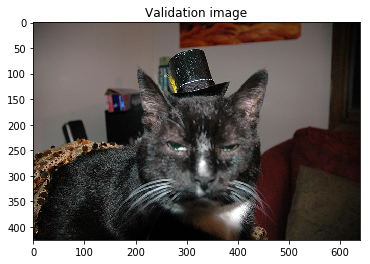

Original caption:  A black cat wearing a little party hat.
Generated caption:  a cat laying on a table next to a laptop.
BLEU_1: Cumulative 1-gram: 0.181818


/opt/conda/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [19]:
caption, pred_caption, bleu_1 = get_val_prediction()